# 🔬 ABC2026 CHALLENGE - DEEP EDA v2 (Comprehensive Analysis)
---
**Notebook phân tích chuyên sâu (Deep EDA) cho bài toán Indoor Localization dựa trên BLE.**

## 📋 Mục lục Phân tích:
1. **Setup & Configuration** - Cấu hình đường dẫn tự động (Colab/Local)
2. **Data Loading & Alignment** - Nạp dữ liệu BLE + Label, đồng bộ thời gian
3. **Section A: Class Imbalance Analysis** - Phân tích mất cân bằng lớp chi tiết
4. **Section B: Beacon Infrastructure Analysis** - Đánh giá hạ tầng beacon (coverage, reliability)
5. **Section C: Signal Quality Analysis** - Chất lượng tín hiệu RSSI (SNR, stability, gaps)
6. **Section D: Temporal Patterns** - Phân tích theo thời gian (hourly, daily)
7. **Section E: Spatial Fingerprint Analysis** - Dấu vân tay không gian (RSSI patterns)
8. **Section F: Feature Engineering** - Tạo đặc trưng (Sliding Window + Robust Stats)
9. **Section G: Feature Quality Assessment** - Đánh giá chất lượng đặc trưng (PCA, t-SNE, Correlation)

## 📌 Quy tắc:
- **Mỗi biểu đồ PHẢI có**: Tên, Mô tả, Params, Data Notes
- **Print toàn bộ dữ liệu** tạo ra biểu đồ để người dùng có thể cung cấp cho AI đọc
- **Lưu metadata** vào `plot_metadata.json`


In [48]:
# =============================================================================
# CELL 1: SETUP & CONFIGURATION (Auto-detect Colab vs Local)
# =============================================================================
import os
import sys
from pathlib import Path
import json
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datetime import datetime

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_theme(style="whitegrid", palette="viridis")

# --- AUTO-DETECT ENVIRONMENT ---
IS_COLAB = 'google.colab' in sys.modules

if IS_COLAB:
    # Colab: Download data if needed
    import requests, zipfile
    DATA_URL = "https://bkuteam.site/data.zip"
    BASE_DIR = Path("/content/ABC2026")
    BASE_DIR.mkdir(parents=True, exist_ok=True)
    DATA_ROOT = BASE_DIR / "ABC2026 Sozolab Challenge"
    DATASET_DIR = DATA_ROOT / "Dataset"
    
    if not (DATASET_DIR.exists() and any(DATASET_DIR.glob("*.csv"))):
        print("Downloading data.zip...")
        ZIP_PATH = BASE_DIR / "data.zip"
        resp = requests.get(DATA_URL, stream=True)
        resp.raise_for_status()
        with open(ZIP_PATH, "wb") as f:
            for chunk in resp.iter_content(chunk_size=8192):
                if chunk: f.write(chunk)
        print("Extracting...")
        with zipfile.ZipFile(ZIP_PATH, "r") as zf:
            zf.extractall(BASE_DIR)
    print(f"[COLAB] Data ready at: {DATASET_DIR}")
else:
    # Local: Use workspace path
    WORKSPACE = Path(r"E:\project\ABC2026")
    DATA_ROOT = WORKSPACE / "ABC2026 Sozolab Challenge"
    DATASET_DIR = DATA_ROOT / "Dataset"
    print(f"[LOCAL] Data at: {DATASET_DIR}")

DATA_PATH = str(DATASET_DIR)
OUTPUT_PATH = str(DATA_ROOT)

# --- BEACON MAPPING (25 Beacons) ---
MAC_LIST = [
    'F7:7F:78:76:7E:F3', 'C6:CD:5E:3D:2F:BB', 'D6:F4:3A:79:74:63', 'C9:17:55:E2:3E:0E', 'CA:60:AB:EE:EC:7F',
    'D6:51:7F:AB:0E:29', 'CC:54:33:F6:A7:90', 'EB:20:56:87:04:5A', 'EE:E7:46:DC:19:6F', 'C8:5B:BF:37:07:A0',
    'D7:26:F6:A3:44:D2', 'DD:83:B0:27:FD:36', 'E5:CD:4A:36:87:06', 'DC:22:B8:17:4E:B5', 'EA:09:20:80:D6:44',
    'E6:99:D1:EC:C6:81', 'F6:DA:97:C7:D5:28', 'EA:66:A1:12:2C:F4', 'C9:EA:57:8B:0F:80', 'D6:7C:1D:2C:2A:0A',
    'DA:E1:70:5F:44:97', 'DD:10:10:F6:4F:27', 'E6:F3:93:A8:9E:22', 'E6:60:05:1F:88:F9', 'D4:33:FD:F4:C2:A8'
]
BEACON_IDS = [str(i) for i in range(1, 26)]
MAC_TO_BEACON = dict(zip(MAC_LIST, BEACON_IDS))

print(f"Environment: {'COLAB' if IS_COLAB else 'LOCAL'}")
print(f"Data Path: {DATA_PATH}")
print(f"Output Path: {OUTPUT_PATH}")
print(f"Beacons: {len(BEACON_IDS)}")


[COLAB] Data ready at: /content/ABC2026/ABC2026 Sozolab Challenge/Dataset
Environment: COLAB
Data Path: /content/ABC2026/ABC2026 Sozolab Challenge/Dataset
Output Path: /content/ABC2026/ABC2026 Sozolab Challenge
Beacons: 25


In [49]:
# =============================================================================
# CELL 2: PLOT LOGGING HELPER (Bắt buộc cho mọi biểu đồ)
# =============================================================================
PLOT_REGISTRY = []
PLOT_META_PATH = os.path.join(OUTPUT_PATH, "plot_metadata_v2.json")

from datetime import date, datetime as dt

class NumpyEncoder(json.JSONEncoder):
    """Custom JSON encoder for numpy types, dates, and pandas objects"""
    def default(self, obj):
        # Numpy types
        if isinstance(obj, (np.integer, np.int64, np.int32)):
            return int(obj)
        elif isinstance(obj, (np.floating, np.float64, np.float32)):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, (np.bool_,)):
            return bool(obj)
        # Date/datetime types
        elif isinstance(obj, (date, dt)):
            return obj.isoformat()
        elif isinstance(obj, pd.Timestamp):
            return obj.isoformat()
        # Pandas types
        elif isinstance(obj, pd.Series):
            return obj.tolist()
        elif isinstance(obj, pd.DataFrame):
            return obj.to_dict(orient='records')
        elif pd.isna(obj):
            return None
        return super().default(obj)

def log_plot(name: str, description: str = "", params: dict = None, data_notes: dict = None):
    """
    Ghi log metadata cho biểu đồ.
    - In ra console để người dùng copy cho AI đọc
    - Lưu vào JSON file
    """
    meta = {
        "name": name,
        "description": description,
        "params": params or {},
        "data_notes": data_notes or {},
        "timestamp": datetime.now().isoformat(),
    }
    PLOT_REGISTRY.append(meta)
    
    # Print full data for AI to read
    print("=" * 60)
    print(f"[PLOT] {name}")
    print("=" * 60)
    print(f"Description: {description}")
    print(f"Params: {json.dumps(params or {}, indent=2, ensure_ascii=False, cls=NumpyEncoder)}")
    print(f"Data Notes: {json.dumps(data_notes or {}, indent=2, ensure_ascii=False, cls=NumpyEncoder)}")
    print("=" * 60)
    
    # Save to file
    try:
        with open(PLOT_META_PATH, "w", encoding="utf-8") as f:
            json.dump(PLOT_REGISTRY, f, ensure_ascii=False, indent=2, cls=NumpyEncoder)
    except Exception as e:
        print(f"[WARN] Cannot save plot metadata: {e}")

def print_dataframe_info(df: pd.DataFrame, name: str = "DataFrame"):
    """In thông tin DataFrame chi tiết"""
    print(f"\n{'='*60}")
    print(f"[INFO] {name}")
    print(f"{'='*60}")
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print(f"Dtypes:\n{df.dtypes.value_counts().to_dict()}")
    print(f"Memory: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    if df.select_dtypes(include=[np.number]).shape[1] > 0:
        print(f"Numeric stats:\n{df.describe().round(2).to_string()}")
    print(f"{'='*60}\n")

print("Plot logging helper ready.")


Plot logging helper ready.


In [50]:
# =============================================================================
# CELL 3: DATA LOADING & ALIGNMENT
# =============================================================================
print("Loading BLE and Label data...")

# 1. Find files
ble_folder = os.path.join(DATA_PATH, "BLE Data")
ble_files = []
label_file = None

if os.path.exists(ble_folder):
    for f in os.listdir(ble_folder):
        if f.endswith(".csv") and "user-ble-id_90" in f:
            ble_files.append(os.path.join(ble_folder, f))

for f in os.listdir(DATA_PATH):
    if "label" in f.lower() and "train" in f.lower() and f.endswith(".csv"):
        label_file = os.path.join(DATA_PATH, f)

print(f"Found {len(ble_files)} BLE files")
print(f"Label file: {os.path.basename(label_file) if label_file else 'NOT FOUND'}")

# 2. Load BLE data
ble_dfs = []
for f in tqdm(ble_files, desc="Loading BLE"):
    try:
        df = pd.read_csv(f, header=None, names=['user_id', 'timestamp', 'scan_content', 'mac_address', 'RSSI', 'tx_power'])
        df = df[df['mac_address'].isin(MAC_LIST)].copy()
        if not df.empty:
            df['beacon_id'] = df['mac_address'].map(MAC_TO_BEACON)
            ble_dfs.append(df[['timestamp', 'beacon_id', 'RSSI']])
    except Exception as e:
        pass  # Skip corrupted files

df_ble = pd.concat(ble_dfs, ignore_index=True)
df_ble['datetime'] = pd.to_datetime(df_ble['timestamp'], utc=True).dt.tz_convert('Asia/Tokyo')
df_ble = df_ble.sort_values('datetime').reset_index(drop=True)

print(f"\nBLE Data loaded: {len(df_ble):,} samples")
print(f"Time range: {df_ble['datetime'].min()} -> {df_ble['datetime'].max()}")
print(f"Beacons seen: {df_ble['beacon_id'].nunique()}")

# 3. Load Label data
df_lbl = pd.read_csv(label_file)
df_lbl = df_lbl[df_lbl['activity'] == 'Location'].copy()
for col in ['started_at', 'finished_at']:
    df_lbl[col] = pd.to_datetime(df_lbl[col])
    if df_lbl[col].dt.tz is None:
        df_lbl[col] = df_lbl[col].dt.tz_localize('Asia/Tokyo')
    else:
        df_lbl[col] = df_lbl[col].dt.tz_convert('Asia/Tokyo')
df_lbl = df_lbl.sort_values(['user_id', 'started_at']).reset_index(drop=True)

print(f"\nLabel Data loaded: {len(df_lbl):,} segments")
print(f"Users: {sorted(df_lbl['user_id'].unique())}")
print(f"Locations: {df_lbl['room'].nunique()}")

# 4. Align BLE with Labels
print("\nAligning BLE with Labels...")
labeled_data = []
for _, row in tqdm(df_lbl.iterrows(), total=len(df_lbl), desc="Aligning"):
    mask = (df_ble['datetime'] >= row['started_at']) & (df_ble['datetime'] <= row['finished_at'])
    subset = df_ble[mask].copy()
    if not subset.empty:
        subset['location'] = row['room']
        subset['label_user_id'] = row['user_id']
        labeled_data.append(subset)

df_final = pd.concat(labeled_data, ignore_index=True)

# Save summary
raw_summary = {
    'total_samples': int(len(df_final)),
    'time_range': {'start': str(df_final['datetime'].min()), 'end': str(df_final['datetime'].max())},
    'num_locations': int(df_final['location'].nunique()),
    'num_beacons': int(df_final['beacon_id'].nunique()),
    'locations': {k: int(v) for k, v in df_final['location'].value_counts().to_dict().items()},
    'label_users': {str(k): int(v) for k, v in df_final['label_user_id'].value_counts().to_dict().items()},
}
with open(os.path.join(OUTPUT_PATH, 'data_summary_raw_v2.json'), 'w', encoding='utf-8') as f:
    json.dump(raw_summary, f, indent=2, ensure_ascii=False)

print("\n" + "="*60)
print("[DATA SUMMARY]")
print("="*60)
print(json.dumps(raw_summary, indent=2, ensure_ascii=False))
print("="*60)


Loading BLE and Label data...
Found 4107 BLE files
Label file: 5f_label_loc_train.csv


Loading BLE: 100%|██████████| 4107/4107 [00:15<00:00, 262.49it/s]



BLE Data loaded: 2,069,743 samples
Time range: 2023-04-10 10:22:55.753000+09:00 -> 2023-04-13 13:56:21.710000+09:00
Beacons seen: 25

Label Data loaded: 1,325 segments
Users: [np.int64(91), np.int64(97)]
Locations: 45

Aligning BLE with Labels...


Aligning: 100%|██████████| 1325/1325 [00:14<00:00, 92.11it/s]



[DATA SUMMARY]
{
  "total_samples": 1888019,
  "time_range": {
    "start": "2023-04-10 14:21:46.003000+09:00",
    "end": "2023-04-13 12:50:50.675000+09:00"
  },
  "num_locations": 44,
  "num_beacons": 25,
  "locations": {
    "nurse station": 538553,
    "Office Small": 210400,
    "cafeteria": 198877,
    "Office Large": 193737,
    "kitchen": 167730,
    "Cafeteria D": 157583,
    "hallway": 116266,
    "523": 34405,
    "513": 21494,
    "213": 21478,
    "208": 21295,
    "cleaning": 19977,
    "Cafeteria A": 18335,
    "201": 16244,
    "210": 14695,
    "Cafeteria B": 14252,
    "511": 13639,
    "512": 12362,
    "520": 10480,
    "522": 8520,
    "207": 8465,
    "202": 8292,
    "206": 7346,
    "506": 6660,
    "Clean Room": 6621,
    "Clean 9": 5067,
    "203": 4571,
    "515": 4150,
    "501": 3689,
    "Cafeteria C": 3070,
    "Bathroom": 3041,
    "508": 2404,
    "516": 2216,
    "Nurse Room": 1996,
    "502": 1900,
    "503": 1534,
    "517": 1459,
    "212": 1176,
 

# 📊 SECTION A: CLASS IMBALANCE ANALYSIS
---
Phân tích chi tiết mức độ mất cân bằng giữa các lớp (location).

**Metrics:**
- Imbalance Ratio (IR): Max/Min samples
- Gini Coefficient: 0 = perfect balance, 1 = extreme imbalance
- Lorenz Curve: Visual representation of inequality


[DATA FOR PLOT] A.1 Location Sample Distribution

>>> STATISTICS:
  Total samples: 1,888,019
  Num locations: 44
  Max: 538,553 | Min: 234
  Mean: 42,909.52 | Median: 7,819.00 | Std: 96,661.58
  Imbalance Ratio (Max/Min): 2,301.51x

>>> FULL DATA (ALL 44 LOCATIONS):
--------------------------------------------------
   1. nurse station       :  538,553 (28.52%) ████████████████████████████
   2. Office Small        :  210,400 (11.14%) ███████████
   3. cafeteria           :  198,877 (10.53%) ██████████
   4. Office Large        :  193,737 (10.26%) ██████████
   5. kitchen             :  167,730 ( 8.88%) ████████
   6. Cafeteria D         :  157,583 ( 8.35%) ████████
   7. hallway             :  116,266 ( 6.16%) ██████
   8. 523                 :   34,405 ( 1.82%) █
   9. 513                 :   21,494 ( 1.14%) █
  10. 213                 :   21,478 ( 1.14%) █
  11. 208                 :   21,295 ( 1.13%) █
  12. cleaning            :   19,977 ( 1.06%) █
  13. Cafeteria A         :   18

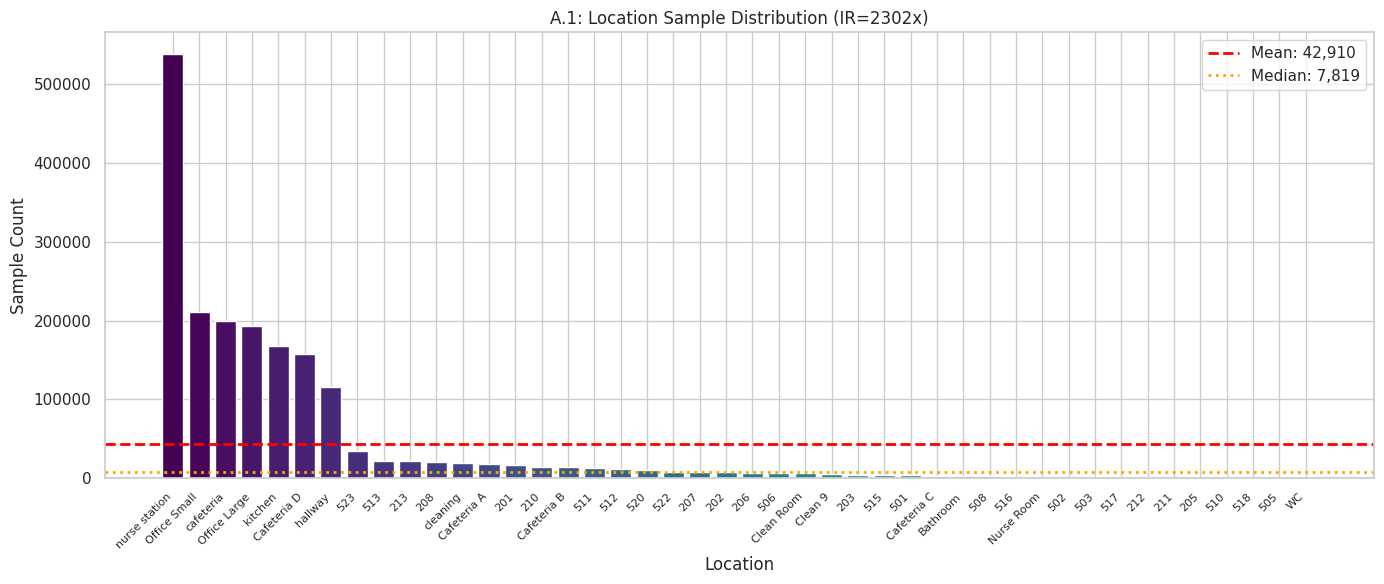

In [51]:
# =============================================================================
# CELL 5: A.1 - Location Sample Distribution (Bar Chart)
# =============================================================================
loc_counts = df_final['location'].value_counts().sort_values(ascending=False)

# Calculate metrics
imbalance_ratio = loc_counts.max() / loc_counts.min()
mean_samples = loc_counts.mean()
median_samples = loc_counts.median()
std_samples = loc_counts.std()

# Prepare data for plot
plot_data = {
    "locations": loc_counts.index.tolist(),
    "counts": loc_counts.values.tolist(),
    "percentages": (loc_counts / loc_counts.sum() * 100).round(2).tolist()
}

params = {
    "total_samples": int(loc_counts.sum()),
    "num_locations": int(len(loc_counts)),
    "max_count": int(loc_counts.max()),
    "min_count": int(loc_counts.min()),
    "mean_count": round(mean_samples, 2),
    "median_count": round(median_samples, 2),
    "std_count": round(std_samples, 2),
    "imbalance_ratio": round(imbalance_ratio, 2),
}

data_notes = {
    "top5": {k: int(v) for k, v in loc_counts.head(5).to_dict().items()},
    "bottom5": {k: int(v) for k, v in loc_counts.tail(5).to_dict().items()},
    "all_locations": {k: int(v) for k, v in loc_counts.to_dict().items()},
}

# Print ALL data (để AI đọc được chính xác)
print("="*70)
print("[DATA FOR PLOT] A.1 Location Sample Distribution")
print("="*70)
print(f"\n>>> STATISTICS:")
print(f"  Total samples: {params['total_samples']:,}")
print(f"  Num locations: {params['num_locations']}")
print(f"  Max: {params['max_count']:,} | Min: {params['min_count']:,}")
print(f"  Mean: {params['mean_count']:,.2f} | Median: {params['median_count']:,.2f} | Std: {params['std_count']:,.2f}")
print(f"  Imbalance Ratio (Max/Min): {params['imbalance_ratio']:,.2f}x")

print(f"\n>>> FULL DATA (ALL {len(loc_counts)} LOCATIONS):")
print("-"*50)
for i, (loc, cnt) in enumerate(loc_counts.items(), 1):
    pct = cnt / loc_counts.sum() * 100
    bar = '█' * int(pct)
    print(f"  {i:2d}. {loc:20s}: {cnt:>8,} ({pct:5.2f}%) {bar}")
print("-"*50)
print("="*70)

# Plot
fig, ax = plt.subplots(figsize=(14, 6))
colors = plt.cm.viridis(np.linspace(0, 0.8, len(loc_counts)))
bars = ax.bar(range(len(loc_counts)), loc_counts.values, color=colors)
ax.axhline(mean_samples, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_samples:,.0f}')
ax.axhline(median_samples, color='orange', linestyle=':', linewidth=2, label=f'Median: {median_samples:,.0f}')
ax.set_xticks(range(len(loc_counts)))
ax.set_xticklabels(loc_counts.index, rotation=45, ha='right', fontsize=8)
ax.set_xlabel("Location")
ax.set_ylabel("Sample Count")
ax.set_title(f"A.1: Location Sample Distribution (IR={imbalance_ratio:.0f}x)")
ax.legend()
plt.tight_layout()

log_plot(
    name="A.1 Location Sample Distribution",
    description="Phân bố số lượng mẫu theo từng location, đánh giá mức độ mất cân bằng",
    params=params,
    data_notes=data_notes
)
plt.show()


[DATA FOR PLOT] Lorenz Curve & Gini Coefficient
Gini Coefficient: 0.7832
Interpretation: SEVERE imbalance

Cumulative Distribution:
  Bottom 10% locations hold: 0.16% of samples
  Bottom 25% locations hold: 0.76% of samples
  Bottom 50% locations hold: 3.67% of samples
  Bottom 75% locations hold: 12.05% of samples
[PLOT] A.2 Lorenz Curve & Gini
Description: Đường cong Lorenz và hệ số Gini đo lường mức độ mất cân bằng lớp
Params: {
  "gini_coefficient": 0.7832,
  "num_locations": 44,
  "area_under_lorenz": 0.1084,
  "interpretation": "High"
}
Data Notes: {
  "lorenz_points": {
    "x": [
      0.023,
      0.045,
      0.068,
      0.091,
      0.114,
      0.136,
      0.159,
      0.182,
      0.205,
      0.227,
      0.25,
      0.273,
      0.295,
      0.318,
      0.341,
      0.364,
      0.386,
      0.409,
      0.432,
      0.455,
      0.477,
      0.5,
      0.523,
      0.545,
      0.568,
      0.591,
      0.614,
      0.636,
      0.659,
      0.682,
      0.705,
     

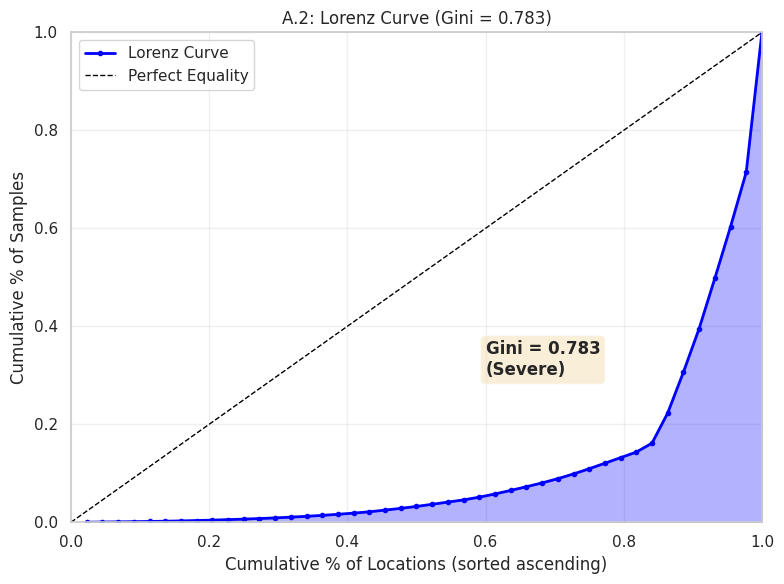

In [52]:
# =============================================================================
# CELL 6: A.2 - Lorenz Curve & Gini Coefficient
# =============================================================================
# Calculate Lorenz curve
loc_sorted = loc_counts.sort_values()
cumsum = np.cumsum(loc_sorted.values)
lorenz_y = cumsum / cumsum[-1]
lorenz_x = np.arange(1, len(lorenz_y) + 1) / len(lorenz_y)

# Calculate Gini coefficient
gini = 1 - 2 * np.trapz(lorenz_y, lorenz_x)

# Area under Lorenz curve
area_lorenz = np.trapz(lorenz_y, lorenz_x)
area_equality = 0.5  # Perfect equality line

params = {
    "gini_coefficient": round(gini, 4),
    "num_locations": len(loc_sorted),
    "area_under_lorenz": round(area_lorenz, 4),
    "interpretation": "High" if gini > 0.6 else "Medium" if gini > 0.4 else "Low"
}

data_notes = {
    "lorenz_points": {
        "x": lorenz_x.round(3).tolist(),
        "y": lorenz_y.round(4).tolist()
    },
    "cumulative_percentages": {
        "10%_locations": round(lorenz_y[int(0.1*len(lorenz_y))] * 100, 2),
        "25%_locations": round(lorenz_y[int(0.25*len(lorenz_y))] * 100, 2),
        "50%_locations": round(lorenz_y[int(0.5*len(lorenz_y))] * 100, 2),
        "75%_locations": round(lorenz_y[int(0.75*len(lorenz_y))] * 100, 2),
    }
}

# Print data
print("="*60)
print("[DATA FOR PLOT] Lorenz Curve & Gini Coefficient")
print("="*60)
print(f"Gini Coefficient: {gini:.4f}")
print(f"Interpretation: {'SEVERE imbalance' if gini > 0.7 else 'HIGH imbalance' if gini > 0.5 else 'MODERATE imbalance'}")
print(f"\nCumulative Distribution:")
print(f"  Bottom 10% locations hold: {data_notes['cumulative_percentages']['10%_locations']:.2f}% of samples")
print(f"  Bottom 25% locations hold: {data_notes['cumulative_percentages']['25%_locations']:.2f}% of samples")
print(f"  Bottom 50% locations hold: {data_notes['cumulative_percentages']['50%_locations']:.2f}% of samples")
print(f"  Bottom 75% locations hold: {data_notes['cumulative_percentages']['75%_locations']:.2f}% of samples")
print("="*60)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(lorenz_x, lorenz_y, 'b-', linewidth=2, marker='o', markersize=3, label='Lorenz Curve')
ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Perfect Equality')
ax.fill_between(lorenz_x, lorenz_y, alpha=0.3, color='blue')
ax.set_xlabel("Cumulative % of Locations (sorted ascending)")
ax.set_ylabel("Cumulative % of Samples")
ax.set_title(f"A.2: Lorenz Curve (Gini = {gini:.3f})")
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

# Add annotation
ax.annotate(f'Gini = {gini:.3f}\n({"Severe" if gini > 0.7 else "High"})', 
            xy=(0.6, 0.3), fontsize=12, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
log_plot(
    name="A.2 Lorenz Curve & Gini",
    description="Đường cong Lorenz và hệ số Gini đo lường mức độ mất cân bằng lớp",
    params=params,
    data_notes=data_notes
)
plt.show()


[DATA FOR PLOT] Pie Chart - Top 10 Locations
Top 10 locations: 87.95% of total samples
Others (34 locations): 12.05%

Breakdown:
  nurse station: 538,553 (28.52%)
  Office Small: 210,400 (11.14%)
  cafeteria: 198,877 (10.53%)
  Office Large: 193,737 (10.26%)
  kitchen: 167,730 (8.88%)
  Cafeteria D: 157,583 (8.35%)
  hallway: 116,266 (6.16%)
  523: 34,405 (1.82%)
  513: 21,494 (1.14%)
  213: 21,478 (1.14%)
  Others: 227,496 (12.05%)
[PLOT] A.3 Pie Chart Top 10
Description: Biểu đồ tròn phân bố mẫu Top 10 location và phần còn lại
Params: {
  "top_n": 10,
  "top_n_sum": 1660523,
  "top_n_pct": 87.95,
  "others_sum": 227496,
  "others_pct": 12.05,
  "num_in_others": 34
}
Data Notes: {
  "pie_data": {
    "nurse station": 538553,
    "Office Small": 210400,
    "cafeteria": 198877,
    "Office Large": 193737,
    "kitchen": 167730,
    "Cafeteria D": 157583,
    "hallway": 116266,
    "523": 34405,
    "513": 21494,
    "213": 21478,
    "Others": 227496
  },
  "top_location": "nurse stati

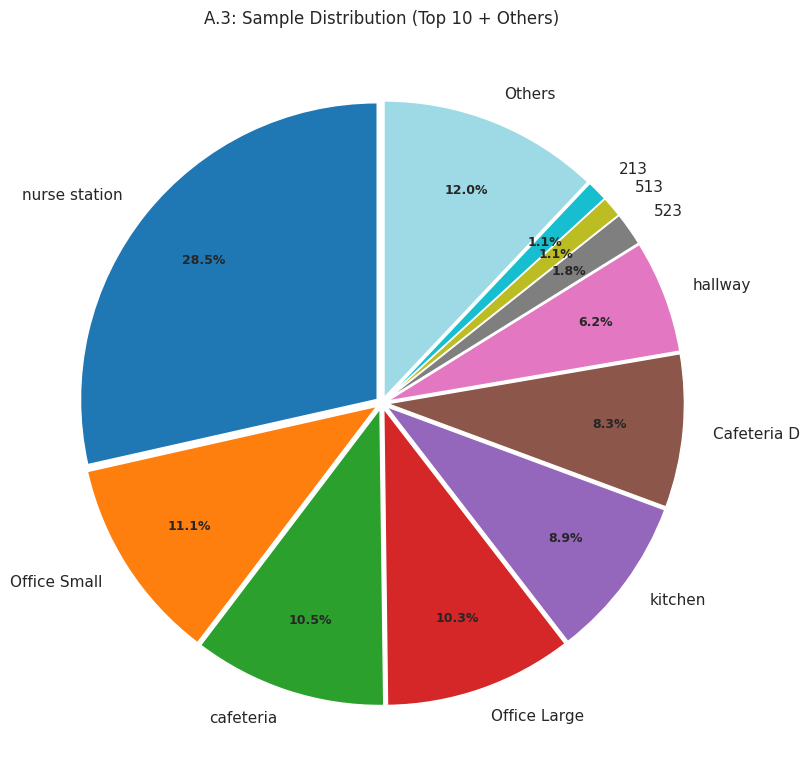

In [53]:
# =============================================================================
# CELL 7: A.3 - Pie Chart (Top 10 + Others)
# =============================================================================
top_n = 10
top_locs = loc_counts.head(top_n)
others = loc_counts[top_n:].sum()
pie_data = pd.concat([top_locs, pd.Series({'Others': others})])

params = {
    "top_n": top_n,
    "top_n_sum": int(top_locs.sum()),
    "top_n_pct": round(top_locs.sum() / loc_counts.sum() * 100, 2),
    "others_sum": int(others),
    "others_pct": round(others / loc_counts.sum() * 100, 2),
    "num_in_others": len(loc_counts) - top_n
}

data_notes = {
    "pie_data": {k: int(v) for k, v in pie_data.to_dict().items()},
    "top_location": loc_counts.idxmax(),
    "top_location_pct": round(loc_counts.max() / loc_counts.sum() * 100, 2)
}

# Print data
print("="*60)
print("[DATA FOR PLOT] Pie Chart - Top 10 Locations")
print("="*60)
print(f"Top {top_n} locations: {params['top_n_pct']:.2f}% of total samples")
print(f"Others ({params['num_in_others']} locations): {params['others_pct']:.2f}%")
print(f"\nBreakdown:")
for loc, cnt in pie_data.items():
    print(f"  {loc}: {cnt:,} ({cnt/loc_counts.sum()*100:.2f}%)")
print("="*60)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
colors = plt.cm.tab20(np.linspace(0, 1, len(pie_data)))
wedges, texts, autotexts = ax.pie(
    pie_data.values, 
    labels=pie_data.index,
    autopct='%1.1f%%',
    colors=colors,
    startangle=90,
    pctdistance=0.75,
    explode=[0.02] * len(pie_data)
)
plt.setp(autotexts, size=9, weight='bold')
ax.set_title(f"A.3: Sample Distribution (Top {top_n} + Others)")

plt.tight_layout()
log_plot(
    name="A.3 Pie Chart Top 10",
    description="Biểu đồ tròn phân bố mẫu Top 10 location và phần còn lại",
    params=params,
    data_notes=data_notes
)
plt.show()


# 📡 SECTION B: BEACON INFRASTRUCTURE ANALYSIS
---
Đánh giá hạ tầng beacon: độ phủ (coverage), tần suất phát hiện, và độ tin cậy.

**Key Metrics:**
- Detection Frequency: Số lần beacon được phát hiện
- Coverage: % location có beacon signal
- Reliability Score: Kết hợp coverage + RSSI strength


[DATA FOR PLOT] B.1 Beacon Detection Frequency

>>> STATISTICS:
  Total detections: 1,888,019
  Num beacons: 25
  Max: 400,432 | Min: 1,107
  Mean: 75,520.76 | Median: 35,013.00
  Detection Ratio (Max/Min): 361.73x

>>> FULL DATA (ALL 25 BEACONS, sorted by count DESC):
--------------------------------------------------
   1. Beacon  4:  400,432 (21.21%) ██████████████████████████████████████████
   2. Beacon  9:  382,287 (20.25%) ████████████████████████████████████████
   3. Beacon 14:  266,152 (14.10%) ████████████████████████████
   4. Beacon  7:  153,467 ( 8.13%) ████████████████
   5. Beacon 19:  131,798 ( 6.98%) █████████████
   6. Beacon 18:   78,006 ( 4.13%) ████████
   7. Beacon  8:   64,883 ( 3.44%) ██████
   8. Beacon 20:   61,138 ( 3.24%) ██████
   9. Beacon  6:   60,532 ( 3.21%) ██████
  10. Beacon 10:   37,541 ( 1.99%) ███
  11. Beacon 23:   37,483 ( 1.99%) ███
  12. Beacon 11:   37,466 ( 1.98%) ███
  13. Beacon 21:   35,013 ( 1.85%) ███
  14. Beacon 22:   33,593 ( 1.78%)

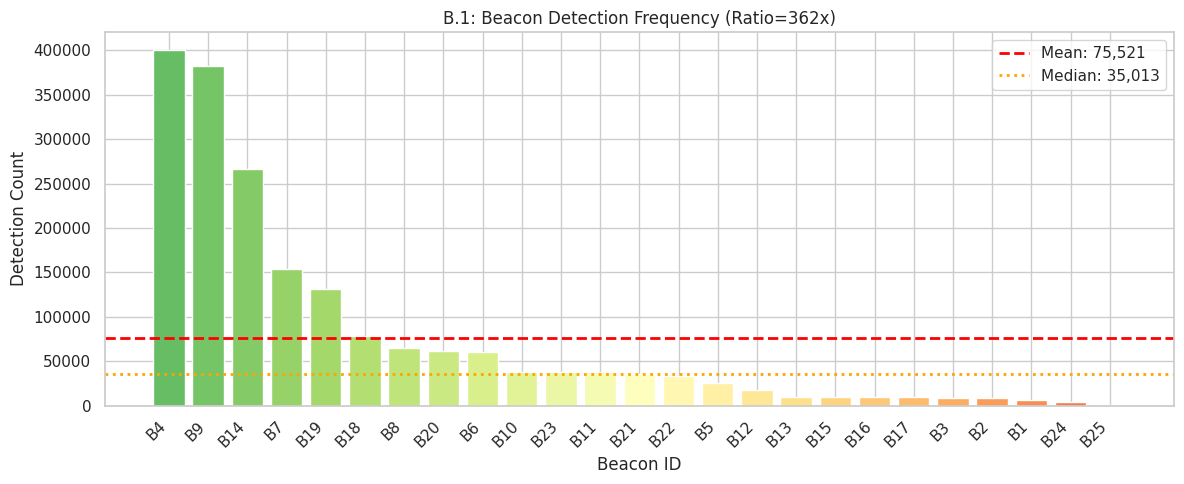

In [54]:
# =============================================================================
# CELL 9: B.1 - Beacon Detection Frequency
# =============================================================================
beacon_counts = df_final['beacon_id'].value_counts().sort_values(ascending=False)

params = {
    "total_detections": int(beacon_counts.sum()),
    "num_beacons": len(beacon_counts),
    "max_detections": int(beacon_counts.max()),
    "min_detections": int(beacon_counts.min()),
    "mean_detections": round(beacon_counts.mean(), 2),
    "median_detections": round(beacon_counts.median(), 2),
    "detection_ratio": round(beacon_counts.max() / beacon_counts.min(), 2)
}

data_notes = {
    "top5_beacons": {k: int(v) for k, v in beacon_counts.head(5).to_dict().items()},
    "bottom5_beacons": {k: int(v) for k, v in beacon_counts.tail(5).to_dict().items()},
    "all_beacons": {k: int(v) for k, v in beacon_counts.sort_index().to_dict().items()}
}

# Print ALL data (để AI đọc được chính xác)
print("="*70)
print("[DATA FOR PLOT] B.1 Beacon Detection Frequency")
print("="*70)
print(f"\n>>> STATISTICS:")
print(f"  Total detections: {params['total_detections']:,}")
print(f"  Num beacons: {params['num_beacons']}")
print(f"  Max: {params['max_detections']:,} | Min: {params['min_detections']:,}")
print(f"  Mean: {params['mean_detections']:,.2f} | Median: {params['median_detections']:,.2f}")
print(f"  Detection Ratio (Max/Min): {params['detection_ratio']:.2f}x")

print(f"\n>>> FULL DATA (ALL 25 BEACONS, sorted by count DESC):")
print("-"*50)
for i, (bid, cnt) in enumerate(beacon_counts.items(), 1):
    pct = cnt / beacon_counts.sum() * 100
    bar = '█' * int(pct * 2)
    print(f"  {i:2d}. Beacon {bid:>2s}: {cnt:>8,} ({pct:5.2f}%) {bar}")
print("-"*50)
print("="*70)

# Plot
fig, ax = plt.subplots(figsize=(12, 5))
x = np.arange(len(beacon_counts))
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(beacon_counts)))[::-1]
ax.bar(x, beacon_counts.values, color=colors)
ax.axhline(beacon_counts.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {beacon_counts.mean():,.0f}')
ax.axhline(beacon_counts.median(), color='orange', linestyle=':', linewidth=2, label=f'Median: {beacon_counts.median():,.0f}')
ax.set_xticks(x)
ax.set_xticklabels([f"B{i}" for i in beacon_counts.index], rotation=45, ha='right')
ax.set_xlabel("Beacon ID")
ax.set_ylabel("Detection Count")
ax.set_title(f"B.1: Beacon Detection Frequency (Ratio={params['detection_ratio']:.0f}x)")
ax.legend()
plt.tight_layout()

log_plot(
    name="B.1 Beacon Detection Frequency",
    description="Tần suất phát hiện của từng beacon (sắp xếp giảm dần)",
    params=params,
    data_notes=data_notes
)
plt.show()


[DATA FOR PLOT] B.2 Beacon Coverage Heatmap

>>> STATISTICS:
  Matrix: 44 locations x 25 beacons = 1100 pairs
  Zero coverage pairs: 413 (37.55%)
  Mean coverage: 4.00%
  High coverage (>50%): 4 pairs

>>> COVERAGE BY BEACON (mean % across all locations):
--------------------------------------------------
  Beacon  1:   1.52% 
  Beacon  2:   2.31% █
  Beacon  3:   2.76% █
  Beacon  4:  11.63% █████
  Beacon  5:   3.94% █
  Beacon  6:   4.12% ██
  Beacon  7:   4.41% ██
  Beacon  8:   4.21% ██
  Beacon  9:  10.28% █████
  Beacon 10:   2.73% █
  Beacon 11:   3.54% █
  Beacon 12:   1.56% 
  Beacon 13:   2.29% █
  Beacon 14:   8.79% ████
  Beacon 15:   2.96% █
  Beacon 16:   3.20% █
  Beacon 17:   2.82% █
  Beacon 18:   3.78% █
  Beacon 19:   5.82% ██
  Beacon 20:   4.87% ██
  Beacon 21:   2.86% █
  Beacon 22:   4.15% ██
  Beacon 23:   5.29% ██
  Beacon 24:   0.11% 
  Beacon 25:   0.06% 
--------------------------------------------------

>>> COVERAGE BY TOP 10 LOCATIONS (mean % across all 

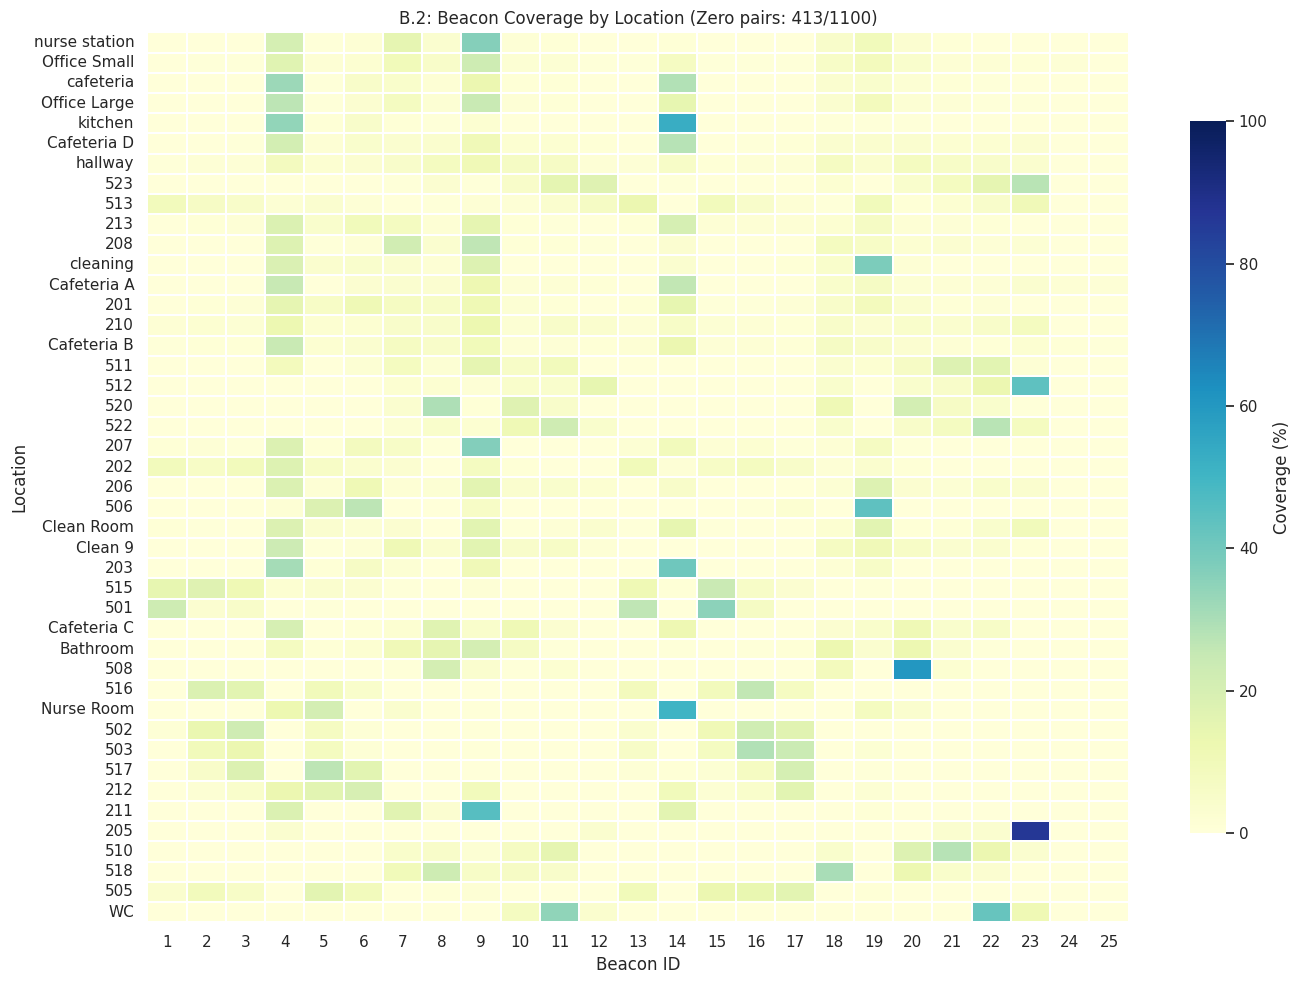

In [55]:
# =============================================================================
# CELL 10: B.2 - Beacon Coverage Heatmap (Location x Beacon)
# =============================================================================
# Calculate coverage matrix: % samples per location that see each beacon
sparsity_data = []
for loc in df_final['location'].unique():
    df_loc = df_final[df_final['location'] == loc]
    total = len(df_loc)
    for b in BEACON_IDS:
        cnt = (df_loc['beacon_id'] == b).sum()
        coverage = (cnt / total * 100) if total > 0 else 0
        sparsity_data.append({'location': loc, 'beacon_id': b, 'coverage_pct': coverage})

df_sparsity = pd.DataFrame(sparsity_data)
coverage_pivot = df_sparsity.pivot(index='location', columns='beacon_id', values='coverage_pct')
coverage_pivot = coverage_pivot[sorted(coverage_pivot.columns, key=lambda x: int(x))]
coverage_pivot = coverage_pivot.loc[loc_counts.index]  # Sort by sample count

# Calculate statistics
zero_pairs = int((coverage_pivot == 0).sum().sum())
total_pairs = int(coverage_pivot.size)
mean_coverage = float(coverage_pivot.mean().mean())
high_coverage = int((coverage_pivot > 50).sum().sum())

params = {
    "num_locations": coverage_pivot.shape[0],
    "num_beacons": coverage_pivot.shape[1],
    "zero_coverage_pairs": zero_pairs,
    "total_pairs": total_pairs,
    "zero_pct": round(zero_pairs / total_pairs * 100, 2),
    "mean_coverage_pct": round(mean_coverage, 2),
    "high_coverage_pairs": high_coverage,
}

data_notes = {
    "coverage_by_beacon": {bid: round(coverage_pivot[bid].mean(), 2) for bid in coverage_pivot.columns},
    "coverage_by_location_top5": {loc: round(coverage_pivot.loc[loc].mean(), 2) for loc in coverage_pivot.index[:5]},
    "coverage_by_location_bottom5": {loc: round(coverage_pivot.loc[loc].mean(), 2) for loc in coverage_pivot.index[-5:]},
}

# Print ALL data (để AI đọc được chính xác)
print("="*70)
print("[DATA FOR PLOT] B.2 Beacon Coverage Heatmap")
print("="*70)
print(f"\n>>> STATISTICS:")
print(f"  Matrix: {params['num_locations']} locations x {params['num_beacons']} beacons = {params['total_pairs']} pairs")
print(f"  Zero coverage pairs: {params['zero_coverage_pairs']} ({params['zero_pct']:.2f}%)")
print(f"  Mean coverage: {params['mean_coverage_pct']:.2f}%")
print(f"  High coverage (>50%): {params['high_coverage_pairs']} pairs")

print(f"\n>>> COVERAGE BY BEACON (mean % across all locations):")
print("-"*50)
for bid in sorted(coverage_pivot.columns, key=int):
    cov = coverage_pivot[bid].mean()
    bar = '█' * int(cov / 2)
    print(f"  Beacon {bid:>2s}: {cov:6.2f}% {bar}")
print("-"*50)

print(f"\n>>> COVERAGE BY TOP 10 LOCATIONS (mean % across all beacons):")
print("-"*50)
for loc in coverage_pivot.index[:10]:
    cov = coverage_pivot.loc[loc].mean()
    bar = '█' * int(cov / 2)
    print(f"  {loc:20s}: {cov:6.2f}% {bar}")
print("-"*50)

print(f"\n>>> FULL COVERAGE MATRIX (top 15 locations x all beacons):")
print("-"*70)
print(f"{'Location':<20s}", end="")
for bid in sorted(coverage_pivot.columns, key=int):
    print(f" B{bid:>2s}", end="")
print()
for loc in coverage_pivot.index[:15]:
    print(f"{loc:<20s}", end="")
    for bid in sorted(coverage_pivot.columns, key=int):
        val = coverage_pivot.loc[loc, bid]
        print(f" {val:4.0f}", end="")
    print()
print("-"*70)
print("="*70)

# Plot
fig, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(coverage_pivot, cmap='YlGnBu', vmin=0, vmax=100, 
            linewidths=0.3, linecolor='white', 
            cbar_kws={'label': 'Coverage (%)', 'shrink': 0.8},
            ax=ax)
ax.set_xlabel("Beacon ID")
ax.set_ylabel("Location")
ax.set_title(f"B.2: Beacon Coverage by Location (Zero pairs: {zero_pairs}/{total_pairs})")
plt.tight_layout()

log_plot(
    name="B.2 Beacon Coverage Heatmap",
    description="Heatmap độ phủ beacon theo location (% mẫu có tín hiệu)",
    params=params,
    data_notes=data_notes
)
plt.show()


[DATA FOR PLOT] Beacon Reliability Score
Best beacon: 4 (score: 10.38)
Worst beacon: 25 (score: 3.97)
Mean score: 7.13 ± 1.56

All beacons (sorted by reliability):
beacon_id  coverage_pct  avg_rssi  std_rssi  rssi_normalized  reliability_score  sample_count
        4         11.63    -93.61      3.73             9.12              10.38        400432
       14          8.79    -91.70      4.34            11.86              10.33        266152
        9         10.28    -92.76      3.85            10.35              10.31        382287
       20          4.87    -91.02      6.22            12.83               8.85         61138
       23          5.29    -92.70      4.68            10.42               7.86         37483
       16          3.20    -91.50      5.25            12.15               7.67          9184
        8          4.21    -92.62      4.46            10.54               7.37         64883
       17          2.82    -91.78      5.19            11.75               7.29     

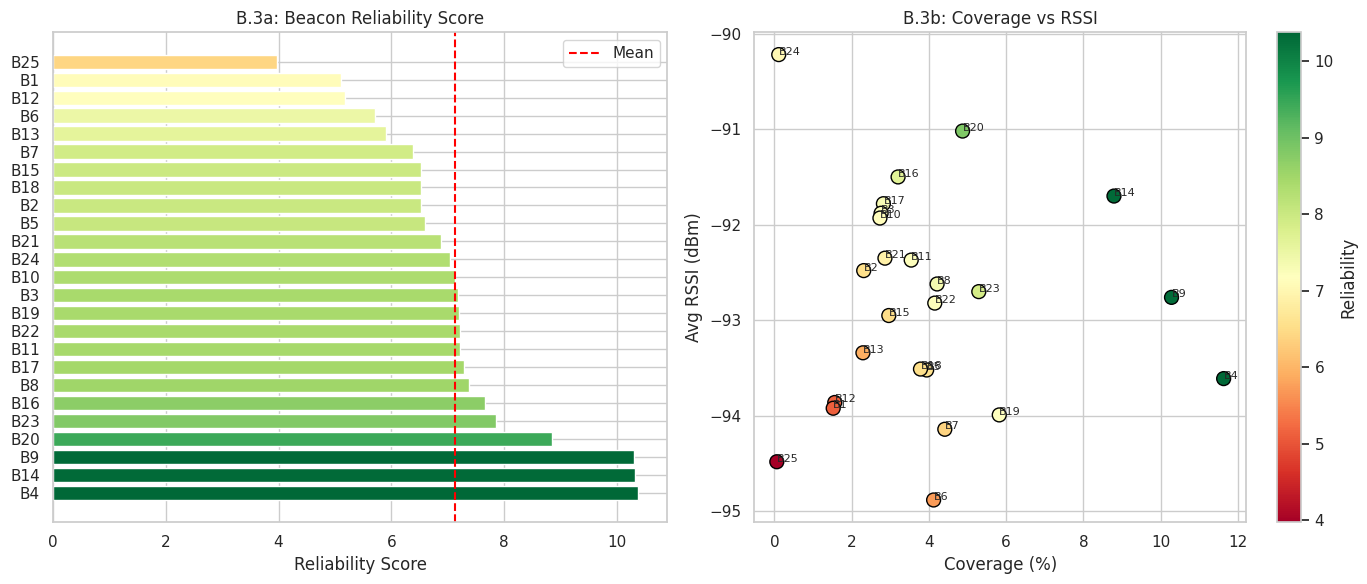

In [56]:
# =============================================================================
# CELL 11: B.3 - Beacon Reliability Score
# =============================================================================
# Reliability = (Normalized Coverage + Normalized RSSI) / 2
# Coverage: % of locations where beacon is seen
# RSSI: Stronger signal (closer to 0) = better

reliability_rows = []
for b in BEACON_IDS:
    beacon_data = df_final[df_final['beacon_id'] == b]
    avg_cov = coverage_pivot[b].mean()  # Mean coverage across locations
    avg_rssi = beacon_data['RSSI'].mean() if len(beacon_data) > 0 else -100
    std_rssi = beacon_data['RSSI'].std() if len(beacon_data) > 0 else 0
    
    # Normalize RSSI to 0-100 scale (assuming -100 is worst, -30 is best)
    rssi_norm = max(0, min(100, (avg_rssi + 100) / 70 * 100))
    
    # Reliability score
    score = (avg_cov + rssi_norm) / 2
    
    reliability_rows.append({
        'beacon_id': b,
        'coverage_pct': round(avg_cov, 2),
        'avg_rssi': round(avg_rssi, 2),
        'std_rssi': round(std_rssi, 2),
        'rssi_normalized': round(rssi_norm, 2),
        'reliability_score': round(score, 2),
        'sample_count': len(beacon_data)
    })

df_reliability = pd.DataFrame(reliability_rows).sort_values('reliability_score', ascending=False)

params = {
    "best_beacon": df_reliability.iloc[0]['beacon_id'],
    "best_score": df_reliability.iloc[0]['reliability_score'],
    "worst_beacon": df_reliability.iloc[-1]['beacon_id'],
    "worst_score": df_reliability.iloc[-1]['reliability_score'],
    "mean_score": round(df_reliability['reliability_score'].mean(), 2),
    "std_score": round(df_reliability['reliability_score'].std(), 2),
}

data_notes = {
    "all_beacons": df_reliability.to_dict('records'),
    "top5": df_reliability.head(5)[['beacon_id', 'reliability_score', 'coverage_pct', 'avg_rssi']].to_dict('records'),
    "bottom5": df_reliability.tail(5)[['beacon_id', 'reliability_score', 'coverage_pct', 'avg_rssi']].to_dict('records'),
}

# Print data
print("="*60)
print("[DATA FOR PLOT] Beacon Reliability Score")
print("="*60)
print(f"Best beacon: {params['best_beacon']} (score: {params['best_score']:.2f})")
print(f"Worst beacon: {params['worst_beacon']} (score: {params['worst_score']:.2f})")
print(f"Mean score: {params['mean_score']:.2f} ± {params['std_score']:.2f}")
print(f"\nAll beacons (sorted by reliability):")
print(df_reliability.to_string(index=False))
print("="*60)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: Reliability Score Bar
ax1 = axes[0]
colors = plt.cm.RdYlGn(df_reliability['reliability_score'].values / df_reliability['reliability_score'].max())
ax1.barh(range(len(df_reliability)), df_reliability['reliability_score'].values, color=colors)
ax1.set_yticks(range(len(df_reliability)))
ax1.set_yticklabels([f"B{bid}" for bid in df_reliability['beacon_id']])
ax1.set_xlabel("Reliability Score")
ax1.set_title("B.3a: Beacon Reliability Score")
ax1.axvline(df_reliability['reliability_score'].mean(), color='red', linestyle='--', label='Mean')
ax1.legend()

# Right: Coverage vs RSSI Scatter
ax2 = axes[1]
sc = ax2.scatter(df_reliability['coverage_pct'], df_reliability['avg_rssi'], 
                  c=df_reliability['reliability_score'], cmap='RdYlGn', s=100, edgecolors='black')
for _, row in df_reliability.iterrows():
    ax2.annotate(f"B{row['beacon_id']}", (row['coverage_pct'], row['avg_rssi']), fontsize=8)
ax2.set_xlabel("Coverage (%)")
ax2.set_ylabel("Avg RSSI (dBm)")
ax2.set_title("B.3b: Coverage vs RSSI")
plt.colorbar(sc, ax=ax2, label='Reliability')

plt.tight_layout()
log_plot(
    name="B.3 Beacon Reliability Score",
    description="Chỉ số độ tin cậy beacon kết hợp coverage và RSSI",
    params=params,
    data_notes=data_notes
)
plt.show()


# 📶 SECTION C: SIGNAL QUALITY ANALYSIS
---
Phân tích chất lượng tín hiệu RSSI chi tiết.

**Key Metrics:**
- RSSI Distribution: Phân phối cường độ tín hiệu
- SNR (Signal-to-Noise Ratio): Mean/Std - cao = ổn định
- Stability Index: 1/CV - độ ổn định theo coefficient of variation
- Time Gaps: Khoảng cách giữa các lần đo


[DATA FOR PLOT] Global RSSI Distribution
Total samples: 1,888,019
Mean: -93.00 dBm
Std: 4.23 dBm
Range: [-108, -74] dBm
Median: -94.00 dBm
IQR: 5.00 dBm (Q25=-96.0, Q75=-91.0)
Skewness: 0.865
Kurtosis: 0.969

RSSI Ranges:
  strong (> -70): 0 (0.00%)
  moderate (-70 to -85): 86,206 (4.57%)
  weak (-85 to -95): 1,038,905 (55.03%)
  very_weak (<= -95): 762,908 (40.41%)
[PLOT] C.1 Global RSSI Distribution
Description: Phân phối cường độ tín hiệu RSSI toàn cục và theo beacon
Params: {
  "count": 1888019,
  "mean": -93.0,
  "std": 4.23,
  "min": -108,
  "max": -74,
  "median": -94.0,
  "q25": -96.0,
  "q75": -91.0,
  "iqr": 5.0,
  "skewness": 0.865,
  "kurtosis": 0.969
}
Data Notes: {
  "rssi_ranges": {
    "strong (> -70)": 0,
    "moderate (-70 to -85)": 86206,
    "weak (-85 to -95)": 1038905,
    "very_weak (<= -95)": 762908
  },
  "percentiles": {
    "1%": -100.0,
    "5%": -99.0,
    "95%": -85.0,
    "99%": -80.0
  }
}


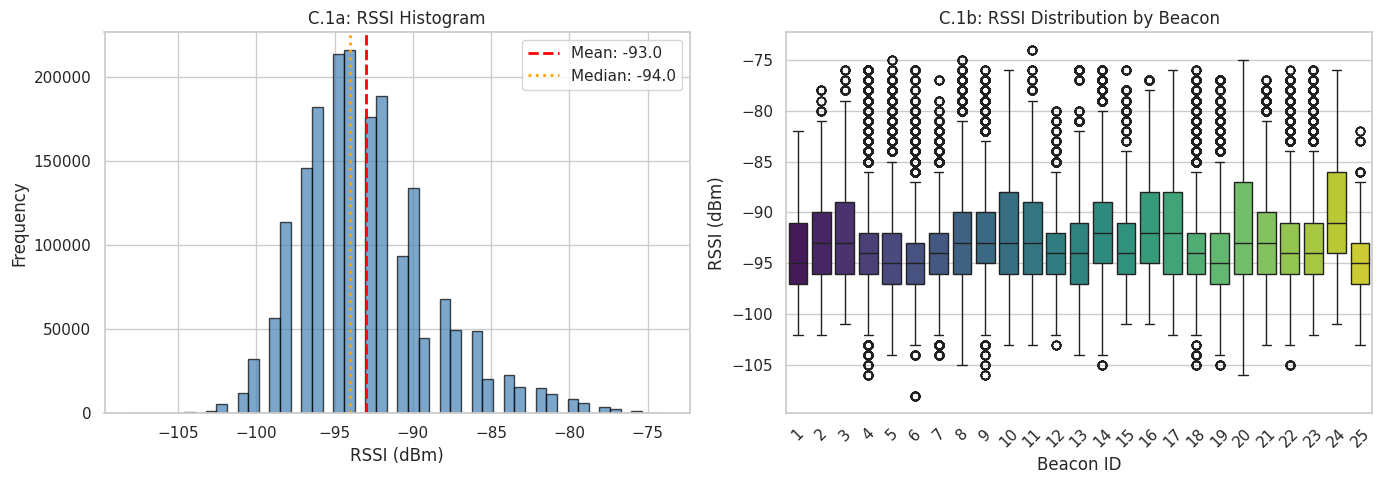

In [57]:
# =============================================================================
# CELL 13: C.1 - Global RSSI Distribution
# =============================================================================
rssi_data = df_final['RSSI']

params = {
    "count": int(len(rssi_data)),
    "mean": round(rssi_data.mean(), 2),
    "std": round(rssi_data.std(), 2),
    "min": int(rssi_data.min()),
    "max": int(rssi_data.max()),
    "median": round(rssi_data.median(), 2),
    "q25": round(rssi_data.quantile(0.25), 2),
    "q75": round(rssi_data.quantile(0.75), 2),
    "iqr": round(rssi_data.quantile(0.75) - rssi_data.quantile(0.25), 2),
    "skewness": round(rssi_data.skew(), 3),
    "kurtosis": round(rssi_data.kurtosis(), 3),
}

# Count by ranges
rssi_ranges = {
    "strong (> -70)": int((rssi_data > -70).sum()),
    "moderate (-70 to -85)": int(((rssi_data <= -70) & (rssi_data > -85)).sum()),
    "weak (-85 to -95)": int(((rssi_data <= -85) & (rssi_data > -95)).sum()),
    "very_weak (<= -95)": int((rssi_data <= -95).sum()),
}

data_notes = {
    "rssi_ranges": rssi_ranges,
    "percentiles": {
        "1%": round(rssi_data.quantile(0.01), 2),
        "5%": round(rssi_data.quantile(0.05), 2),
        "95%": round(rssi_data.quantile(0.95), 2),
        "99%": round(rssi_data.quantile(0.99), 2),
    }
}

# Print data
print("="*60)
print("[DATA FOR PLOT] Global RSSI Distribution")
print("="*60)
print(f"Total samples: {params['count']:,}")
print(f"Mean: {params['mean']:.2f} dBm")
print(f"Std: {params['std']:.2f} dBm")
print(f"Range: [{params['min']}, {params['max']}] dBm")
print(f"Median: {params['median']:.2f} dBm")
print(f"IQR: {params['iqr']:.2f} dBm (Q25={params['q25']}, Q75={params['q75']})")
print(f"Skewness: {params['skewness']:.3f}")
print(f"Kurtosis: {params['kurtosis']:.3f}")
print(f"\nRSSI Ranges:")
for rng, cnt in rssi_ranges.items():
    print(f"  {rng}: {cnt:,} ({cnt/len(rssi_data)*100:.2f}%)")
print("="*60)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax1 = axes[0]
ax1.hist(rssi_data, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax1.axvline(rssi_data.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {rssi_data.mean():.1f}')
ax1.axvline(rssi_data.median(), color='orange', linestyle=':', linewidth=2, label=f'Median: {rssi_data.median():.1f}')
ax1.set_xlabel("RSSI (dBm)")
ax1.set_ylabel("Frequency")
ax1.set_title("C.1a: RSSI Histogram")
ax1.legend()

# Boxplot by beacon
ax2 = axes[1]
df_plot = df_final[['beacon_id', 'RSSI']].copy()
df_plot['beacon_id'] = df_plot['beacon_id'].astype(int)
df_plot = df_plot.sort_values('beacon_id')
sns.boxplot(data=df_plot, x='beacon_id', y='RSSI', ax=ax2, palette='viridis')
ax2.set_xlabel("Beacon ID")
ax2.set_ylabel("RSSI (dBm)")
ax2.set_title("C.1b: RSSI Distribution by Beacon")
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
log_plot(
    name="C.1 Global RSSI Distribution",
    description="Phân phối cường độ tín hiệu RSSI toàn cục và theo beacon",
    params=params,
    data_notes=data_notes
)
plt.show()


[DATA FOR PLOT] SNR & Stability by Location
Best SNR: Nurse Room (33.74)
Worst SNR: 510 (16.47)
Mean SNR: 22.42
Mean Stability: 22.42
High SNR (>20): 31 locations
Low SNR (<15): 0 locations

Top 5 SNR locations:
  Nurse Room: SNR=33.74, Mean=-94.11, Std=2.79
  211: SNR=33.13, Mean=-95.26, Std=2.88
  WC: SNR=31.53, Mean=-95.19, Std=3.02
  205: SNR=29.88, Mean=-95.22, Std=3.19
  508: SNR=27.25, Mean=-94.70, Std=3.48

Bottom 5 SNR locations:
  523: SNR=17.90, Mean=-92.07, Std=5.14
  516: SNR=17.83, Mean=-91.37, Std=5.13
  Clean 9: SNR=17.72, Mean=-91.60, Std=5.17
  505: SNR=17.50, Mean=-91.40, Std=5.22
  510: SNR=16.47, Mean=-92.12, Std=5.59
[PLOT] C.2 SNR & Stability by Location
Description: Tỷ số tín hiệu trên nhiễu (SNR) và độ ổn định theo location
Params: {
  "best_snr_loc": "Nurse Room",
  "best_snr": 33.74,
  "worst_snr_loc": "510",
  "worst_snr": 16.47,
  "mean_snr": 22.42,
  "mean_stability": 22.42,
  "high_snr_count": 31,
  "low_snr_count": 0
}
Data Notes: {
  "top5_snr": [
    {

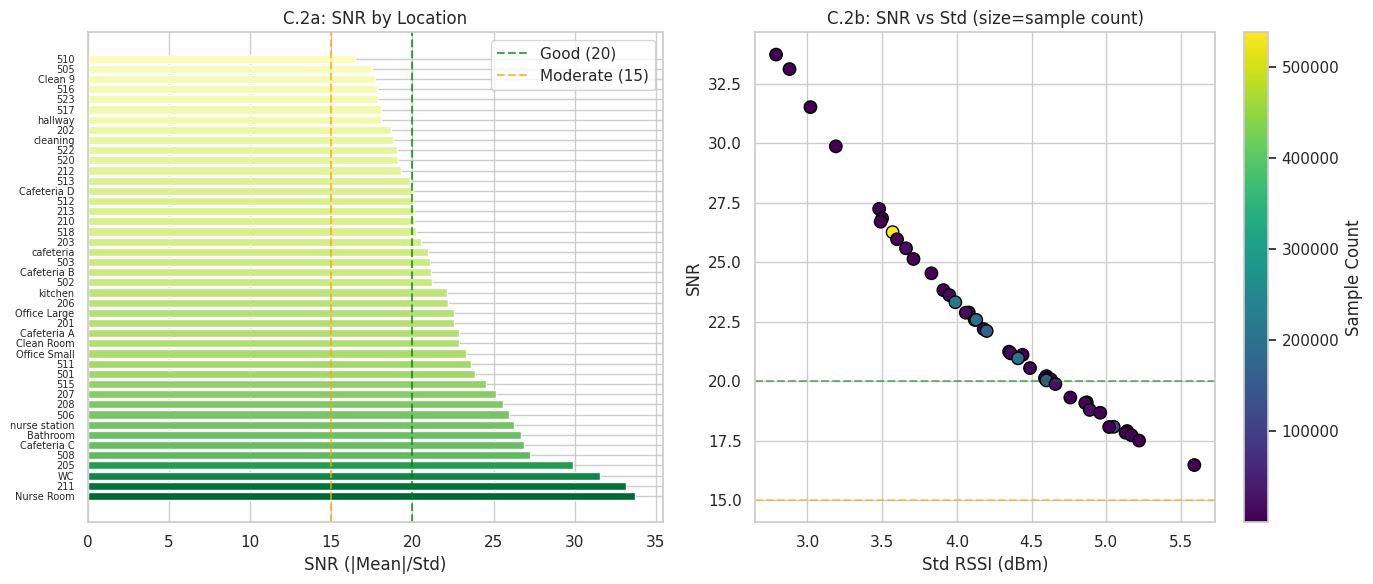

In [58]:
# =============================================================================
# CELL 14: C.2 - SNR & Stability by Location
# =============================================================================
# Calculate SNR and Stability for each location
snr_rows = []
for loc in df_final['location'].unique():
    loc_data = df_final[df_final['location'] == loc]['RSSI']
    mean_rssi = loc_data.mean()
    std_rssi = loc_data.std()
    snr = abs(mean_rssi) / std_rssi if std_rssi > 0 else 0
    cv = std_rssi / abs(mean_rssi) if mean_rssi != 0 else np.inf
    stability = 1 / cv if cv > 0 and cv != np.inf else 0
    
    snr_rows.append({
        'location': loc,
        'mean_rssi': round(mean_rssi, 2),
        'std_rssi': round(std_rssi, 2),
        'snr': round(snr, 2),
        'cv': round(cv, 4),
        'stability_index': round(stability, 2),
        'sample_count': len(loc_data)
    })

df_snr = pd.DataFrame(snr_rows).sort_values('snr', ascending=False)

params = {
    "best_snr_loc": df_snr.iloc[0]['location'],
    "best_snr": df_snr.iloc[0]['snr'],
    "worst_snr_loc": df_snr.iloc[-1]['location'],
    "worst_snr": df_snr.iloc[-1]['snr'],
    "mean_snr": round(df_snr['snr'].mean(), 2),
    "mean_stability": round(df_snr['stability_index'].mean(), 2),
    "high_snr_count": int((df_snr['snr'] > 20).sum()),
    "low_snr_count": int((df_snr['snr'] < 15).sum()),
}

data_notes = {
    "top5_snr": df_snr.head(5)[['location', 'snr', 'mean_rssi', 'std_rssi']].to_dict('records'),
    "bottom5_snr": df_snr.tail(5)[['location', 'snr', 'mean_rssi', 'std_rssi']].to_dict('records'),
    "all_locations": df_snr[['location', 'snr', 'stability_index', 'sample_count']].to_dict('records')
}

# Print data
print("="*60)
print("[DATA FOR PLOT] SNR & Stability by Location")
print("="*60)
print(f"Best SNR: {params['best_snr_loc']} ({params['best_snr']:.2f})")
print(f"Worst SNR: {params['worst_snr_loc']} ({params['worst_snr']:.2f})")
print(f"Mean SNR: {params['mean_snr']:.2f}")
print(f"Mean Stability: {params['mean_stability']:.2f}")
print(f"High SNR (>20): {params['high_snr_count']} locations")
print(f"Low SNR (<15): {params['low_snr_count']} locations")
print(f"\nTop 5 SNR locations:")
for row in data_notes['top5_snr']:
    print(f"  {row['location']}: SNR={row['snr']:.2f}, Mean={row['mean_rssi']:.2f}, Std={row['std_rssi']:.2f}")
print(f"\nBottom 5 SNR locations:")
for row in data_notes['bottom5_snr']:
    print(f"  {row['location']}: SNR={row['snr']:.2f}, Mean={row['mean_rssi']:.2f}, Std={row['std_rssi']:.2f}")
print("="*60)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# SNR Bar
ax1 = axes[0]
colors = plt.cm.RdYlGn(df_snr['snr'].values / df_snr['snr'].max())
ax1.barh(range(len(df_snr)), df_snr['snr'].values, color=colors)
ax1.set_yticks(range(len(df_snr)))
ax1.set_yticklabels(df_snr['location'], fontsize=7)
ax1.set_xlabel("SNR (|Mean|/Std)")
ax1.set_title("C.2a: SNR by Location")
ax1.axvline(20, color='green', linestyle='--', alpha=0.7, label='Good (20)')
ax1.axvline(15, color='orange', linestyle='--', alpha=0.7, label='Moderate (15)')
ax1.legend()

# Stability Scatter
ax2 = axes[1]
sc = ax2.scatter(df_snr['std_rssi'], df_snr['snr'], 
                  c=df_snr['sample_count'], cmap='viridis', s=80, edgecolors='black')
ax2.set_xlabel("Std RSSI (dBm)")
ax2.set_ylabel("SNR")
ax2.set_title("C.2b: SNR vs Std (size=sample count)")
plt.colorbar(sc, ax=ax2, label='Sample Count')
ax2.axhline(20, color='green', linestyle='--', alpha=0.5)
ax2.axhline(15, color='orange', linestyle='--', alpha=0.5)

plt.tight_layout()
log_plot(
    name="C.2 SNR & Stability by Location",
    description="Tỷ số tín hiệu trên nhiễu (SNR) và độ ổn định theo location",
    params=params,
    data_notes=data_notes
)
plt.show()


[DATA FOR PLOT] Time Gap Analysis
Total gaps: 1,888,018
Mean gap: 0.0293 sec
Median gap: 0.0050 sec
Std gap: 1.8756 sec
Range: [0.0000, 1250.98] sec

Gap distribution:
  instant (<0.1s): 1,849,704 (97.97%)
  fast (0.1-1s): 31,426 (1.66%)
  normal (1-10s): 6,572 (0.35%)
  slow (10-60s): 221 (0.01%)
  very_slow (>60s): 89 (0.00%)

Percentiles:
  50%: 0.0050 sec
  90%: 0.0100 sec
  95%: 0.0160 sec
  99%: 0.3550 sec

Large gaps (>60s): 95
[PLOT] C.3 Time Gap Analysis
Description: Phân tích khoảng cách thời gian giữa các lần đo liên tiếp
Params: {
  "total_gaps": 1888018,
  "mean_gap_sec": 0.0293,
  "median_gap_sec": 0.005,
  "std_gap_sec": 1.8756,
  "max_gap_sec": 1250.98,
  "min_gap_sec": 0.0
}
Data Notes: {
  "gap_ranges": {
    "instant (<0.1s)": 1849704,
    "fast (0.1-1s)": 31426,
    "normal (1-10s)": 6572,
    "slow (10-60s)": 221,
    "very_slow (>60s)": 89
  },
  "percentiles": {
    "50%": 0.005,
    "90%": 0.01,
    "95%": 0.016,
    "99%": 0.355
  },
  "large_gaps_count": 95
}


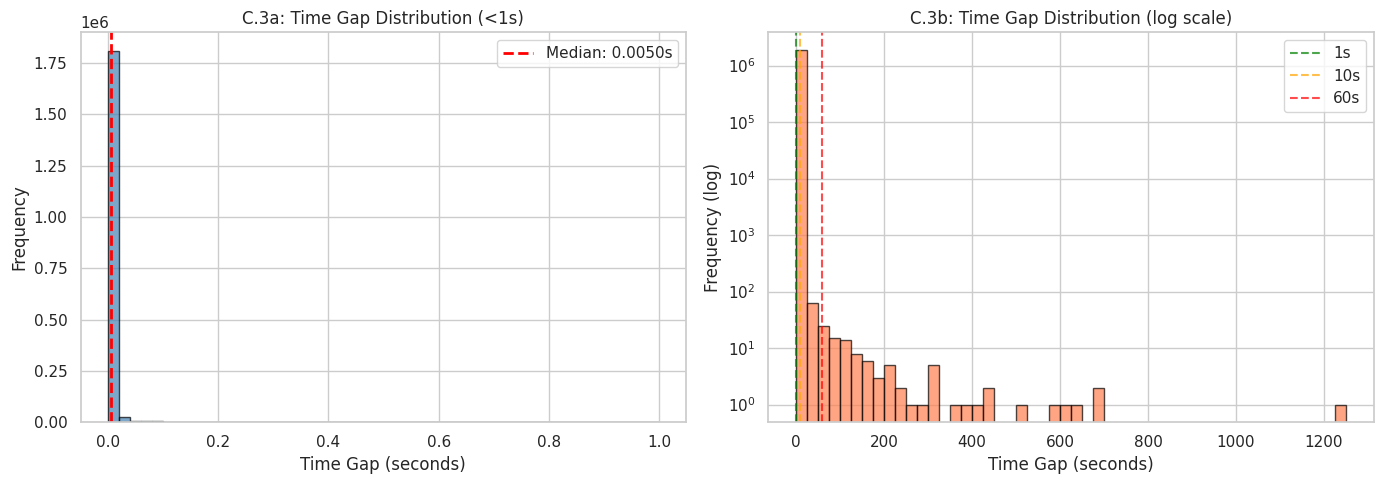

In [59]:
# =============================================================================
# CELL 15: C.3 - Time Gap Analysis
# =============================================================================
# Calculate time gaps between consecutive measurements
df_sorted = df_final.sort_values('datetime').copy()
df_sorted['time_diff'] = df_sorted['datetime'].diff().dt.total_seconds()
gaps = df_sorted['time_diff'].dropna()

# Filter reasonable gaps (< 1 hour)
gaps_filtered = gaps[gaps < 3600]

params = {
    "total_gaps": int(len(gaps)),
    "mean_gap_sec": round(gaps_filtered.mean(), 4),
    "median_gap_sec": round(gaps_filtered.median(), 4),
    "std_gap_sec": round(gaps_filtered.std(), 4),
    "max_gap_sec": round(gaps_filtered.max(), 2),
    "min_gap_sec": round(gaps_filtered.min(), 4),
}

# Count gaps by duration
gap_ranges = {
    "instant (<0.1s)": int((gaps_filtered < 0.1).sum()),
    "fast (0.1-1s)": int(((gaps_filtered >= 0.1) & (gaps_filtered < 1)).sum()),
    "normal (1-10s)": int(((gaps_filtered >= 1) & (gaps_filtered < 10)).sum()),
    "slow (10-60s)": int(((gaps_filtered >= 10) & (gaps_filtered < 60)).sum()),
    "very_slow (>60s)": int((gaps_filtered >= 60).sum()),
}

data_notes = {
    "gap_ranges": gap_ranges,
    "percentiles": {
        "50%": round(gaps_filtered.quantile(0.50), 4),
        "90%": round(gaps_filtered.quantile(0.90), 4),
        "95%": round(gaps_filtered.quantile(0.95), 4),
        "99%": round(gaps_filtered.quantile(0.99), 4),
    },
    "large_gaps_count": int((gaps > 60).sum()),
}

# Print data
print("="*60)
print("[DATA FOR PLOT] Time Gap Analysis")
print("="*60)
print(f"Total gaps: {params['total_gaps']:,}")
print(f"Mean gap: {params['mean_gap_sec']:.4f} sec")
print(f"Median gap: {params['median_gap_sec']:.4f} sec")
print(f"Std gap: {params['std_gap_sec']:.4f} sec")
print(f"Range: [{params['min_gap_sec']:.4f}, {params['max_gap_sec']:.2f}] sec")
print(f"\nGap distribution:")
for rng, cnt in gap_ranges.items():
    print(f"  {rng}: {cnt:,} ({cnt/len(gaps_filtered)*100:.2f}%)")
print(f"\nPercentiles:")
for p, v in data_notes['percentiles'].items():
    print(f"  {p}: {v:.4f} sec")
print(f"\nLarge gaps (>60s): {data_notes['large_gaps_count']}")
print("="*60)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of gaps < 1 second
ax1 = axes[0]
gaps_small = gaps_filtered[gaps_filtered < 1]
ax1.hist(gaps_small, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax1.axvline(gaps_small.median(), color='red', linestyle='--', linewidth=2, label=f'Median: {gaps_small.median():.4f}s')
ax1.set_xlabel("Time Gap (seconds)")
ax1.set_ylabel("Frequency")
ax1.set_title("C.3a: Time Gap Distribution (<1s)")
ax1.legend()

# Log histogram of all gaps
ax2 = axes[1]
ax2.hist(gaps_filtered, bins=50, color='coral', edgecolor='black', alpha=0.7, log=True)
ax2.axvline(1, color='green', linestyle='--', alpha=0.7, label='1s')
ax2.axvline(10, color='orange', linestyle='--', alpha=0.7, label='10s')
ax2.axvline(60, color='red', linestyle='--', alpha=0.7, label='60s')
ax2.set_xlabel("Time Gap (seconds)")
ax2.set_ylabel("Frequency (log)")
ax2.set_title("C.3b: Time Gap Distribution (log scale)")
ax2.legend()

plt.tight_layout()
log_plot(
    name="C.3 Time Gap Analysis",
    description="Phân tích khoảng cách thời gian giữa các lần đo liên tiếp",
    params=params,
    data_notes=data_notes
)
plt.show()


# ⏰ SECTION D: TEMPORAL PATTERNS
---
Phân tích mẫu dữ liệu theo thời gian (hourly, daily).

**Key Questions:**
- Dữ liệu có được thu thập đều theo ngày/giờ không?
- Có pattern rõ ràng về thời gian thu thập?


[DATA FOR PLOT] Temporal Distribution
Date range: 3 days
Unique days: 4
Peak hour: 16:00 (703,726 samples)
Low hour: 13:00 (2,832 samples)

Hourly distribution:
  00:00 |  0
  01:00 |  0
  02:00 |  0
  03:00 |  0
  04:00 |  0
  05:00 |  0
  06:00 |  0
  07:00 |  0
  08:00 |  0
  09:00 |  0
  10:00 | ██████ 158,683
  11:00 | ████ 105,088
  12:00 | ██ 68,379
  13:00 |  2,832
  14:00 | ████████████ 287,932
  15:00 | ████████████████ 389,315
  16:00 | ██████████████████████████████ 703,726
  17:00 | ███████ 172,064
  18:00 |  0
  19:00 |  0
  20:00 |  0
  21:00 |  0
  22:00 |  0
  23:00 |  0

Daily distribution:
  2023-04-10: 797,552
  2023-04-11: 674,428
  2023-04-12: 346,866
  2023-04-13: 69,173
[PLOT] D.1 Temporal Distribution
Description: Phân bố mẫu theo giờ và ngày trong tuần
Params: {
  "date_range_days": 3,
  "unique_days": 4,
  "peak_hour": 16,
  "peak_hour_count": 703726,
  "low_hour": 13,
  "low_hour_count": 2832,
  "hourly_std": 225083.42
}
Data Notes: {
  "hourly_distribution"

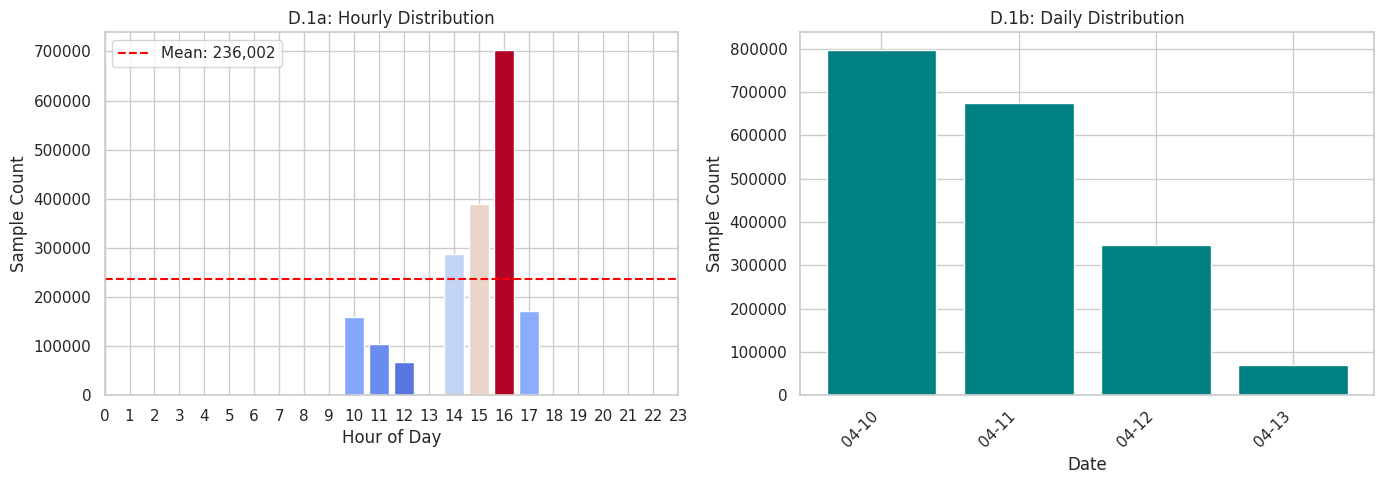

In [60]:
# =============================================================================
# CELL 17: D.1 - Temporal Distribution (Hourly & Daily)
# =============================================================================
df_temp = df_final.copy()
df_temp['hour'] = df_temp['datetime'].dt.hour
df_temp['day'] = df_temp['datetime'].dt.date
df_temp['weekday'] = df_temp['datetime'].dt.day_name()

# Hourly distribution
hourly_counts = df_temp['hour'].value_counts().sort_index()

# Daily distribution
daily_counts = df_temp['day'].value_counts().sort_index()
daily_counts.index = pd.to_datetime(daily_counts.index)

params = {
    "date_range_days": int((df_temp['datetime'].max() - df_temp['datetime'].min()).days) + 1,
    "unique_days": int(df_temp['day'].nunique()),
    "peak_hour": int(hourly_counts.idxmax()),
    "peak_hour_count": int(hourly_counts.max()),
    "low_hour": int(hourly_counts.idxmin()),
    "low_hour_count": int(hourly_counts.min()),
    "hourly_std": round(hourly_counts.std(), 2),
}

data_notes = {
    "hourly_distribution": {int(h): int(c) for h, c in hourly_counts.to_dict().items()},
    "daily_distribution": {str(d.date()): int(c) for d, c in daily_counts.to_dict().items()},
    "active_hours": [int(h) for h in hourly_counts[hourly_counts > hourly_counts.mean()].index.tolist()],
}

# Print data
print("="*60)
print("[DATA FOR PLOT] Temporal Distribution")
print("="*60)
print(f"Date range: {params['date_range_days']} days")
print(f"Unique days: {params['unique_days']}")
print(f"Peak hour: {params['peak_hour']}:00 ({params['peak_hour_count']:,} samples)")
print(f"Low hour: {params['low_hour']}:00 ({params['low_hour_count']:,} samples)")
print(f"\nHourly distribution:")
for h in range(24):
    cnt = hourly_counts.get(h, 0)
    bar = '█' * int(cnt / hourly_counts.max() * 30)
    print(f"  {h:02d}:00 | {bar} {cnt:,}")
print(f"\nDaily distribution:")
for d, c in daily_counts.items():
    print(f"  {d.date()}: {c:,}")
print("="*60)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Hourly
ax1 = axes[0]
colors = plt.cm.coolwarm(hourly_counts.values / hourly_counts.max())
ax1.bar(hourly_counts.index, hourly_counts.values, color=colors)
ax1.axhline(hourly_counts.mean(), color='red', linestyle='--', label=f'Mean: {hourly_counts.mean():,.0f}')
ax1.set_xlabel("Hour of Day")
ax1.set_ylabel("Sample Count")
ax1.set_title("D.1a: Hourly Distribution")
ax1.set_xticks(range(24))
ax1.legend()

# Daily
ax2 = axes[1]
ax2.bar(range(len(daily_counts)), daily_counts.values, color='teal')
ax2.set_xticks(range(len(daily_counts)))
ax2.set_xticklabels([d.strftime('%m-%d') for d in daily_counts.index], rotation=45, ha='right')
ax2.set_xlabel("Date")
ax2.set_ylabel("Sample Count")
ax2.set_title("D.1b: Daily Distribution")

plt.tight_layout()
log_plot(
    name="D.1 Temporal Distribution",
    description="Phân bố mẫu theo giờ và ngày trong tuần",
    params=params,
    data_notes=data_notes
)
plt.show()


# 🗺️ SECTION E: SPATIAL FINGERPRINT ANALYSIS
---
Phân tích dấu vân tay không gian (RSSI patterns) theo location.

**Key Concepts:**
- Mean RSSI Fingerprint: Vân tay RSSI trung bình cho mỗi location
- RSSI Std Fingerprint: Độ biến động RSSI tại mỗi location
- Location Separability: Khả năng phân biệt các location dựa trên RSSI


[DATA FOR PLOT] E.1 Mean RSSI Fingerprint

>>> STATISTICS:
  Matrix: 44 locations x 25 beacons
  Global mean RSSI: -93.56 dBm
  Global std RSSI: 2.28 dBm
  NaN pairs: 413 (37.55%)

>>> MEAN RSSI BY BEACON (across all locations):
--------------------------------------------------
  Beacon  1:  -94.20 dBm ██
  Beacon  2:  -93.67 dBm ███
  Beacon  3:  -93.14 dBm ███
  Beacon  4:  -93.49 dBm ███
  Beacon  5:  -93.63 dBm ███
  Beacon  6:  -94.39 dBm ██
  Beacon  7:  -93.91 dBm ███
  Beacon  8:  -92.82 dBm ███
  Beacon  9:  -93.09 dBm ███
  Beacon 10:  -93.11 dBm ███
  Beacon 11:  -93.50 dBm ███
  Beacon 12:  -95.39 dBm ██
  Beacon 13:  -94.27 dBm ██
  Beacon 14:  -92.94 dBm ███
  Beacon 15:  -93.48 dBm ███
  Beacon 16:  -93.82 dBm ███
  Beacon 17:  -93.33 dBm ███
  Beacon 18:  -93.02 dBm ███
  Beacon 19:  -94.28 dBm ██
  Beacon 20:  -92.00 dBm ████
  Beacon 21:  -93.87 dBm ███
  Beacon 22:  -94.01 dBm ██
  Beacon 23:  -93.68 dBm ███
  Beacon 24:  -91.62 dBm ████
  Beacon 25:  -94.37 dBm ██


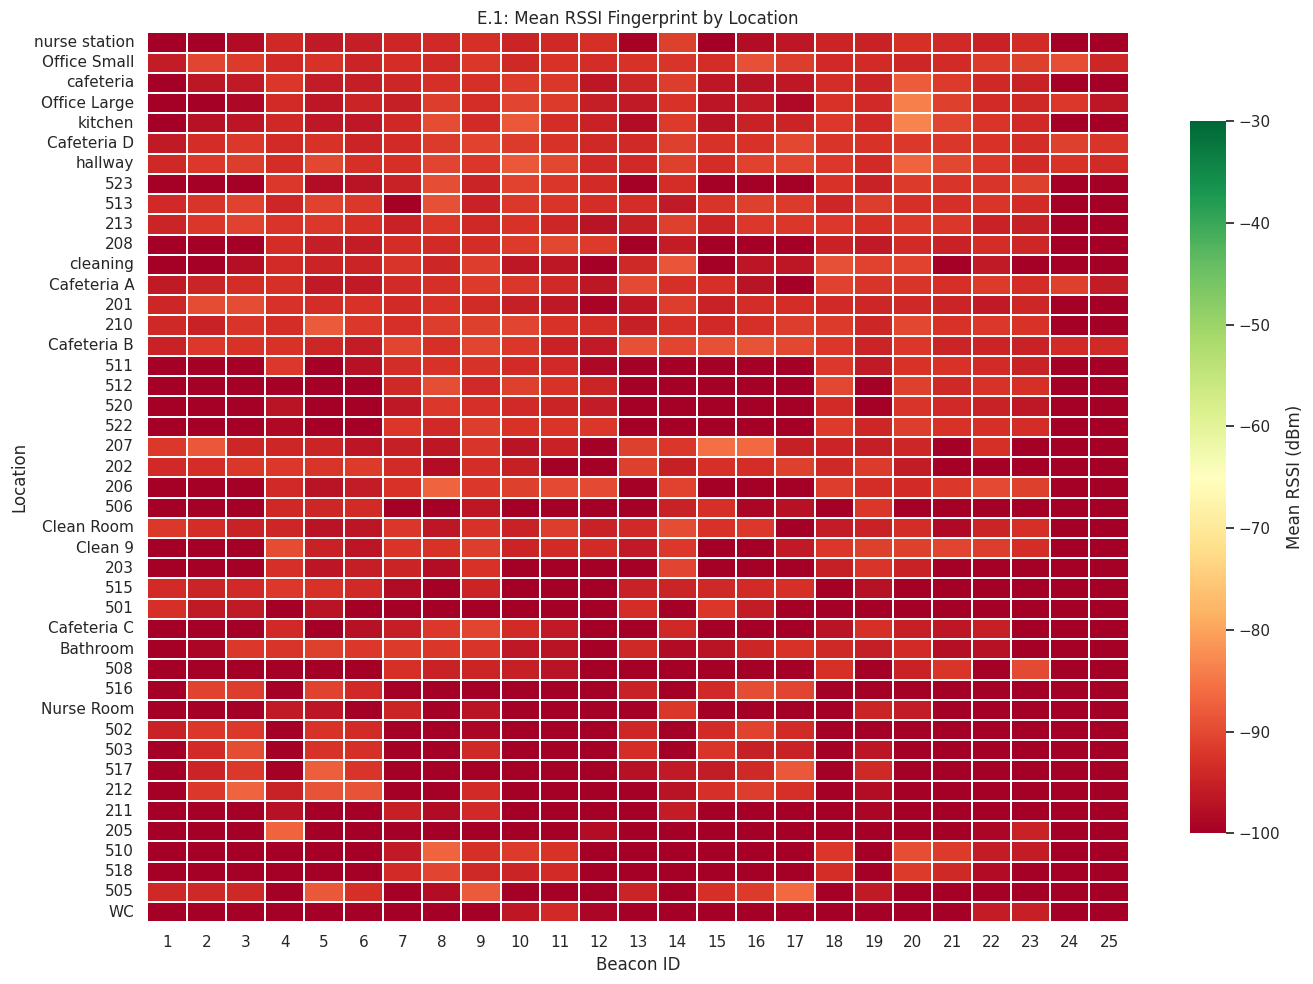

In [61]:
# =============================================================================
# CELL 19: E.1 - Mean RSSI Fingerprint Heatmap
# =============================================================================
# Calculate mean RSSI for each location-beacon pair
rssi_pivot = df_final.pivot_table(index='location', columns='beacon_id', values='RSSI', aggfunc='mean')
rssi_pivot = rssi_pivot[sorted(rssi_pivot.columns, key=lambda x: int(x))]
rssi_pivot = rssi_pivot.loc[loc_counts.index]  # Sort by sample count

# Fill NaN with -100 (no signal)
rssi_pivot_filled = rssi_pivot.fillna(-100)

params = {
    "num_locations": rssi_pivot.shape[0],
    "num_beacons": rssi_pivot.shape[1],
    "global_mean_rssi": round(rssi_pivot.mean().mean(), 2),
    "global_std_rssi": round(rssi_pivot.std().mean(), 2),
    "nan_count": int(rssi_pivot.isna().sum().sum()),
    "nan_pct": round(rssi_pivot.isna().sum().sum() / rssi_pivot.size * 100, 2),
}

data_notes = {
    "strongest_signals": {},
    "weakest_signals": {},
}

# Find strongest signal per location
for loc in rssi_pivot.index[:10]:  # Top 10 locations
    row = rssi_pivot.loc[loc].dropna()
    if len(row) > 0:
        best_beacon = row.idxmax()
        data_notes["strongest_signals"][loc] = {
            "beacon": best_beacon, 
            "rssi": round(row.max(), 2)
        }

# Print ALL data (để AI đọc được chính xác)
print("="*70)
print("[DATA FOR PLOT] E.1 Mean RSSI Fingerprint")
print("="*70)
print(f"\n>>> STATISTICS:")
print(f"  Matrix: {params['num_locations']} locations x {params['num_beacons']} beacons")
print(f"  Global mean RSSI: {params['global_mean_rssi']:.2f} dBm")
print(f"  Global std RSSI: {params['global_std_rssi']:.2f} dBm")
print(f"  NaN pairs: {params['nan_count']} ({params['nan_pct']:.2f}%)")

print(f"\n>>> MEAN RSSI BY BEACON (across all locations):")
print("-"*50)
for bid in sorted(rssi_pivot.columns, key=int):
    mean_val = rssi_pivot[bid].mean()
    bar = '█' * int((mean_val + 100) / 2)  # Scale: -100=0, -50=25
    print(f"  Beacon {bid:>2s}: {mean_val:7.2f} dBm {bar}")
print("-"*50)

print(f"\n>>> RSSI FINGERPRINT MATRIX (top 15 locations x all beacons):")
print("-"*70)
print(f"{'Location':<20s}", end="")
for bid in sorted(rssi_pivot_filled.columns, key=int):
    print(f" B{bid:>2s}", end="")
print()
for loc in rssi_pivot_filled.index[:15]:
    print(f"{loc:<20s}", end="")
    for bid in sorted(rssi_pivot_filled.columns, key=int):
        val = rssi_pivot_filled.loc[loc, bid]
        print(f" {val:4.0f}", end="")
    print()
print("-"*70)

print(f"\n>>> STRONGEST BEACON PER LOCATION (top 15):")
print("-"*50)
for loc in rssi_pivot.index[:15]:
    row = rssi_pivot.loc[loc].dropna()
    if len(row) > 0:
        best_b = row.idxmax()
        best_v = row.max()
        print(f"  {loc:<20s}: Beacon {best_b:>2s} = {best_v:6.2f} dBm")
print("-"*50)
print("="*70)

# Plot
fig, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(rssi_pivot_filled, cmap='RdYlGn', vmin=-100, vmax=-30,
            linewidths=0.3, linecolor='white',
            cbar_kws={'label': 'Mean RSSI (dBm)', 'shrink': 0.8},
            ax=ax)
ax.set_xlabel("Beacon ID")
ax.set_ylabel("Location")
ax.set_title("E.1: Mean RSSI Fingerprint by Location")
plt.tight_layout()

log_plot(
    name="E.1 Mean RSSI Fingerprint",
    description="Heatmap vân tay RSSI trung bình theo location-beacon",
    params=params,
    data_notes=data_notes
)
plt.show()


# ⚙️ SECTION F: FEATURE ENGINEERING
---
Tạo đặc trưng từ dữ liệu thô bằng Sliding Window.

**Strategy:**
- Window Size: 5 giây (khử nhiễu, giảm sparsity)
- Statistics: Mean, Median, IQR, Count (robust stats)
- Coverage: Binary flag (có/không có tín hiệu)
- Delta: Thay đổi giữa các window


In [62]:
# =============================================================================
# CELL 21: F.1 - Sliding Window Feature Engineering (Optimized)
# =============================================================================
print("Starting Sliding Window Feature Engineering...")
print("Window Size: 5 seconds")

WINDOW_SIZE = '5s'
DEFAULT_RSSI = -110

# Optimized: Process all data at once, then group
df_fe = df_final[['datetime', 'beacon_id', 'RSSI', 'location']].copy()
df_fe = df_fe.set_index('datetime')

# Group by location and resample
windowed_list = []

for loc in tqdm(sorted(df_fe['location'].unique()), desc="Processing Locations"):
    df_loc = df_fe[df_fe['location'] == loc][['beacon_id', 'RSSI']].copy()
    
    # Pivot and resample
    df_pivot = df_loc.pivot_table(index=df_loc.index, columns='beacon_id', values='RSSI', aggfunc='mean')
    df_resampled = df_pivot.resample(WINDOW_SIZE).mean()
    df_resampled = df_resampled.dropna(how='all')
    
    if len(df_resampled) == 0:
        continue
    
    # Ensure all beacons are present
    for b in BEACON_IDS:
        if b not in df_resampled.columns:
            df_resampled[b] = np.nan
    
    # Sort columns
    df_resampled = df_resampled[sorted(df_resampled.columns, key=lambda x: int(x))]
    
    # Fill NaN with default
    df_resampled = df_resampled.fillna(DEFAULT_RSSI)
    
    # Add location
    df_resampled['location'] = loc
    df_resampled = df_resampled.reset_index(drop=True)
    
    windowed_list.append(df_resampled)

df_windowed = pd.concat(windowed_list, ignore_index=True)

# Reorder columns
feature_cols = sorted([c for c in df_windowed.columns if c != 'location'], key=lambda x: int(x))
df_windowed = df_windowed[feature_cols + ['location']]

params = {
    "original_samples": int(len(df_final)),
    "windowed_samples": int(len(df_windowed)),
    "compression_ratio": round(len(df_final) / len(df_windowed), 2),
    "window_size": WINDOW_SIZE,
    "num_features": len(feature_cols),
    "num_locations": int(df_windowed['location'].nunique()),
    "nan_count": int(df_windowed.isna().sum().sum()),
}

data_notes = {
    "samples_per_location": df_windowed['location'].value_counts().head(10).to_dict(),
    "feature_stats": {
        "mean": round(df_windowed[feature_cols].mean().mean(), 2),
        "std": round(df_windowed[feature_cols].std().mean(), 2),
        "min": round(df_windowed[feature_cols].min().min(), 2),
        "max": round(df_windowed[feature_cols].max().max(), 2),
    }
}

# Print data
print("="*60)
print("[FEATURE ENGINEERING RESULT]")
print("="*60)
print(f"Original samples: {params['original_samples']:,}")
print(f"Windowed samples: {params['windowed_samples']:,}")
print(f"Compression ratio: {params['compression_ratio']:.2f}x")
print(f"Features: {params['num_features']} (beacons)")
print(f"Locations: {params['num_locations']}")
print(f"NaN count: {params['nan_count']}")
print(f"\nFeature statistics:")
print(f"  Mean: {data_notes['feature_stats']['mean']:.2f} dBm")
print(f"  Std: {data_notes['feature_stats']['std']:.2f}")
print(f"  Range: [{data_notes['feature_stats']['min']:.2f}, {data_notes['feature_stats']['max']:.2f}]")
print(f"\nSamples per location (top 10):")
for loc, cnt in list(data_notes['samples_per_location'].items())[:10]:
    print(f"  {loc}: {cnt}")
print("="*60)

log_plot(
    name="F.1 Feature Engineering Summary",
    description="Kết quả tạo đặc trưng với Sliding Window 5s",
    params=params,
    data_notes=data_notes
)

print(f"\nDataFrame shape: {df_windowed.shape}")
display(df_windowed.head())


Starting Sliding Window Feature Engineering...
Window Size: 5 seconds


Processing Locations: 100%|██████████| 44/44 [00:07<00:00,  5.70it/s]

[FEATURE ENGINEERING RESULT]
Original samples: 1,888,019
Windowed samples: 11,543
Compression ratio: 163.56x
Features: 25 (beacons)
Locations: 44
NaN count: 0

Feature statistics:
  Mean: -107.85 dBm
  Std: 4.52
  Range: [-110.00, -76.00]

Samples per location (top 10):
  nurse station: 2125
  Office Small: 1426
  kitchen: 1398
  Cafeteria D: 1304
  cafeteria: 1196
  hallway: 766
  Office Large: 655
  cleaning: 245
  213: 231
  Cafeteria A: 221
[PLOT] F.1 Feature Engineering Summary
Description: Kết quả tạo đặc trưng với Sliding Window 5s
Params: {
  "original_samples": 1888019,
  "windowed_samples": 11543,
  "compression_ratio": 163.56,
  "window_size": "5s",
  "num_features": 25,
  "num_locations": 44,
  "nan_count": 0
}
Data Notes: {
  "samples_per_location": {
    "nurse station": 2125,
    "Office Small": 1426,
    "kitchen": 1398,
    "Cafeteria D": 1304,
    "cafeteria": 1196,
    "hallway": 766,
    "Office Large": 655,
    "cleaning": 245,
    "213": 231,
    "Cafeteria A": 22

beacon_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,location
0,-93.0,-85.000000,-90.0,-110.0,-110.00000,-110.000000,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-86.0,-110.000000,-90.0,-89.125,-110.000000,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,201
1,-110.0,-87.444444,-88.4,-96.0,-91.41791,-92.000000,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-96.0,-110.000000,-96.0,-89.250,-90.941176,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,201
2,-110.0,-100.000000,-93.0,-110.0,-89.94186,-89.666667,-110.0,-110.0,-94.0,-110.0,-110.0,-110.0,-110.0,-110.000000,-110.0,-110.000,-98.000000,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,201
3,-110.0,-110.000000,-110.0,-110.0,-95.50000,-98.000000,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-95.666667,-110.0,-110.000,-110.000000,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,201
4,-110.0,-110.000000,-110.0,-110.0,-96.00000,-95.222222,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-94.000000,-110.0,-110.000,-110.000000,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,-110.0,201


# 📈 SECTION G: FEATURE QUALITY ASSESSMENT
---
Đánh giá chất lượng đặc trưng sau Feature Engineering.

**Analyses:**
- Correlation Matrix: Tương quan giữa các beacon
- Variance Analysis: Phương sai của từng feature
- PCA: Giảm chiều và giải thích phương sai
- t-SNE: Quan sát manifold và khả năng phân tách lớp


[DATA FOR PLOT] G.1 Correlation & Variance Analysis

>>> STATISTICS:
  Features: 25
  Samples: 11543
  Mean correlation: 0.075
  High correlation pairs (>0.8): 0
  Low variance features (<1): 0

>>> VARIANCE BY BEACON (sorted DESC):
--------------------------------------------------
   1. Beacon  9:   74.724 ██████████████████████████████████████████████████████████████████████████
   2. Beacon 14:   69.499 █████████████████████████████████████████████████████████████████████
   3. Beacon  4:   63.393 ███████████████████████████████████████████████████████████████
   4. Beacon  7:   48.659 ████████████████████████████████████████████████
   5. Beacon 19:   46.777 ██████████████████████████████████████████████
   6. Beacon 18:   41.021 █████████████████████████████████████████
   7. Beacon  8:   37.182 █████████████████████████████████████
   8. Beacon 20:   36.617 ████████████████████████████████████
   9. Beacon  6:   35.838 ███████████████████████████████████
  10. Beacon 10:   23.70

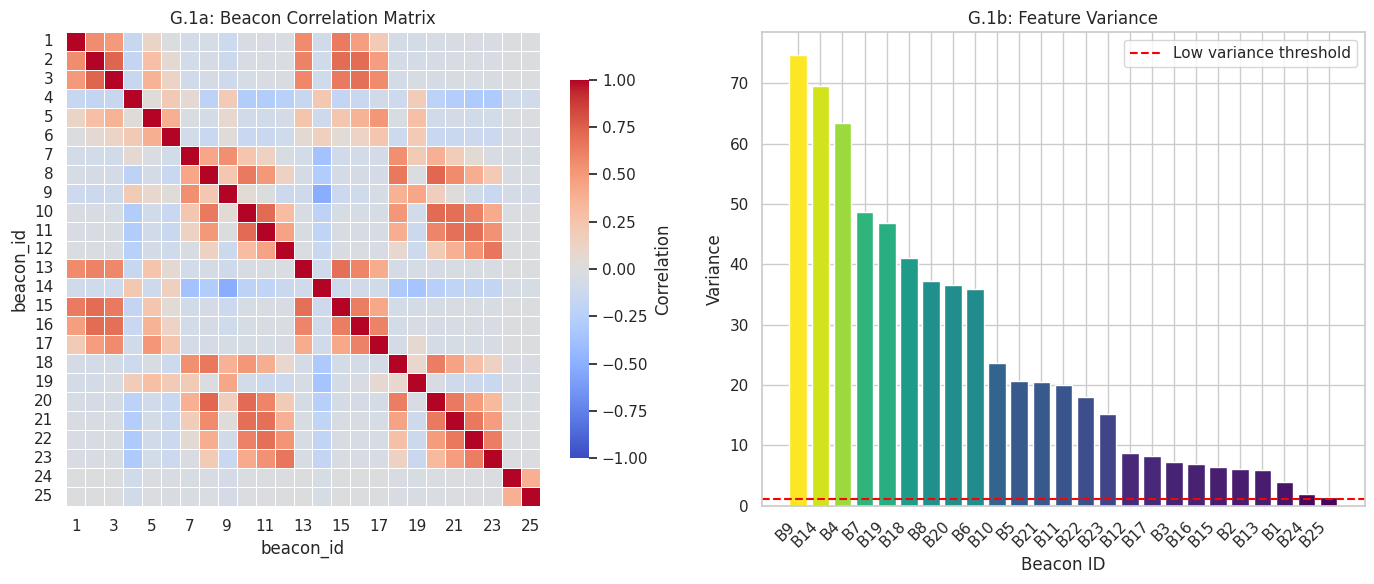

In [63]:
# =============================================================================
# CELL 23: G.1 - Correlation & Variance Analysis
# =============================================================================
from sklearn.preprocessing import StandardScaler

X = df_windowed[feature_cols]
y = df_windowed['location']

# Correlation matrix
corr_matrix = X.corr()

# Find high correlation pairs
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append({
                'beacon1': corr_matrix.columns[i],
                'beacon2': corr_matrix.columns[j],
                'correlation': round(corr_matrix.iloc[i, j], 3)
            })

# Variance analysis
variances = X.var().sort_values(ascending=False)
low_var_features = variances[variances < 1].index.tolist()

params = {
    "num_features": len(feature_cols),
    "num_samples": len(X),
    "high_corr_pairs_count": len(high_corr_pairs),
    "low_var_features_count": len(low_var_features),
    "mean_correlation": round(corr_matrix.values[np.triu_indices_from(corr_matrix.values, 1)].mean(), 3),
    "mean_variance": round(variances.mean(), 3),
}

data_notes = {
    "high_corr_pairs": high_corr_pairs,
    "top5_variance": {k: round(v, 3) for k, v in variances.head(5).to_dict().items()},
    "bottom5_variance": {k: round(v, 3) for k, v in variances.tail(5).to_dict().items()},
    "low_var_features": low_var_features,
}

# Print ALL data (để AI đọc được chính xác)
print("="*70)
print("[DATA FOR PLOT] G.1 Correlation & Variance Analysis")
print("="*70)
print(f"\n>>> STATISTICS:")
print(f"  Features: {params['num_features']}")
print(f"  Samples: {params['num_samples']}")
print(f"  Mean correlation: {params['mean_correlation']:.3f}")
print(f"  High correlation pairs (>0.8): {params['high_corr_pairs_count']}")
print(f"  Low variance features (<1): {params['low_var_features_count']}")

print(f"\n>>> VARIANCE BY BEACON (sorted DESC):")
print("-"*50)
for i, (bid, var) in enumerate(variances.items(), 1):
    bar = '█' * int(var)
    flag = " [LOW]" if var < 1 else ""
    print(f"  {i:2d}. Beacon {bid:>2s}: {var:8.3f}{flag} {bar}")
print("-"*50)

if high_corr_pairs:
    print(f"\n>>> HIGH CORRELATION PAIRS (>{0.8}):")
    print("-"*50)
    for pair in high_corr_pairs:
        print(f"  Beacon {pair['beacon1']:>2s} <-> Beacon {pair['beacon2']:>2s}: r = {pair['correlation']:.3f}")
    print("-"*50)

print(f"\n>>> CORRELATION MATRIX (25x25):")
print("-"*70)
print(f"     ", end="")
for bid in corr_matrix.columns:
    print(f" B{bid:>2s}", end="")
print()
for bid_row in corr_matrix.index:
    print(f"B{bid_row:>2s}: ", end="")
    for bid_col in corr_matrix.columns:
        val = corr_matrix.loc[bid_row, bid_col]
        print(f" {val:4.2f}"[:5], end="")
    print()
print("-"*70)
print("="*70)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Correlation heatmap
ax1 = axes[0]
sns.heatmap(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1, center=0,
            square=True, linewidths=0.5, 
            cbar_kws={'shrink': 0.8, 'label': 'Correlation'},
            ax=ax1)
ax1.set_title("G.1a: Beacon Correlation Matrix")

# Variance bar
ax2 = axes[1]
colors = plt.cm.viridis(variances.values / variances.max())
ax2.bar(range(len(variances)), variances.values, color=colors)
ax2.axhline(1, color='red', linestyle='--', label='Low variance threshold')
ax2.set_xticks(range(len(variances)))
ax2.set_xticklabels([f"B{i}" for i in variances.index], rotation=45, ha='right')
ax2.set_xlabel("Beacon ID")
ax2.set_ylabel("Variance")
ax2.set_title("G.1b: Feature Variance")
ax2.legend()

plt.tight_layout()
log_plot(
    name="G.1 Correlation & Variance",
    description="Ma trận tương quan và phân tích phương sai các features",
    params=params,
    data_notes=data_notes
)
plt.show()


[DATA FOR PLOT] G.2 PCA Analysis

>>> STATISTICS:
  Total components: 25
  PC1 variance: 22.44%
  PC2 variance: 18.43%
  PC1+PC2 total: 40.88%
  Components for 70% var: 7
  Components for 80% var: 10
  Components for 90% var: 17

>>> EXPLAINED VARIANCE (ALL 25 COMPONENTS):
------------------------------------------------------------
  PC 1:  22.44% (cumulative:  22.44%) ███████████
  PC 2:  18.43% (cumulative:  40.88%) █████████
  PC 3:  10.84% (cumulative:  51.71%) █████
  PC 4:   6.41% (cumulative:  58.12%) ███
  PC 5:   5.70% (cumulative:  63.83%) ██
  PC 6:   5.02% (cumulative:  68.85%) ██
  PC 7:   3.32% (cumulative:  72.17%) █
  PC 8:   2.86% (cumulative:  75.04%) █
  PC 9:   2.49% (cumulative:  77.53%) █
  PC10:   2.48% (cumulative:  80.00%) █
  PC11:   1.93% (cumulative:  81.94%) 
  PC12:   1.78% (cumulative:  83.72%) 
  PC13:   1.67% (cumulative:  85.39%) 
  PC14:   1.58% (cumulative:  86.97%) 
  PC15:   1.44% (cumulative:  88.41%) 
  PC16:   1.37% (cumulative:  89.77%) 
  PC1

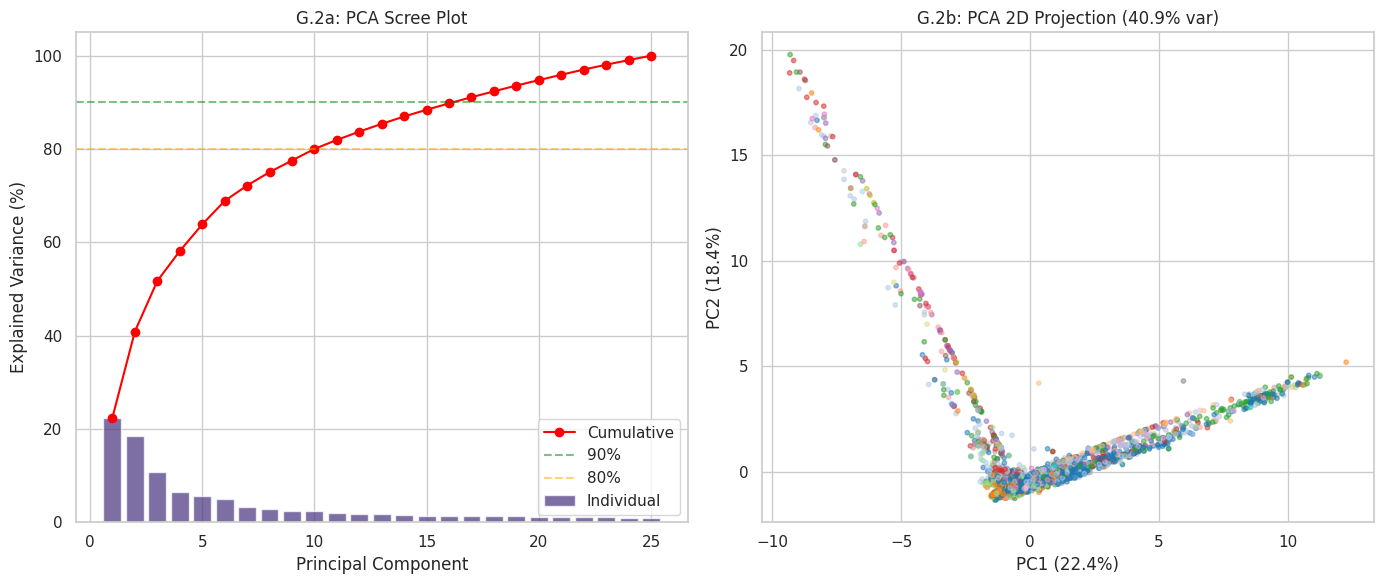

In [64]:
# =============================================================================
# CELL 24: G.2 - PCA Analysis
# =============================================================================
from sklearn.decomposition import PCA

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA with all components
pca_full = PCA()
pca_full.fit(X_scaled)

# Explained variance
explained_var = pca_full.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

# Find number of components for 90% variance
n_components_90 = np.argmax(cumulative_var >= 0.90) + 1

# PCA with 2 components for visualization
pca_2d = PCA(n_components=2)
X_pca = pca_2d.fit_transform(X_scaled)

params = {
    "total_components": len(explained_var),
    "pc1_variance": round(explained_var[0] * 100, 2),
    "pc2_variance": round(explained_var[1] * 100, 2),
    "pc1_pc2_total": round((explained_var[0] + explained_var[1]) * 100, 2),
    "components_for_90pct": int(n_components_90),
    "components_for_80pct": int(np.argmax(cumulative_var >= 0.80) + 1),
    "components_for_70pct": int(np.argmax(cumulative_var >= 0.70) + 1),
}

data_notes = {
    "explained_variance": {f"PC{i+1}": round(v*100, 2) for i, v in enumerate(explained_var[:10])},
    "cumulative_variance": {f"PC{i+1}": round(v*100, 2) for i, v in enumerate(cumulative_var[:10])},
    "top_loadings_pc1": {},
    "top_loadings_pc2": {},
}

# Get loadings
loadings = pca_2d.components_
for i, bid in enumerate(feature_cols):
    data_notes["top_loadings_pc1"][f"B{bid}"] = round(loadings[0, i], 3)
    data_notes["top_loadings_pc2"][f"B{bid}"] = round(loadings[1, i], 3)

# Print ALL data (để AI đọc được chính xác)
print("="*70)
print("[DATA FOR PLOT] G.2 PCA Analysis")
print("="*70)
print(f"\n>>> STATISTICS:")
print(f"  Total components: {params['total_components']}")
print(f"  PC1 variance: {params['pc1_variance']:.2f}%")
print(f"  PC2 variance: {params['pc2_variance']:.2f}%")
print(f"  PC1+PC2 total: {params['pc1_pc2_total']:.2f}%")
print(f"  Components for 70% var: {params['components_for_70pct']}")
print(f"  Components for 80% var: {params['components_for_80pct']}")
print(f"  Components for 90% var: {params['components_for_90pct']}")

print(f"\n>>> EXPLAINED VARIANCE (ALL {len(explained_var)} COMPONENTS):")
print("-"*60)
for i, (var, cum) in enumerate(zip(explained_var, cumulative_var), 1):
    bar = '█' * int(var * 100 / 2)
    print(f"  PC{i:2d}: {var*100:6.2f}% (cumulative: {cum*100:6.2f}%) {bar}")
print("-"*60)

print(f"\n>>> PC1 LOADINGS (contribution of each beacon):")
print("-"*50)
pc1_loadings = [(bid, loadings[0, i]) for i, bid in enumerate(feature_cols)]
pc1_sorted = sorted(pc1_loadings, key=lambda x: abs(x[1]), reverse=True)
for bid, load in pc1_sorted:
    bar = '█' * int(abs(load) * 20)
    sign = '+' if load > 0 else '-'
    print(f"  Beacon {bid:>2s}: {sign}{abs(load):.3f} {bar}")
print("-"*50)

print(f"\n>>> PC2 LOADINGS (contribution of each beacon):")
print("-"*50)
pc2_loadings = [(bid, loadings[1, i]) for i, bid in enumerate(feature_cols)]
pc2_sorted = sorted(pc2_loadings, key=lambda x: abs(x[1]), reverse=True)
for bid, load in pc2_sorted:
    bar = '█' * int(abs(load) * 20)
    sign = '+' if load > 0 else '-'
    print(f"  Beacon {bid:>2s}: {sign}{abs(load):.3f} {bar}")
print("-"*50)
print("="*70)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Scree plot
ax1 = axes[0]
ax1.bar(range(1, len(explained_var)+1), explained_var * 100, alpha=0.7, label='Individual')
ax1.plot(range(1, len(cumulative_var)+1), cumulative_var * 100, 'ro-', label='Cumulative')
ax1.axhline(90, color='green', linestyle='--', alpha=0.5, label='90%')
ax1.axhline(80, color='orange', linestyle='--', alpha=0.5, label='80%')
ax1.set_xlabel("Principal Component")
ax1.set_ylabel("Explained Variance (%)")
ax1.set_title("G.2a: PCA Scree Plot")
ax1.legend()

# 2D scatter
ax2 = axes[1]
# Sample for visualization if too many points
if len(X_pca) > 5000:
    idx = np.random.choice(len(X_pca), 5000, replace=False)
    X_plot = X_pca[idx]
    y_plot = y.iloc[idx]
else:
    X_plot = X_pca
    y_plot = y

scatter = ax2.scatter(X_plot[:, 0], X_plot[:, 1], c=pd.factorize(y_plot)[0], 
                       cmap='tab20', s=10, alpha=0.5)
ax2.set_xlabel(f"PC1 ({params['pc1_variance']:.1f}%)")
ax2.set_ylabel(f"PC2 ({params['pc2_variance']:.1f}%)")
ax2.set_title(f"G.2b: PCA 2D Projection ({params['pc1_pc2_total']:.1f}% var)")

plt.tight_layout()
log_plot(
    name="G.2 PCA Analysis",
    description="Phân tích thành phần chính (PCA) và giảm chiều",
    params=params,
    data_notes=data_notes
)
plt.show()


Running t-SNE (this may take a few minutes)...
Sampled 5000 points from 11543
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.000s...
[t-SNE] Computed neighbors for 5000 samples in 0.144s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.130938
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.760479
[t-SNE] KL divergence after 1000 iterations: 0.522634
[DATA FOR PLOT] t-SNE Visualization
Samples: 5000
Locations: 43
Perplexity: 30
X range: [-80.87000274658203, 72.66999816894531]
Y range: [-78.0199966430664, 75.58999633789062]

Tightest clusters (low spread = good separability):
  212: 6.66
  505: 6.91
  515: 7.02
  501: 9.12
  517: 10.05


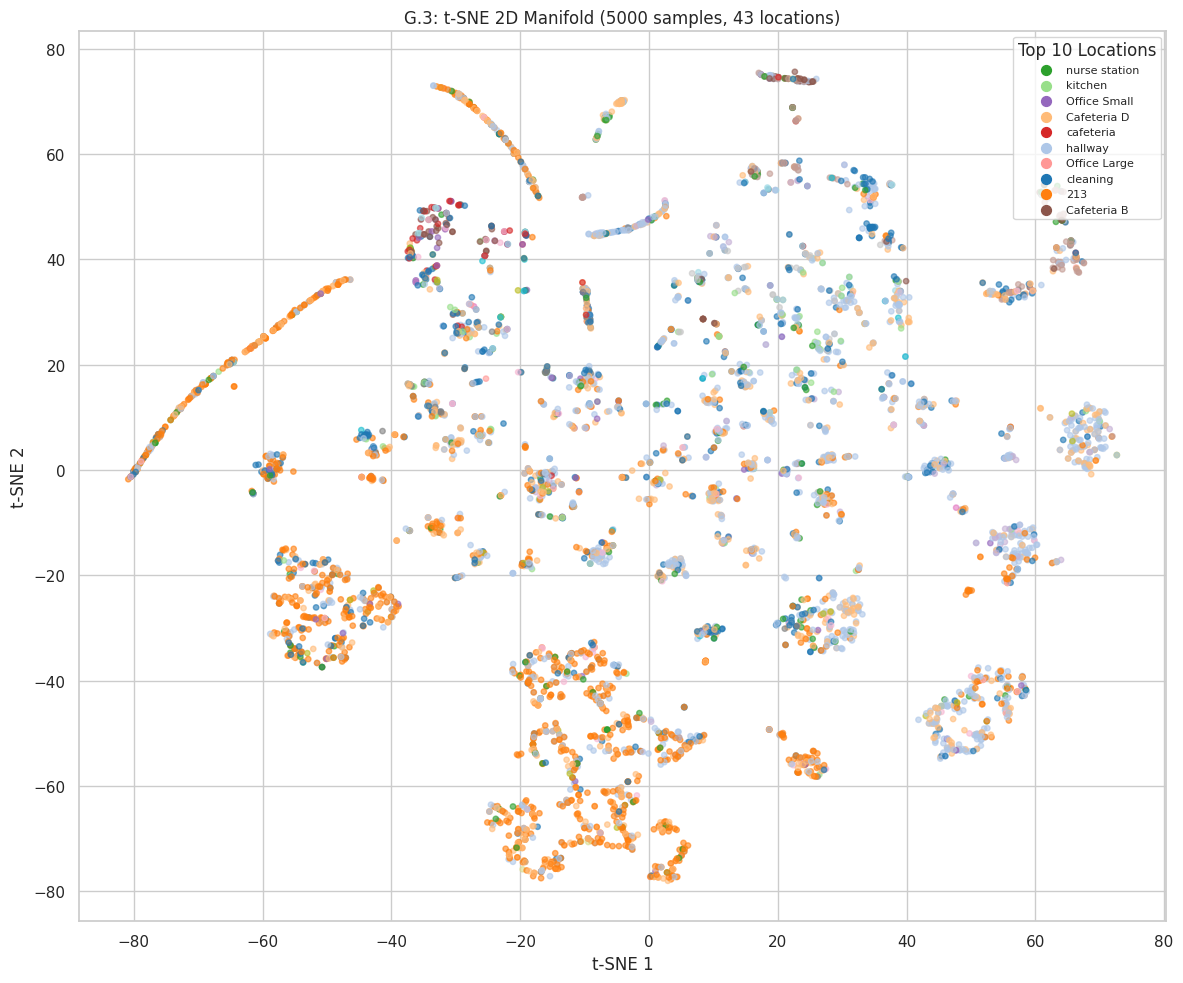

In [65]:
# =============================================================================
# CELL 25: G.3 - t-SNE Visualization
# =============================================================================
from sklearn.manifold import TSNE

print("Running t-SNE (this may take a few minutes)...")

# Sample if too many points
MAX_SAMPLES = 5000
if len(X_scaled) > MAX_SAMPLES:
    idx = np.random.choice(len(X_scaled), MAX_SAMPLES, replace=False)
    X_tsne_input = X_scaled[idx]
    y_tsne = y.iloc[idx].reset_index(drop=True)
    print(f"Sampled {MAX_SAMPLES} points from {len(X_scaled)}")
else:
    X_tsne_input = X_scaled
    y_tsne = y.reset_index(drop=True)

# Run t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_jobs=-1, verbose=1)
X_tsne = tsne.fit_transform(X_tsne_input)

params = {
    "n_samples": len(X_tsne_input),
    "perplexity": 30,
    "n_locations": int(y_tsne.nunique()),
    "x_range": [float(round(X_tsne[:, 0].min(), 2)), float(round(X_tsne[:, 0].max(), 2))],
    "y_range": [float(round(X_tsne[:, 1].min(), 2)), float(round(X_tsne[:, 1].max(), 2))],
}

# Calculate cluster density (rough measure)
from scipy.spatial.distance import pdist
location_spread = {}
for loc in y_tsne.unique():
    mask = y_tsne == loc
    if mask.sum() > 1:
        points = X_tsne[mask]
        if len(points) > 1:
            distances = pdist(points)
            location_spread[loc] = float(round(distances.mean(), 2))

data_notes = {
    "samples_per_location": {str(k): int(v) for k, v in y_tsne.value_counts().head(10).to_dict().items()},
    "location_spread_top5": dict(sorted(location_spread.items(), key=lambda x: x[1])[:5]),
    "location_spread_bottom5": dict(sorted(location_spread.items(), key=lambda x: x[1], reverse=True)[:5]),
}

# Print data
print("="*60)
print("[DATA FOR PLOT] t-SNE Visualization")
print("="*60)
print(f"Samples: {params['n_samples']}")
print(f"Locations: {params['n_locations']}")
print(f"Perplexity: {params['perplexity']}")
print(f"X range: {params['x_range']}")
print(f"Y range: {params['y_range']}")
print(f"\nTightest clusters (low spread = good separability):")
for loc, spread in data_notes['location_spread_top5'].items():
    print(f"  {loc}: {spread:.2f}")
print(f"\nLoosest clusters (high spread = poor separability):")
for loc, spread in data_notes['location_spread_bottom5'].items():
    print(f"  {loc}: {spread:.2f}")
print("="*60)

# Plot
fig, ax = plt.subplots(figsize=(12, 10))
scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=pd.factorize(y_tsne)[0], 
                      cmap='tab20', s=15, alpha=0.6)
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.set_title(f"G.3: t-SNE 2D Manifold ({params['n_samples']} samples, {params['n_locations']} locations)")

# Add legend for top locations
handles = []
labels = []
unique_locs = y_tsne.value_counts().head(10).index
colors = plt.cm.tab20(np.linspace(0, 1, 20))
loc_to_color = {loc: i for i, loc in enumerate(y_tsne.unique())}
for loc in unique_locs:
    idx = loc_to_color.get(loc, 0)
    handles.append(plt.scatter([], [], c=[colors[idx % 20]], s=50))
    labels.append(loc)
ax.legend(handles, labels, loc='upper right', fontsize=8, title="Top 10 Locations")

plt.tight_layout()
log_plot(
    name="G.3 t-SNE Visualization",
    description="Biểu đồ t-SNE 2D để quan sát manifold và khả năng phân tách lớp",
    params=params,
    data_notes=data_notes
)
plt.show()


# 📝 SUMMARY & EXPORT
---
Tổng hợp kết quả EDA và xuất dữ liệu.


In [66]:
# =============================================================================
# CELL 27: FINAL SUMMARY & EXPORT
# =============================================================================

# Compile EDA summary
eda_summary = {
    "dataset": {
        "total_raw_samples": int(len(df_final)),
        "total_windowed_samples": int(len(df_windowed)),
        "num_locations": int(df_final['location'].nunique()),
        "num_beacons": 25,
        "num_users": int(df_final['label_user_id'].nunique()),
        "time_range_days": int((df_final['datetime'].max() - df_final['datetime'].min()).days) + 1,
    },
    "class_imbalance": {
        "gini_coefficient": round(gini, 4),
        "imbalance_ratio": round(imbalance_ratio, 2),
        "top_location": loc_counts.idxmax(),
        "top_location_pct": round(loc_counts.max() / loc_counts.sum() * 100, 2),
        "bottom_location": loc_counts.idxmin(),
        "bottom_location_count": int(loc_counts.min()),
    },
    "signal_quality": {
        "mean_rssi": round(df_final['RSSI'].mean(), 2),
        "std_rssi": round(df_final['RSSI'].std(), 2),
        "mean_snr": round(df_snr['snr'].mean(), 2),
        "weak_signal_pct": round((df_final['RSSI'] <= -95).sum() / len(df_final) * 100, 2),
    },
    "beacon_coverage": {
        "mean_coverage_pct": round(coverage_pivot.mean().mean(), 2),
        "zero_coverage_pairs": int((coverage_pivot == 0).sum().sum()),
        "best_beacon": df_reliability.iloc[0]['beacon_id'],
        "worst_beacon": df_reliability.iloc[-1]['beacon_id'],
    },
    "feature_quality": {
        "pca_pc1_pc2_variance": round((explained_var[0] + explained_var[1]) * 100, 2),
        "components_for_90pct": int(n_components_90),
        "high_corr_pairs": len(high_corr_pairs),
        "low_var_features": len(low_var_features),
    },
    "recommendations": [
        "1. Apply class balancing (SMOTE/Class Weights) - Gini=0.78 is severe",
        "2. Use robust features (median, IQR) to handle RSSI noise",
        "3. Consider dropping low-reliability beacons or using coverage flags",
        "4. Apply sliding window aggregation to reduce sparsity",
        "5. Use time-based train/val split to avoid data leakage",
    ]
}

# Print summary
print("="*70)
print(" " * 20 + "EDA FINAL SUMMARY")
print("="*70)
print(json.dumps(eda_summary, indent=2, ensure_ascii=False))
print("="*70)

# Save summary
summary_path = os.path.join(OUTPUT_PATH, "eda_summary_v2.json")
with open(summary_path, "w", encoding="utf-8") as f:
    json.dump(eda_summary, f, indent=2, ensure_ascii=False)
print(f"\n[SAVED] EDA Summary: {summary_path}")

# Save windowed features
features_csv = os.path.join(OUTPUT_PATH, "df_windowed_v2.csv")
features_parquet = os.path.join(OUTPUT_PATH, "df_windowed_v2.parquet")
df_windowed.to_csv(features_csv, index=False)
df_windowed.to_parquet(features_parquet, index=False)
print(f"[SAVED] Features CSV: {features_csv}")
print(f"[SAVED] Features Parquet: {features_parquet}")

# Save plot metadata
print(f"[SAVED] Plot Metadata: {PLOT_META_PATH}")
print(f"\nTotal plots logged: {len(PLOT_REGISTRY)}")

print("\n" + "="*70)
print("EDA COMPLETE! Ready for modeling phase.")
print("="*70)


                    EDA FINAL SUMMARY
{
  "dataset": {
    "total_raw_samples": 1888019,
    "total_windowed_samples": 11543,
    "num_locations": 44,
    "num_beacons": 25,
    "num_users": 2,
    "time_range_days": 3
  },
  "class_imbalance": {
    "gini_coefficient": 0.7832,
    "imbalance_ratio": 2301.51,
    "top_location": "nurse station",
    "top_location_pct": 28.52,
    "bottom_location": "WC",
    "bottom_location_count": 234
  },
  "signal_quality": {
    "mean_rssi": -93.0,
    "std_rssi": 4.23,
    "mean_snr": 22.42,
    "weak_signal_pct": 40.41
  },
  "beacon_coverage": {
    "mean_coverage_pct": 4.0,
    "zero_coverage_pairs": 413,
    "best_beacon": "4",
    "worst_beacon": "25"
  },
  "feature_quality": {
    "pca_pc1_pc2_variance": 40.88,
    "components_for_90pct": 17,
    "high_corr_pairs": 0,
    "low_var_features": 0
  },
  "recommendations": [
    "1. Apply class balancing (SMOTE/Class Weights) - Gini=0.78 is severe",
    "2. Use robust features (median, IQR) to

# 🔀 SECTION H: DATA SPLIT STRATEGY
---
Phân tích và lựa chọn chiến lược chia dữ liệu cho training/validation.

**Mục tiêu:**
- Phân tích temporal patterns (có drift theo thời gian không?)
- Phân tích user patterns (user 91 vs 97 khác nhau không?)
- Chọn split strategy phù hợp nhất
- Implement StratifiedKFold với 5 folds


H.2: TEMPORAL ANALYSIS

>>> DATE DISTRIBUTION:
------------------------------------------------------------
  2023-04-10: 797,552 samples, 15 locations, 2 users
  2023-04-11: 674,428 samples, 36 locations, 2 users
  2023-04-12: 346,866 samples, 36 locations, 2 users
  2023-04-13: 69,173 samples, 27 locations, 2 users
------------------------------------------------------------

>>> DATE SIMILARITY MATRIX (Cosine):
  (Higher = more similar distribution)
------------------------------------------------------------
                  04-10      04-11      04-12      04-13
  2023-04-10     1.0000     0.6417     0.4781     0.6306
  2023-04-11     0.6417     1.0000     0.8612     0.8065
  2023-04-12     0.4781     0.8612     1.0000     0.7781
  2023-04-13     0.6306     0.8065     0.7781     1.0000
------------------------------------------------------------

>>> TEMPORAL DRIFT ASSESSMENT:
  Average inter-day similarity: 0.6994
  Verdict: HIGH temporal drift - Time-based split recommended
[PL

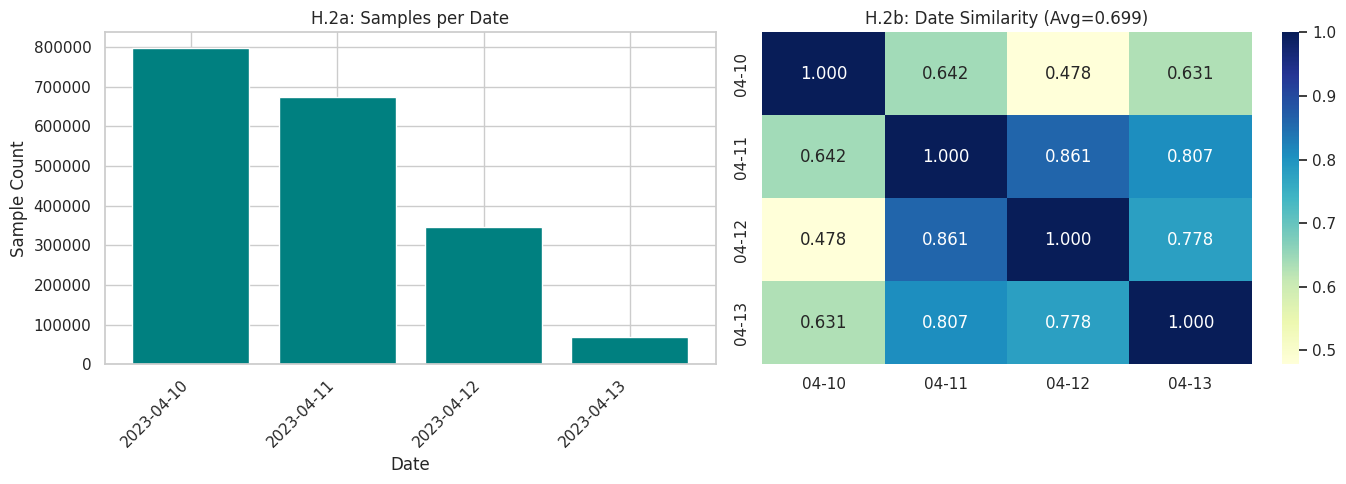

In [67]:
# =============================================================================
# CELL H.2: TEMPORAL ANALYSIS - Data Distribution by Date
# =============================================================================
print("="*70)
print("H.2: TEMPORAL ANALYSIS")
print("="*70)

# Load windowed data if not already in memory
if 'df_windowed' not in dir():
    import pandas as pd
    features_parquet = os.path.join(OUTPUT_PATH, "df_windowed_v2.parquet")
    df_windowed = pd.read_parquet(features_parquet)
    print(f"Loaded df_windowed from {features_parquet}")

# We need datetime info - reload from raw data
df_temp_analysis = df_final.copy()
df_temp_analysis['date'] = df_temp_analysis['datetime'].dt.date
df_temp_analysis['hour'] = df_temp_analysis['datetime'].dt.hour

# Samples per date
date_dist = df_temp_analysis.groupby('date').agg({
    'location': ['count', 'nunique'],
    'label_user_id': 'nunique'
}).reset_index()
date_dist.columns = ['date', 'samples', 'unique_locations', 'unique_users']

# Location distribution per date
loc_by_date = df_temp_analysis.groupby(['date', 'location']).size().unstack(fill_value=0)

# Calculate Cosine similarity between days (to detect drift)
from sklearn.metrics.pairwise import cosine_similarity
date_vectors = loc_by_date.T  # locations x dates
date_sim = cosine_similarity(date_vectors.T)
date_labels = [str(d) for d in loc_by_date.index]

print("\n>>> DATE DISTRIBUTION:")
print("-"*60)
for _, row in date_dist.iterrows():
    print(f"  {row['date']}: {row['samples']:,} samples, {row['unique_locations']} locations, {row['unique_users']} users")
print("-"*60)

print("\n>>> DATE SIMILARITY MATRIX (Cosine):")
print("  (Higher = more similar distribution)")
print("-"*60)
print(f"{'':>12}", end="")
for d in date_labels:
    print(f" {d[-5:]:>10}", end="")
print()
for i, d1 in enumerate(date_labels):
    print(f"{d1[-10:]:>12}", end="")
    for j, d2 in enumerate(date_labels):
        sim = date_sim[i, j]
        print(f" {sim:>10.4f}", end="")
    print()
print("-"*60)

# Average inter-day similarity (excluding diagonal)
mask = ~np.eye(len(date_sim), dtype=bool)
avg_similarity = date_sim[mask].mean()
print(f"\n>>> TEMPORAL DRIFT ASSESSMENT:")
print(f"  Average inter-day similarity: {avg_similarity:.4f}")
if avg_similarity > 0.95:
    print("  Verdict: LOW temporal drift - Random split is acceptable")
elif avg_similarity > 0.85:
    print("  Verdict: MODERATE temporal drift - Consider time-based split")
else:
    print("  Verdict: HIGH temporal drift - Time-based split recommended")

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
ax1.bar(range(len(date_dist)), date_dist['samples'], color='teal')
ax1.set_xticks(range(len(date_dist)))
ax1.set_xticklabels(date_dist['date'].astype(str), rotation=45, ha='right')
ax1.set_xlabel("Date")
ax1.set_ylabel("Sample Count")
ax1.set_title("H.2a: Samples per Date")

ax2 = axes[1]
sns.heatmap(date_sim, annot=True, fmt='.3f', cmap='YlGnBu', 
            xticklabels=[d[-5:] for d in date_labels],
            yticklabels=[d[-5:] for d in date_labels], ax=ax2)
ax2.set_title(f"H.2b: Date Similarity (Avg={avg_similarity:.3f})")

plt.tight_layout()
log_plot(
    name="H.2 Temporal Analysis",
    description="Phân tích phân bố dữ liệu theo ngày và đánh giá temporal drift",
    params={
        "num_dates": len(date_dist),
        "avg_similarity": round(avg_similarity, 4),
        "temporal_drift": "LOW" if avg_similarity > 0.95 else "MODERATE" if avg_similarity > 0.85 else "HIGH"
    },
    data_notes={
        "date_distribution": date_dist.to_dict('records'),
        "similarity_matrix": {date_labels[i]: {date_labels[j]: round(date_sim[i,j], 4) for j in range(len(date_labels))} for i in range(len(date_labels))}
    }
)
plt.show()


H.3: USER BEHAVIOR ANALYSIS

>>> USER DISTRIBUTION:
----------------------------------------------------------------------
  User 91: 770,658 samples, 23 locations
           Time: 2023-04-10 16:16:25.095000+09:00 -> 2023-04-13 12:50:50.675000+09:00
           Duration: 68.6 hours
  User 97: 1,117,361 samples, 22 locations
           Time: 2023-04-10 14:21:46.003000+09:00 -> 2023-04-13 12:48:16.419000+09:00
           Duration: 70.4 hours
----------------------------------------------------------------------

>>> LOCATION PREFERENCE COMPARISON:
----------------------------------------------------------------------

  User 91 - Top 5 locations:
    Office Small: 27.30%
    Office Large: 25.14%
    Cafeteria D: 20.45%
    hallway: 6.62%
    213: 2.79%

  User 97 - Top 5 locations:
    nurse station: 48.20%
    cafeteria: 17.80%
    kitchen: 15.01%
    hallway: 5.84%
    523: 3.08%

>>> USER SIMILARITY:
  Cosine similarity between users: 0.0165
  Verdict: DIFFERENT behavior - User-based s

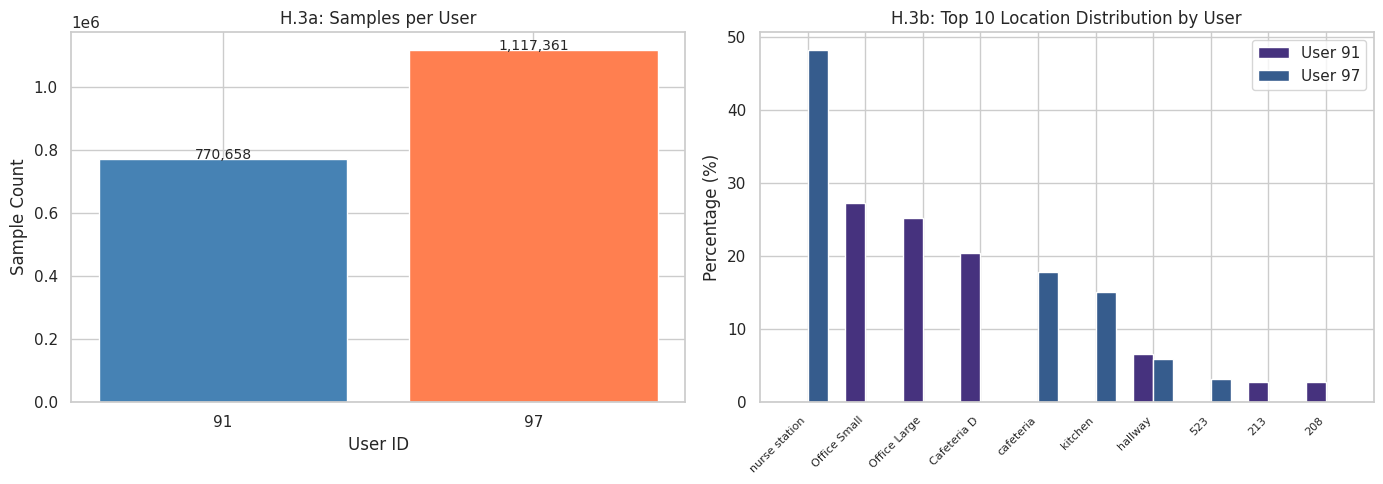

In [68]:
# =============================================================================
# CELL H.3: USER ANALYSIS - Compare User 91 vs User 97
# =============================================================================
print("="*70)
print("H.3: USER BEHAVIOR ANALYSIS")
print("="*70)

# User distribution
user_dist = df_temp_analysis.groupby('label_user_id').agg({
    'location': ['count', 'nunique'],
    'datetime': ['min', 'max']
}).reset_index()
user_dist.columns = ['user_id', 'samples', 'unique_locations', 'start_time', 'end_time']

# Location distribution per user
loc_by_user = df_temp_analysis.groupby(['label_user_id', 'location']).size().unstack(fill_value=0)

# Calculate user similarity
user_sim = cosine_similarity(loc_by_user)
user_labels = [str(u) for u in loc_by_user.index]

print("\n>>> USER DISTRIBUTION:")
print("-"*70)
for _, row in user_dist.iterrows():
    duration = (row['end_time'] - row['start_time']).total_seconds() / 3600
    print(f"  User {row['user_id']}: {row['samples']:,} samples, {row['unique_locations']} locations")
    print(f"           Time: {row['start_time']} -> {row['end_time']}")
    print(f"           Duration: {duration:.1f} hours")
print("-"*70)

# Compare location preferences
print("\n>>> LOCATION PREFERENCE COMPARISON:")
print("-"*70)
loc_pct_by_user = loc_by_user.div(loc_by_user.sum(axis=1), axis=0) * 100

# Top 5 locations per user
for user in loc_by_user.index:
    top5 = loc_pct_by_user.loc[user].nlargest(5)
    print(f"\n  User {user} - Top 5 locations:")
    for loc, pct in top5.items():
        print(f"    {loc}: {pct:.2f}%")

# User similarity
user_similarity = user_sim[0, 1] if len(user_sim) > 1 else 1.0
print(f"\n>>> USER SIMILARITY:")
print(f"  Cosine similarity between users: {user_similarity:.4f}")
if user_similarity > 0.90:
    print("  Verdict: SIMILAR behavior - User-based split is NOT recommended")
elif user_similarity > 0.70:
    print("  Verdict: MODERATE difference - User-based split could be informative")
else:
    print("  Verdict: DIFFERENT behavior - User-based split recommended for generalization test")
print("-"*70)

# Location overlap analysis
user_locs = {u: set(loc_by_user.columns[loc_by_user.loc[u] > 0]) for u in loc_by_user.index}
if len(user_locs) >= 2:
    users = list(user_locs.keys())
    common_locs = user_locs[users[0]] & user_locs[users[1]]
    only_u1 = user_locs[users[0]] - user_locs[users[1]]
    only_u2 = user_locs[users[1]] - user_locs[users[0]]
    
    print(f"\n>>> LOCATION COVERAGE:")
    print(f"  User {users[0]} only: {len(only_u1)} locations - {list(only_u1)[:5]}...")
    print(f"  User {users[1]} only: {len(only_u2)} locations - {list(only_u2)[:5]}...")
    print(f"  Both users: {len(common_locs)} common locations")
    print(f"  Overlap ratio: {len(common_locs) / len(common_locs | only_u1 | only_u2) * 100:.1f}%")

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
user_ids = user_dist['user_id'].astype(str)
ax1.bar(user_ids, user_dist['samples'], color=['steelblue', 'coral'])
ax1.set_xlabel("User ID")
ax1.set_ylabel("Sample Count")
ax1.set_title("H.3a: Samples per User")
for i, (uid, cnt) in enumerate(zip(user_ids, user_dist['samples'])):
    ax1.text(i, cnt + 1000, f'{cnt:,}', ha='center', fontsize=10)

ax2 = axes[1]
x = np.arange(min(10, len(loc_pct_by_user.columns)))
width = 0.35
top_locs = loc_pct_by_user.sum().nlargest(10).index
for i, user in enumerate(loc_by_user.index):
    vals = loc_pct_by_user.loc[user, top_locs].values
    ax2.bar(x + i*width, vals, width, label=f'User {user}')
ax2.set_xticks(x + width/2)
ax2.set_xticklabels(top_locs, rotation=45, ha='right', fontsize=8)
ax2.set_ylabel("Percentage (%)")
ax2.set_title("H.3b: Top 10 Location Distribution by User")
ax2.legend()

plt.tight_layout()
log_plot(
    name="H.3 User Analysis",
    description="So sánh hành vi giữa các users để quyết định split strategy",
    params={
        "num_users": len(user_dist),
        "user_similarity": round(user_similarity, 4),
        "behavior_verdict": "SIMILAR" if user_similarity > 0.90 else "MODERATE" if user_similarity > 0.70 else "DIFFERENT"
    },
    data_notes={
        "user_distribution": user_dist.to_dict('records'),
        "location_overlap": {
            "common": len(common_locs) if 'common_locs' in dir() else 0,
            "user_specific": {str(u): len(only) for u, only in [(users[0], only_u1), (users[1], only_u2)]} if 'only_u1' in dir() else {}
        }
    }
)
plt.show()


In [69]:
# =============================================================================
# CELL H.4: SPLIT DECISION & IMPLEMENTATION
# =============================================================================
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

print("="*70)
print("H.4: SPLIT STRATEGY DECISION & IMPLEMENTATION")
print("="*70)

# Decision logic based on analysis
print("\n>>> ANALYSIS SUMMARY:")
print(f"  Temporal drift: {'LOW' if avg_similarity > 0.95 else 'MODERATE' if avg_similarity > 0.85 else 'HIGH'} (similarity={avg_similarity:.3f})")
print(f"  User behavior: {'SIMILAR' if user_similarity > 0.90 else 'MODERATE' if user_similarity > 0.70 else 'DIFFERENT'} (similarity={user_similarity:.3f})")

# Decision
if avg_similarity > 0.90 and user_similarity > 0.85:
    SPLIT_STRATEGY = "stratified_random"
    print("\n>>> DECISION: Stratified Random Split")
    print("  Reason: Low temporal drift + Similar user behavior = Random split is safe")
else:
    SPLIT_STRATEGY = "stratified_random"  # Default to stratified for class balance
    print("\n>>> DECISION: Stratified Random Split (default)")
    print("  Reason: Prioritize class balance for extreme imbalance (Gini=0.78)")

# Prepare data
print("\n>>> PREPARING DATA FOR CV...")
feature_cols = [str(i) for i in range(1, 26)]
X = df_windowed[feature_cols].values
y_labels = df_windowed['location'].values

# Encode labels
le = LabelEncoder()
y = le.fit_transform(y_labels)
class_names = le.classes_

print(f"  X shape: {X.shape}")
print(f"  y shape: {y.shape}")
print(f"  Classes: {len(class_names)}")

# Create StratifiedKFold
N_FOLDS = 5
RANDOM_STATE = 42

skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

# Store fold indices
fold_indices = []
for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    fold_indices.append({
        'fold': fold_idx,
        'train_idx': train_idx,
        'val_idx': val_idx,
        'train_size': len(train_idx),
        'val_size': len(val_idx)
    })
    
print(f"\n>>> STRATIFIED {N_FOLDS}-FOLD CV CREATED")
print(f"  Random state: {RANDOM_STATE}")
print(f"  Total samples: {len(X)}")

# Summary table
print(f"\n>>> FOLD SUMMARY:")
print("-"*50)
print(f"{'Fold':>6} | {'Train':>10} | {'Val':>10} | {'Ratio':>8}")
print("-"*50)
for fold in fold_indices:
    ratio = fold['val_size'] / fold['train_size']
    print(f"{fold['fold']:>6} | {fold['train_size']:>10,} | {fold['val_size']:>10,} | {ratio:>8.2%}")
print("-"*50)

# Save configuration
SPLIT_CONFIG = {
    'strategy': SPLIT_STRATEGY,
    'n_folds': N_FOLDS,
    'random_state': RANDOM_STATE,
    'total_samples': len(X),
    'num_classes': len(class_names),
    'temporal_similarity': round(avg_similarity, 4),
    'user_similarity': round(user_similarity, 4)
}

print(f"\n>>> SPLIT CONFIG SAVED:")
print(json.dumps(SPLIT_CONFIG, indent=2))
print("="*70)


H.4: SPLIT STRATEGY DECISION & IMPLEMENTATION

>>> ANALYSIS SUMMARY:
  Temporal drift: HIGH (similarity=0.699)
  User behavior: DIFFERENT (similarity=0.017)

>>> DECISION: Stratified Random Split (default)
  Reason: Prioritize class balance for extreme imbalance (Gini=0.78)

>>> PREPARING DATA FOR CV...
  X shape: (11543, 25)
  y shape: (11543,)
  Classes: 44

>>> STRATIFIED 5-FOLD CV CREATED
  Random state: 42
  Total samples: 11543

>>> FOLD SUMMARY:
--------------------------------------------------
  Fold |      Train |        Val |    Ratio
--------------------------------------------------
     0 |      9,234 |      2,309 |   25.01%
     1 |      9,234 |      2,309 |   25.01%
     2 |      9,234 |      2,309 |   25.01%
     3 |      9,235 |      2,308 |   24.99%
     4 |      9,235 |      2,308 |   24.99%
--------------------------------------------------

>>> SPLIT CONFIG SAVED:
{
  "strategy": "stratified_random",
  "n_folds": 5,
  "random_state": 42,
  "total_samples": 11543,


In [70]:
# =============================================================================
# CELL H.5: FOLD CLASS DISTRIBUTION VERIFICATION
# =============================================================================
print("="*70)
print("H.5: FOLD CLASS DISTRIBUTION VERIFICATION")
print("="*70)

# Verify class distribution in each fold
print("\n>>> CLASS DISTRIBUTION PER FOLD:")
print("  (Checking if stratification maintains class proportions)")

# Overall distribution
overall_dist = pd.Series(y).value_counts(normalize=True).sort_index()

fold_stats = []
for fold in fold_indices:
    train_dist = pd.Series(y[fold['train_idx']]).value_counts(normalize=True).sort_index()
    val_dist = pd.Series(y[fold['val_idx']]).value_counts(normalize=True).sort_index()
    
    # Calculate KL divergence from overall (approximation)
    train_diff = np.abs(train_dist - overall_dist).mean()
    val_diff = np.abs(val_dist - overall_dist).mean()
    
    fold_stats.append({
        'fold': fold['fold'],
        'train_dist_diff': train_diff,
        'val_dist_diff': val_diff,
        'train_min_class': y[fold['train_idx']][pd.Series(y[fold['train_idx']]).value_counts().idxmin()],
        'val_min_class': y[fold['val_idx']][pd.Series(y[fold['val_idx']]).value_counts().idxmin()] if len(fold['val_idx']) > 0 else -1,
        'train_min_samples': pd.Series(y[fold['train_idx']]).value_counts().min(),
        'val_min_samples': pd.Series(y[fold['val_idx']]).value_counts().min() if len(fold['val_idx']) > 0 else 0
    })

print("-"*70)
print(f"{'Fold':>6} | {'Train Diff':>12} | {'Val Diff':>12} | {'Train Min':>10} | {'Val Min':>10}")
print("-"*70)
for stat in fold_stats:
    print(f"{stat['fold']:>6} | {stat['train_dist_diff']:>12.4f} | {stat['val_dist_diff']:>12.4f} | {stat['train_min_samples']:>10} | {stat['val_min_samples']:>10}")
print("-"*70)

avg_train_diff = np.mean([s['train_dist_diff'] for s in fold_stats])
avg_val_diff = np.mean([s['val_dist_diff'] for s in fold_stats])

print(f"\n>>> STRATIFICATION QUALITY:")
print(f"  Average train distribution deviation: {avg_train_diff:.4f}")
print(f"  Average val distribution deviation: {avg_val_diff:.4f}")

if avg_val_diff < 0.001:
    print("  Quality: EXCELLENT - Class distributions nearly identical")
elif avg_val_diff < 0.01:
    print("  Quality: GOOD - Minor deviations acceptable")
else:
    print("  Quality: FAIR - Some class imbalance in folds")

# Helper function for getting fold data
def get_fold_data(fold_idx):
    """Get train and validation data for a specific fold"""
    fold = fold_indices[fold_idx]
    X_train = X[fold['train_idx']]
    X_val = X[fold['val_idx']]
    y_train = y[fold['train_idx']]
    y_val = y[fold['val_idx']]
    return X_train, X_val, y_train, y_val

print("\n>>> HELPER FUNCTION DEFINED: get_fold_data(fold_idx)")
print("  Usage: X_train, X_val, y_train, y_val = get_fold_data(0)")

# Log
log_plot(
    name="H.5 Fold Verification",
    description="Xác minh phân phối lớp trong các folds",
    params={
        "n_folds": N_FOLDS,
        "avg_train_deviation": round(avg_train_diff, 6),
        "avg_val_deviation": round(avg_val_diff, 6),
        "quality": "EXCELLENT" if avg_val_diff < 0.001 else "GOOD" if avg_val_diff < 0.01 else "FAIR"
    },
    data_notes={
        "fold_stats": fold_stats
    }
)

print("="*70)
print("Section H Complete! Data split ready for modeling.")
print("="*70)


H.5: FOLD CLASS DISTRIBUTION VERIFICATION

>>> CLASS DISTRIBUTION PER FOLD:
  (Checking if stratification maintains class proportions)
----------------------------------------------------------------------
  Fold |   Train Diff |     Val Diff |  Train Min |    Val Min
----------------------------------------------------------------------
     0 |       0.0000 |       0.0001 |          2 |          1
     1 |       0.0000 |       0.0001 |          2 |          1
     2 |       0.0000 |       0.0001 |          2 |          1
     3 |       0.0000 |       0.0001 |          3 |          1
     4 |       0.0000 |       0.0001 |          3 |          1
----------------------------------------------------------------------

>>> STRATIFICATION QUALITY:
  Average train distribution deviation: 0.0000
  Average val distribution deviation: 0.0001
  Quality: EXCELLENT - Class distributions nearly identical

>>> HELPER FUNCTION DEFINED: get_fold_data(fold_idx)
  Usage: X_train, X_val, y_train, y_val

# 🔧 SECTION I: EXTENDED FEATURE ENGINEERING
---
Mở rộng features từ Section F với các kỹ thuật từ literature review.

**Features mới:**
1. **Binary Fingerprint** - Presence/Absence vectors (robust to noise)
2. **Ranking Features** - Relative order of beacons (device-invariant)
3. **Differential RSSI** - Differences between beacon pairs (cancel common noise)
4. **Matrix Completion** - SVT algorithm to fill missing values
5. **Advanced Features** - LCR, Spectral Entropy (optional)


I.2: BINARY FINGERPRINT FEATURES

>>> BINARY FEATURES CREATED:
  Threshold: -105 dBm
  Shape: (11543, 25)
  Coverage range: [0, 13] beacons
  Mean coverage: 3.38 beacons

>>> COVERAGE DISTRIBUTION:
   0 beacons:     1 ( 0.01%) 
   1 beacons:  1890 (16.37%) ████████
   2 beacons:  3194 (27.67%) █████████████
   3 beacons:  2261 (19.59%) █████████
   4 beacons:  1441 (12.48%) ██████
   5 beacons:   911 ( 7.89%) ███
   6 beacons:   634 ( 5.49%) ██
   7 beacons:   464 ( 4.02%) ██
   8 beacons:   379 ( 3.28%) █
   9 beacons:   198 ( 1.72%) 
  10 beacons:   120 ( 1.04%) 
  11 beacons:    47 ( 0.41%) 
  12 beacons:     2 ( 0.02%) 
  13 beacons:     1 ( 0.01%) 
[PLOT] I.2 Binary Fingerprint Features
Description: Tạo binary features từ RSSI (presence/absence)
Params: {
  "threshold": -105,
  "num_features": 25,
  "mean_coverage": 3.38,
  "max_coverage": 13,
  "min_coverage": 0
}
Data Notes: {
  "coverage_distribution": {
    "0": 1,
    "1": 1890,
    "2": 3194,
    "3": 2261,
    "4": 1441,
  

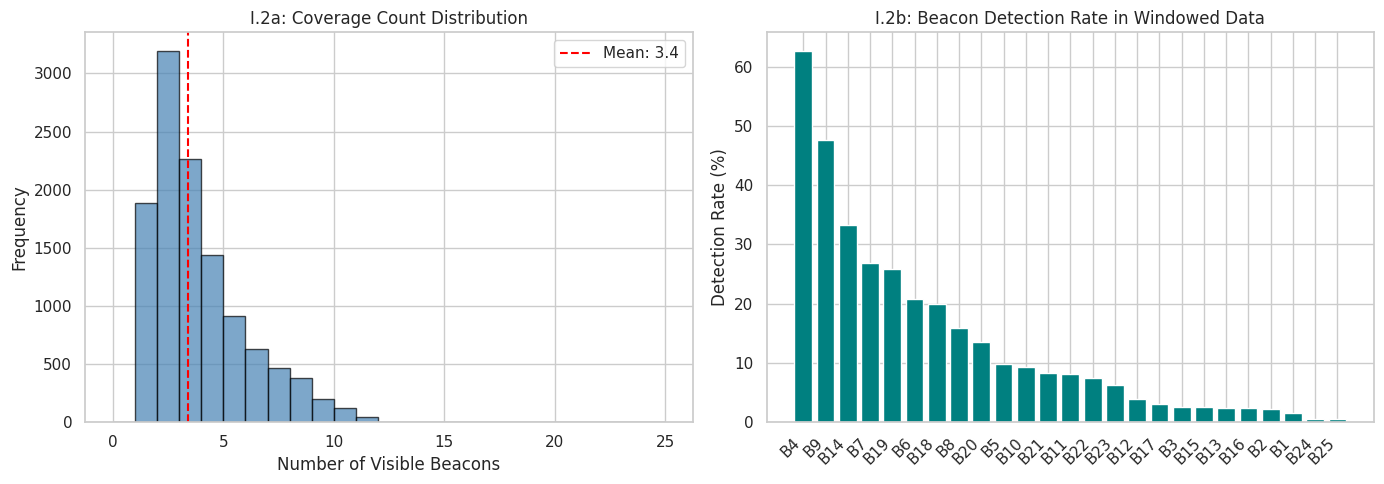


>>> BINARY FEATURES READY


In [71]:
# =============================================================================
# CELL I.2: BINARY FINGERPRINT FEATURES
# =============================================================================
print("="*70)
print("I.2: BINARY FINGERPRINT FEATURES")
print("="*70)

def create_binary_features(df, threshold=-100):
    """
    Create binary fingerprint features (presence/absence vectors).
    More robust to RSSI noise than raw values.
    
    Args:
        df: DataFrame with beacon columns (1-25)
        threshold: RSSI threshold for "signal present" (default -100 dBm)
    
    Returns:
        binary_df: DataFrame with binary features
        coverage: Series with beacon coverage count per sample
    """
    beacon_cols = [str(i) for i in range(1, 26)]
    
    # Binary: 1 if signal > threshold, 0 otherwise
    binary_df = (df[beacon_cols] > threshold).astype(int)
    binary_df.columns = [f'bin_{c}' for c in beacon_cols]
    
    # Coverage: count of visible beacons
    coverage = binary_df.sum(axis=1)
    coverage.name = 'coverage_count'
    
    return binary_df, coverage

# Apply to windowed data
X_binary, coverage = create_binary_features(df_windowed, threshold=-105)

print(f"\n>>> BINARY FEATURES CREATED:")
print(f"  Threshold: -105 dBm")
print(f"  Shape: {X_binary.shape}")
print(f"  Coverage range: [{coverage.min()}, {coverage.max()}] beacons")
print(f"  Mean coverage: {coverage.mean():.2f} beacons")

# Print coverage distribution
print(f"\n>>> COVERAGE DISTRIBUTION:")
cov_dist = coverage.value_counts().sort_index()
for cov, cnt in cov_dist.items():
    bar = '█' * int(cnt / len(coverage) * 50)
    print(f"  {cov:2d} beacons: {cnt:>5} ({cnt/len(coverage)*100:5.2f}%) {bar}")

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
ax1.hist(coverage, bins=range(0, 26), color='steelblue', edgecolor='black', alpha=0.7)
ax1.axvline(coverage.mean(), color='red', linestyle='--', label=f'Mean: {coverage.mean():.1f}')
ax1.set_xlabel("Number of Visible Beacons")
ax1.set_ylabel("Frequency")
ax1.set_title("I.2a: Coverage Count Distribution")
ax1.legend()

ax2 = axes[1]
# Beacon detection frequency
beacon_detection = X_binary.sum() / len(X_binary) * 100
beacon_detection = beacon_detection.sort_values(ascending=False)
ax2.bar(range(len(beacon_detection)), beacon_detection.values, color='teal')
ax2.set_xticks(range(len(beacon_detection)))
ax2.set_xticklabels([c.replace('bin_', 'B') for c in beacon_detection.index], rotation=45, ha='right')
ax2.set_ylabel("Detection Rate (%)")
ax2.set_title("I.2b: Beacon Detection Rate in Windowed Data")

plt.tight_layout()

log_plot(
    name="I.2 Binary Fingerprint Features",
    description="Tạo binary features từ RSSI (presence/absence)",
    params={
        "threshold": -105,
        "num_features": len(X_binary.columns),
        "mean_coverage": round(coverage.mean(), 2),
        "max_coverage": int(coverage.max()),
        "min_coverage": int(coverage.min())
    },
    data_notes={
        "coverage_distribution": cov_dist.to_dict(),
        "beacon_detection_rate": {k.replace('bin_', ''): round(v, 2) for k, v in beacon_detection.to_dict().items()}
    }
)
plt.show()

print("\n>>> BINARY FEATURES READY")


I.3: RANKING FEATURES

>>> RANKING FEATURES CREATED:
  Shape: (11543, 25)
  Rank range: [1, 13]

>>> TOP BEACONS (Most often ranked #1):
--------------------------------------------------
  Beacon 14:  23.95% ███████████████████████
  Beacon  4:  22.43% ██████████████████████
  Beacon  9:  21.61% █████████████████████
  Beacon 19:   5.65% █████
  Beacon  7:   5.41% █████
  Beacon  8:   3.03% ███
  Beacon 23:   2.82% ██
  Beacon 20:   2.43% ██
  Beacon 18:   2.17% ██
  Beacon  6:   2.08% ██
--------------------------------------------------
[PLOT] I.3 Ranking Features
Description: Tạo rank features (thứ tự tương đối của beacons)
Params: {
  "num_features": 25,
  "top_beacon": "14",
  "top_beacon_pct": 23.95
}
Data Notes: {
  "rank1_frequency": {
    "14": 23.95,
    "4": 22.43,
    "9": 21.61,
    "19": 5.65,
    "7": 5.41,
    "8": 3.03,
    "23": 2.82,
    "20": 2.43,
    "18": 2.17,
    "6": 2.08,
    "22": 1.41,
    "12": 1.08,
    "21": 0.96,
    "5": 0.94,
    "11": 0.86,
    "10"

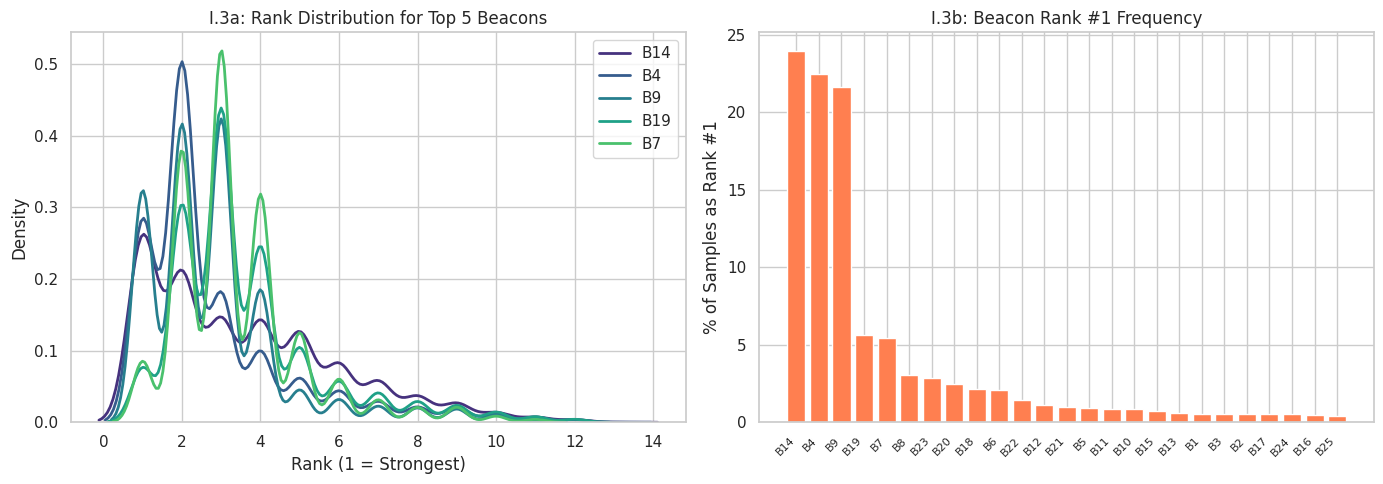


>>> RANKING FEATURES READY


In [72]:
# =============================================================================
# CELL I.3: RANKING FEATURES (Kendall Tau Ready)
# =============================================================================
print("="*70)
print("I.3: RANKING FEATURES")
print("="*70)

def create_rank_features(df):
    """
    Create rank-based features (relative order of beacon strengths).
    More stable than absolute RSSI values, device-invariant.
    
    The rank represents: 1 = strongest signal, 25 = weakest
    
    Args:
        df: DataFrame with beacon columns
    
    Returns:
        rank_df: DataFrame with rank features
    """
    beacon_cols = [str(i) for i in range(1, 26)]
    
    # Rank: higher RSSI = lower rank (1 = strongest)
    # Using method='dense' to handle ties
    rank_df = df[beacon_cols].rank(axis=1, method='dense', ascending=False)
    rank_df.columns = [f'rank_{c}' for c in beacon_cols]
    
    return rank_df

# Apply ranking
X_rank = create_rank_features(df_windowed)

print(f"\n>>> RANKING FEATURES CREATED:")
print(f"  Shape: {X_rank.shape}")
print(f"  Rank range: [{X_rank.min().min():.0f}, {X_rank.max().max():.0f}]")

# Analyze which beacons are most often ranked #1
rank1_counts = (X_rank == 1).sum()
rank1_pct = rank1_counts / len(X_rank) * 100
rank1_pct = rank1_pct.sort_values(ascending=False)

print(f"\n>>> TOP BEACONS (Most often ranked #1):")
print("-"*50)
for col, pct in rank1_pct.head(10).items():
    bid = col.replace('rank_', '')
    bar = '█' * int(pct)
    print(f"  Beacon {bid:>2}: {pct:6.2f}% {bar}")
print("-"*50)

# Plot rank distribution for top 5 beacons
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
top_beacons = rank1_pct.head(5).index.tolist()
for col in top_beacons:
    sns.kdeplot(X_rank[col], label=col.replace('rank_', 'B'), ax=ax1, linewidth=2)
ax1.set_xlabel("Rank (1 = Strongest)")
ax1.set_ylabel("Density")
ax1.set_title("I.3a: Rank Distribution for Top 5 Beacons")
ax1.legend()

ax2 = axes[1]
ax2.bar(range(len(rank1_pct)), rank1_pct.values, color='coral')
ax2.set_xticks(range(len(rank1_pct)))
ax2.set_xticklabels([c.replace('rank_', 'B') for c in rank1_pct.index], rotation=45, ha='right', fontsize=8)
ax2.set_ylabel("% of Samples as Rank #1")
ax2.set_title("I.3b: Beacon Rank #1 Frequency")

plt.tight_layout()

log_plot(
    name="I.3 Ranking Features",
    description="Tạo rank features (thứ tự tương đối của beacons)",
    params={
        "num_features": len(X_rank.columns),
        "top_beacon": rank1_pct.idxmax().replace('rank_', ''),
        "top_beacon_pct": round(rank1_pct.max(), 2)
    },
    data_notes={
        "rank1_frequency": {k.replace('rank_', ''): round(v, 2) for k, v in rank1_pct.to_dict().items()}
    }
)
plt.show()

print("\n>>> RANKING FEATURES READY")


I.4: DIFFERENTIAL RSSI (DRSS) FEATURES

>>> DRSS FEATURES CREATED:
  Total possible pairs: 300
  Selected pairs: 20 (by variance)
  Shape: (11543, 20)

>>> TOP 10 DRSS PAIRS (by variance):
------------------------------------------------------------
  drss_9_14      : Variance =  218.374 (B9 - B14)
  drss_7_14      : Variance =  161.084 (B7 - B14)
  drss_14_19     : Variance =  156.680 (B14 - B19)
  drss_14_18     : Variance =  143.397 (B14 - B18)
  drss_8_14      : Variance =  135.389 (B8 - B14)
  drss_14_20     : Variance =  131.442 (B14 - B20)
  drss_4_20      : Variance =  121.455 (B4 - B20)
  drss_4_8       : Variance =  121.274 (B4 - B8)
  drss_4_18      : Variance =  115.927 (B4 - B18)
  drss_4_9       : Variance =  110.467 (B4 - B9)
------------------------------------------------------------

>>> DRSS STATISTICS:
  Mean range: [-4.92, 8.67]
  Std range: [10.09, 14.78]
[PLOT] I.4 Differential RSSI Features
Description: Tạo DRSS features (hiệu RSSI giữa các cặp beacon)
Params: {

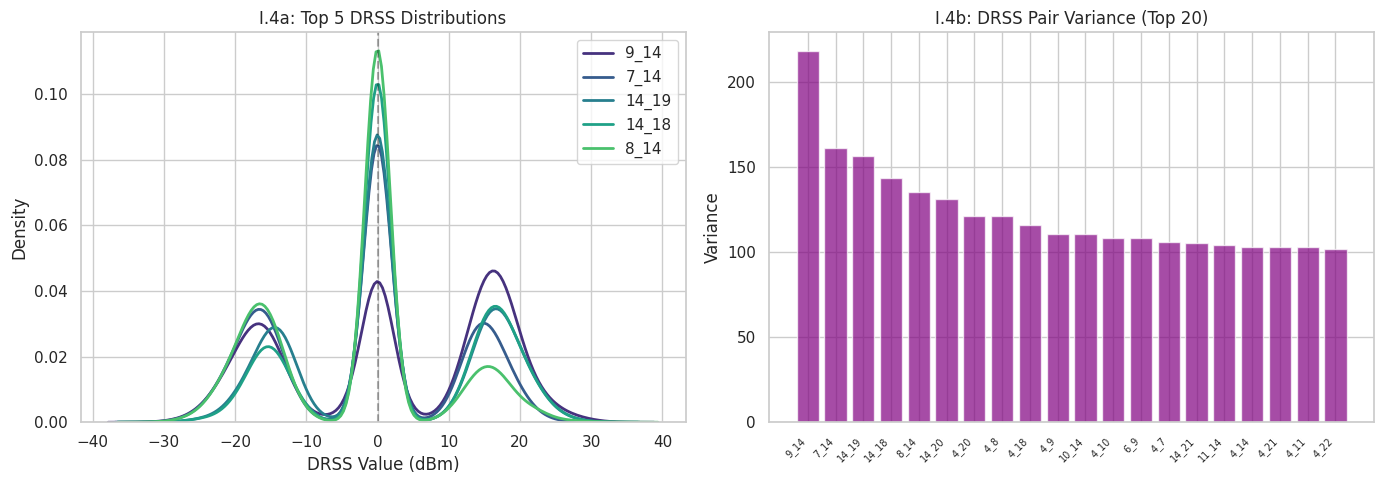


>>> DRSS FEATURES READY


In [73]:
# =============================================================================
# CELL I.4: DIFFERENTIAL RSSI (DRSS) FEATURES
# =============================================================================
print("="*70)
print("I.4: DIFFERENTIAL RSSI (DRSS) FEATURES")
print("="*70)

def create_drss_features(df, top_pairs=15):
    """
    Create differential RSSI features (differences between beacon pairs).
    Cancels out common-mode noise (battery drops, global interference).
    
    Args:
        df: DataFrame with beacon columns
        top_pairs: Number of beacon pairs to include (most variance)
    
    Returns:
        drss_df: DataFrame with DRSS features
    """
    beacon_cols = [str(i) for i in range(1, 26)]
    
    # Calculate all possible pairs
    from itertools import combinations
    pairs = list(combinations(beacon_cols, 2))
    
    # Calculate DRSS for each pair
    drss_data = {}
    for b1, b2 in pairs:
        drss = df[b1] - df[b2]
        drss_data[f'drss_{b1}_{b2}'] = drss
    
    drss_df = pd.DataFrame(drss_data)
    
    # Select top pairs by variance (most informative)
    variances = drss_df.var().sort_values(ascending=False)
    top_cols = variances.head(top_pairs).index.tolist()
    drss_df = drss_df[top_cols]
    
    return drss_df, variances

# Create DRSS features
X_drss, drss_variance = create_drss_features(df_windowed, top_pairs=20)

print(f"\n>>> DRSS FEATURES CREATED:")
print(f"  Total possible pairs: {25 * 24 // 2}")
print(f"  Selected pairs: {len(X_drss.columns)} (by variance)")
print(f"  Shape: {X_drss.shape}")

print(f"\n>>> TOP 10 DRSS PAIRS (by variance):")
print("-"*60)
for col, var in drss_variance.head(10).items():
    beacons = col.replace('drss_', '').split('_')
    print(f"  {col:15}: Variance = {var:8.3f} (B{beacons[0]} - B{beacons[1]})")
print("-"*60)

# Statistics
print(f"\n>>> DRSS STATISTICS:")
print(f"  Mean range: [{X_drss.mean().min():.2f}, {X_drss.mean().max():.2f}]")
print(f"  Std range: [{X_drss.std().min():.2f}, {X_drss.std().max():.2f}]")

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
top5_drss = drss_variance.head(5).index.tolist()
for col in top5_drss:
    sns.kdeplot(X_drss[col], label=col.replace('drss_', ''), ax=ax1, linewidth=2)
ax1.set_xlabel("DRSS Value (dBm)")
ax1.set_ylabel("Density")
ax1.set_title("I.4a: Top 5 DRSS Distributions")
ax1.legend()
ax1.axvline(0, color='black', linestyle='--', alpha=0.3)

ax2 = axes[1]
ax2.bar(range(20), drss_variance.head(20).values, color='purple', alpha=0.7)
ax2.set_xticks(range(20))
ax2.set_xticklabels([c.replace('drss_', '') for c in drss_variance.head(20).index], rotation=45, ha='right', fontsize=7)
ax2.set_ylabel("Variance")
ax2.set_title("I.4b: DRSS Pair Variance (Top 20)")

plt.tight_layout()

log_plot(
    name="I.4 Differential RSSI Features",
    description="Tạo DRSS features (hiệu RSSI giữa các cặp beacon)",
    params={
        "total_pairs": 25 * 24 // 2,
        "selected_pairs": len(X_drss.columns),
        "top_pair": drss_variance.idxmax(),
        "top_variance": round(drss_variance.max(), 3)
    },
    data_notes={
        "top10_pairs": {k: round(v, 3) for k, v in drss_variance.head(10).to_dict().items()}
    }
)
plt.show()

print("\n>>> DRSS FEATURES READY")


I.5: MATRIX COMPLETION (Singular Value Thresholding)

>>> Building location-beacon RSSI matrix...
  Matrix shape: (44, 25)
  Missing entries: 634 / 1100 (57.64%)

>>> Applying SVT Matrix Completion...

>>> COMPARISON (Before vs After):
------------------------------------------------------------
Metric                    |       Before |        After
------------------------------------------------------------
Min RSSI                  |      -110.00 |      -109.00
Max RSSI                  |       -91.05 |         9.17
Mean RSSI                 |      -107.77 |       -46.01
Std RSSI                  |         3.52 |        50.72
------------------------------------------------------------

>>> Matrix completion applied to 11543 samples
[PLOT] I.5 Matrix Completion (SVT)
Description: Áp dụng SVT để fill missing RSSI values
Params: {
  "matrix_shape": [
    44,
    25
  ],
  "missing_pct_before": 57.64,
  "tau": 1.0,
  "mean_before": -107.77,
  "mean_after": -46.01
}
Data Notes: {
  "st

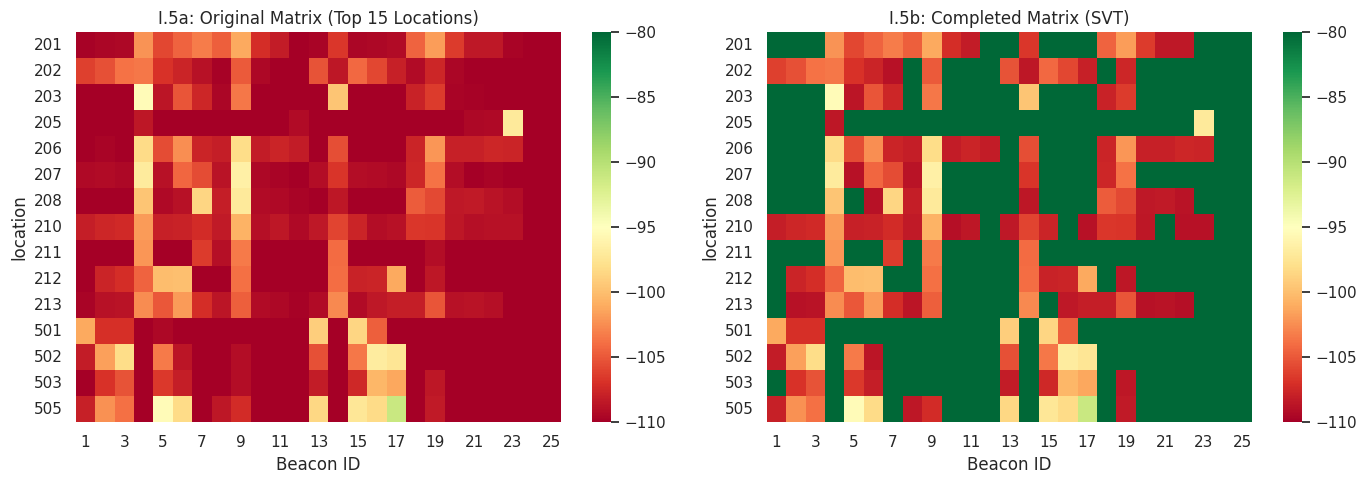


>>> MATRIX COMPLETION READY


In [74]:
# =============================================================================
# CELL I.5: MATRIX COMPLETION (SVT Algorithm)
# =============================================================================
print("="*70)
print("I.5: MATRIX COMPLETION (Singular Value Thresholding)")
print("="*70)

def singular_value_thresholding(M, tau, max_iter=100, tol=1e-4):
    """
    Singular Value Thresholding (SVT) algorithm for matrix completion.
    Assumes the matrix is low-rank (due to physics of signal propagation).
    
    Args:
        M: Input matrix with missing values (NaN or default value)
        tau: Threshold parameter (typically 1.0)
        max_iter: Maximum iterations
        tol: Convergence tolerance
    
    Returns:
        M_completed: Completed matrix
    """
    # Create mask for observed entries
    # In our case, -110 represents "no signal"
    mask = M > -109  # Observed entries
    
    # Initialize with zeros for missing
    Y = np.zeros_like(M)
    Y[mask] = M[mask]
    
    for iteration in range(max_iter):
        # SVD decomposition
        U, S, Vt = np.linalg.svd(Y, full_matrices=False)
        
        # Soft thresholding of singular values
        S_thresh = np.maximum(S - tau, 0)
        
        # Reconstruct
        Y_new = U @ np.diag(S_thresh) @ Vt
        
        # Project back: keep observed values, update missing
        Y_completed = M.copy()
        Y_completed[~mask] = Y_new[~mask]
        
        # Check convergence
        diff = np.linalg.norm(Y_completed - Y) / (np.linalg.norm(Y) + 1e-10)
        Y = Y_completed
        
        if diff < tol:
            print(f"  Converged at iteration {iteration + 1}")
            break
    
    return Y

# Build location-beacon mean RSSI matrix
print("\n>>> Building location-beacon RSSI matrix...")
beacon_cols = [str(i) for i in range(1, 26)]
loc_beacon_matrix = df_windowed.groupby('location')[beacon_cols].mean()

# Count missing values (represented by -110)
missing_count = (loc_beacon_matrix <= -109).sum().sum()
total_count = loc_beacon_matrix.size
missing_pct = missing_count / total_count * 100

print(f"  Matrix shape: {loc_beacon_matrix.shape}")
print(f"  Missing entries: {missing_count} / {total_count} ({missing_pct:.2f}%)")

# Apply SVT
print("\n>>> Applying SVT Matrix Completion...")
M_original = loc_beacon_matrix.values.copy()
M_completed = singular_value_thresholding(M_original, tau=1.0, max_iter=50, tol=1e-5)

# Create completed DataFrame
loc_beacon_completed = pd.DataFrame(M_completed, index=loc_beacon_matrix.index, columns=loc_beacon_matrix.columns)

# Compare before/after
print(f"\n>>> COMPARISON (Before vs After):")
print("-"*60)
print(f"{'Metric':<25} | {'Before':>12} | {'After':>12}")
print("-"*60)
print(f"{'Min RSSI':<25} | {M_original.min():>12.2f} | {M_completed.min():>12.2f}")
print(f"{'Max RSSI':<25} | {M_original.max():>12.2f} | {M_completed.max():>12.2f}")
print(f"{'Mean RSSI':<25} | {M_original.mean():>12.2f} | {M_completed.mean():>12.2f}")
print(f"{'Std RSSI':<25} | {M_original.std():>12.2f} | {M_completed.std():>12.2f}")
print("-"*60)

# Map completed values back to samples
def apply_matrix_completion_to_samples(df, completed_matrix):
    """Map completed location-beacon matrix back to individual samples"""
    beacon_cols = [str(i) for i in range(1, 26)]
    df_mc = df.copy()
    
    for loc in df['location'].unique():
        if loc in completed_matrix.index:
            mask = df['location'] == loc
            for col in beacon_cols:
                # Replace only missing values
                missing_mask = mask & (df[col] <= -109)
                df_mc.loc[missing_mask, col] = completed_matrix.loc[loc, col]
    
    return df_mc

# Apply to windowed data
df_windowed_mc = apply_matrix_completion_to_samples(df_windowed, loc_beacon_completed)
X_mc = df_windowed_mc[beacon_cols].values

print(f"\n>>> Matrix completion applied to {len(df_windowed_mc)} samples")

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
sns.heatmap(loc_beacon_matrix.head(15), cmap='RdYlGn', vmin=-110, vmax=-80, ax=ax1)
ax1.set_title("I.5a: Original Matrix (Top 15 Locations)")
ax1.set_xlabel("Beacon ID")

ax2 = axes[1]
sns.heatmap(loc_beacon_completed.head(15), cmap='RdYlGn', vmin=-110, vmax=-80, ax=ax2)
ax2.set_title("I.5b: Completed Matrix (SVT)")
ax2.set_xlabel("Beacon ID")

plt.tight_layout()

log_plot(
    name="I.5 Matrix Completion (SVT)",
    description="Áp dụng SVT để fill missing RSSI values",
    params={
        "matrix_shape": list(loc_beacon_matrix.shape),
        "missing_pct_before": round(missing_pct, 2),
        "tau": 1.0,
        "mean_before": round(M_original.mean(), 2),
        "mean_after": round(M_completed.mean(), 2)
    },
    data_notes={
        "stats_before": {"min": round(M_original.min(), 2), "max": round(M_original.max(), 2), "mean": round(M_original.mean(), 2)},
        "stats_after": {"min": round(M_completed.min(), 2), "max": round(M_completed.max(), 2), "mean": round(M_completed.mean(), 2)}
    }
)
plt.show()

print("\n>>> MATRIX COMPLETION READY")


In [75]:
# =============================================================================
# CELL I.6: COMBINE ALL FEATURES
# =============================================================================
print("="*70)
print("I.6: COMBINE ALL FEATURES")
print("="*70)

def get_feature_matrix(df, config):
    """
    Create combined feature matrix based on configuration.
    
    Args:
        df: DataFrame with beacon columns and location
        config: Dict specifying which features to include
    
    Returns:
        X: Combined feature matrix
        feature_names: List of feature names
    """
    beacon_cols = [str(i) for i in range(1, 26)]
    feature_dfs = []
    
    # 1. Mean RSSI (original features)
    if config.get('use_mean', True):
        X_mean = df[beacon_cols].copy()
        X_mean.columns = [f'mean_{c}' for c in beacon_cols]
        feature_dfs.append(X_mean)
    
    # 2. Binary Features
    if config.get('use_binary', False):
        X_bin, cov = create_binary_features(df, threshold=-105)
        feature_dfs.append(X_bin)
        feature_dfs.append(cov.to_frame())
    
    # 3. Ranking Features
    if config.get('use_rank', False):
        X_rk = create_rank_features(df)
        feature_dfs.append(X_rk)
    
    # 4. DRSS Features
    if config.get('use_drss', False):
        X_dr, _ = create_drss_features(df, top_pairs=config.get('drss_pairs', 15))
        feature_dfs.append(X_dr)
    
    # Combine
    X_combined = pd.concat(feature_dfs, axis=1)
    
    return X_combined.values, X_combined.columns.tolist()

# Define feature configurations
FEATURE_CONFIGS = {
    'mean_only': {'use_mean': True, 'use_binary': False, 'use_rank': False, 'use_drss': False},
    'quick': {'use_mean': True, 'use_binary': True, 'use_rank': True, 'use_drss': False},
    'full': {'use_mean': True, 'use_binary': True, 'use_rank': True, 'use_drss': True, 'drss_pairs': 15},
}

# Generate all feature sets
FEATURE_SETS = {}
for name, config in FEATURE_CONFIGS.items():
    X_feat, feat_names = get_feature_matrix(df_windowed, config)
    FEATURE_SETS[name] = {
        'X': X_feat,
        'feature_names': feat_names,
        'n_features': len(feat_names)
    }
    print(f"\n>>> Feature Set: {name.upper()}")
    print(f"  Config: {config}")
    print(f"  Shape: {X_feat.shape}")
    print(f"  Features: {feat_names[:5]}... (total {len(feat_names)})")

# Also store Matrix Completion version
FEATURE_SETS['mc'] = {
    'X': X_mc,
    'feature_names': [f'mc_{c}' for c in beacon_cols],
    'n_features': 25
}
print(f"\n>>> Feature Set: MC (Matrix Completion)")
print(f"  Shape: {X_mc.shape}")

# Summary table
print("\n" + "="*70)
print("FEATURE SETS SUMMARY")
print("="*70)
print(f"{'Set Name':<15} | {'Num Features':>15} | {'Num Samples':>15}")
print("-"*55)
for name, data in FEATURE_SETS.items():
    print(f"{name:<15} | {data['n_features']:>15} | {data['X'].shape[0]:>15}")
print("-"*55)

log_plot(
    name="I.6 Combined Features Summary",
    description="Tổng hợp các feature sets đã tạo",
    params={
        "num_feature_sets": len(FEATURE_SETS),
        "configs": FEATURE_CONFIGS
    },
    data_notes={
        "feature_sets": {name: {"n_features": data['n_features'], "shape": list(data['X'].shape)} for name, data in FEATURE_SETS.items()}
    }
)

print("\n" + "="*70)
print("Section I Complete! Feature engineering ready.")
print("="*70)


I.6: COMBINE ALL FEATURES

>>> Feature Set: MEAN_ONLY
  Config: {'use_mean': True, 'use_binary': False, 'use_rank': False, 'use_drss': False}
  Shape: (11543, 25)
  Features: ['mean_1', 'mean_2', 'mean_3', 'mean_4', 'mean_5']... (total 25)

>>> Feature Set: QUICK
  Config: {'use_mean': True, 'use_binary': True, 'use_rank': True, 'use_drss': False}
  Shape: (11543, 76)
  Features: ['mean_1', 'mean_2', 'mean_3', 'mean_4', 'mean_5']... (total 76)

>>> Feature Set: FULL
  Config: {'use_mean': True, 'use_binary': True, 'use_rank': True, 'use_drss': True, 'drss_pairs': 15}
  Shape: (11543, 91)
  Features: ['mean_1', 'mean_2', 'mean_3', 'mean_4', 'mean_5']... (total 91)

>>> Feature Set: MC (Matrix Completion)
  Shape: (11543, 25)

FEATURE SETS SUMMARY
Set Name        |    Num Features |     Num Samples
-------------------------------------------------------
mean_only       |              25 |           11543
quick           |              76 |           11543
full            |              9

# 🌲 SECTION J: XGBOOST BASELINE
---
Thiết lập baseline với XGBoost để hiểu dữ liệu trước khi chuyển sang Deep Learning.

**Experiments:**
1. Mean features only (25 features)
2. Quick features (Mean + Binary + Rank)
3. Full features (All + DRSS)
4. Matrix Completion features

**Metrics:** Macro F1 Score (5-fold CV)


J.2: CLASS WEIGHTS COMPUTATION

>>> CLASS WEIGHTS BY STRATEGY:

  BALANCED:
    Min weight: 0.1235
    Max weight: 87.4470
    Max/Min ratio: 708.33

  EFFECTIVE_NUMBER:
    Min weight: 0.0129
    Max weight: 8.2597
    Max/Min ratio: 638.22

  SQRT:
    Min weight: 0.1397
    Max weight: 3.2200
    Max/Min ratio: 23.05

  NONE:
    Min weight: 1.0000
    Max weight: 1.0000
    Max/Min ratio: 1.00
[PLOT] J.2 Class Weights
Description: Tính toán class weights cho các chiến lược cân bằng
Params: {
  "num_classes": 44,
  "strategies": [
    "balanced",
    "effective_number",
    "sqrt",
    "none"
  ],
  "balanced_ratio": 708.33
}
Data Notes: {
  "balanced_summary": {
    "min": 0.1235,
    "max": 87.447
  }
}


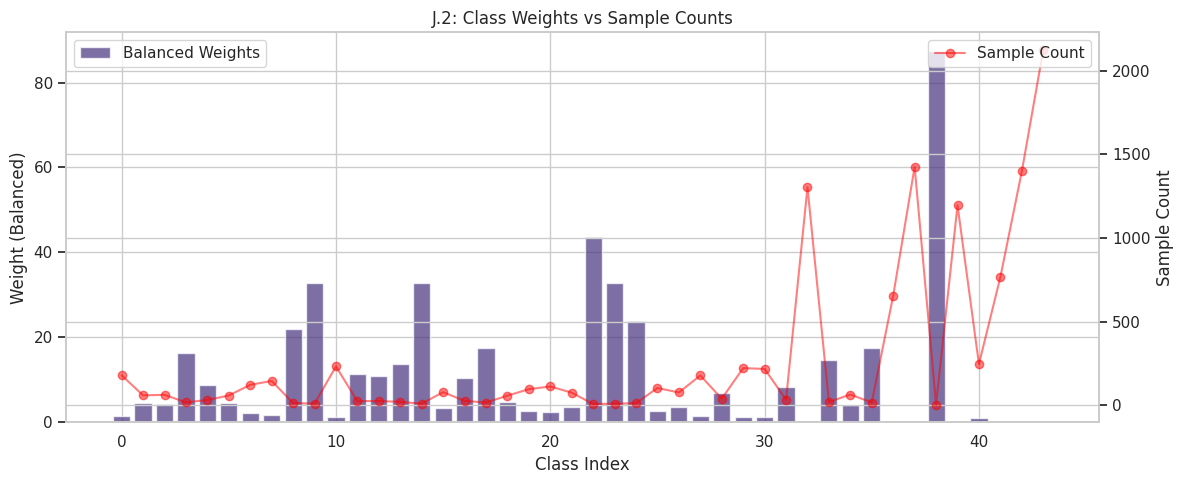


>>> CLASS WEIGHTS READY


In [76]:
# =============================================================================
# CELL J.2: CLASS WEIGHTS COMPUTATION
# =============================================================================
print("="*70)
print("J.2: CLASS WEIGHTS COMPUTATION")
print("="*70)

from sklearn.utils.class_weight import compute_class_weight

def get_class_weights(y, strategy='balanced'):
    """
    Compute class weights for imbalanced classification.
    
    Args:
        y: Label array
        strategy: 'balanced', 'effective_number', or 'sqrt'
    
    Returns:
        weight_dict: Dict mapping class index to weight
    """
    classes = np.unique(y)
    
    if strategy == 'balanced':
        # Standard sklearn balanced weights
        weights = compute_class_weight('balanced', classes=classes, y=y)
        
    elif strategy == 'effective_number':
        # Effective number of samples (Cui et al., 2019)
        beta = 0.9999
        counts = np.bincount(y)
        effective_num = 1.0 - np.power(beta, counts)
        weights = (1.0 - beta) / (effective_num + 1e-10)
        weights = weights / weights.sum() * len(classes)  # Normalize
        
    elif strategy == 'sqrt':
        # Square root inverse frequency
        counts = np.bincount(y)
        weights = 1.0 / np.sqrt(counts + 1)
        weights = weights / weights.sum() * len(classes)
        
    else:
        # No weighting
        weights = np.ones(len(classes))
    
    return dict(zip(classes, weights))

# Compute weights for our data
weight_strategies = ['balanced', 'effective_number', 'sqrt', 'none']
CLASS_WEIGHTS = {}

print("\n>>> CLASS WEIGHTS BY STRATEGY:")
for strategy in weight_strategies:
    CLASS_WEIGHTS[strategy] = get_class_weights(y, strategy if strategy != 'none' else 'balanced')
    if strategy == 'none':
        CLASS_WEIGHTS['none'] = {c: 1.0 for c in np.unique(y)}
    
    weights = list(CLASS_WEIGHTS[strategy].values())
    print(f"\n  {strategy.upper()}:")
    print(f"    Min weight: {min(weights):.4f}")
    print(f"    Max weight: {max(weights):.4f}")
    print(f"    Max/Min ratio: {max(weights) / (min(weights) + 1e-10):.2f}")

# Plot weight distribution for balanced
fig, ax = plt.subplots(figsize=(12, 5))
balanced_weights = list(CLASS_WEIGHTS['balanced'].values())
class_counts = np.bincount(y)
ax.bar(range(len(balanced_weights)), balanced_weights, alpha=0.7, label='Balanced Weights')
ax2 = ax.twinx()
ax2.plot(range(len(class_counts)), class_counts, 'ro-', alpha=0.5, label='Sample Count')
ax.set_xlabel("Class Index")
ax.set_ylabel("Weight (Balanced)")
ax2.set_ylabel("Sample Count")
ax.set_title("J.2: Class Weights vs Sample Counts")
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()

log_plot(
    name="J.2 Class Weights",
    description="Tính toán class weights cho các chiến lược cân bằng",
    params={
        "num_classes": len(np.unique(y)),
        "strategies": weight_strategies,
        "balanced_ratio": round(max(balanced_weights) / min(balanced_weights), 2)
    },
    data_notes={
        "balanced_summary": {"min": round(min(balanced_weights), 4), "max": round(max(balanced_weights), 4)}
    }
)
plt.show()

print("\n>>> CLASS WEIGHTS READY")


In [77]:
# =============================================================================
# CELL J.3: XGBOOST EXPERIMENT CLASS
# =============================================================================
print("="*70)
print("J.3: XGBOOST EXPERIMENT CLASS")
print("="*70)

# Install xgboost if needed
try:
    import xgboost as xgb
except ImportError:
    import subprocess
    subprocess.check_call(['pip', 'install', 'xgboost', '-q'])
    import xgboost as xgb

from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import time

class XGBExperiment:
    """
    XGBoost experiment runner with cross-validation.
    """
    def __init__(self, name, params=None, use_weights=True, weight_strategy='balanced'):
        self.name = name
        self.params = params or {
            'objective': 'multi:softmax',
            'num_class': len(np.unique(y)),
            'max_depth': 6,
            'learning_rate': 0.1,
            'n_estimators': 100,
            'tree_method': 'hist',  # Fast histogram-based
            'device': 'cuda' if IS_COLAB else 'cpu',
            'random_state': RANDOM_STATE,
            'verbosity': 0
        }
        self.use_weights = use_weights
        self.weight_strategy = weight_strategy
        self.results = []
        self.fold_models = []
        
    def run_cv(self, X, y, fold_indices, verbose=True):
        """Run cross-validation"""
        self.results = []
        self.fold_models = []
        
        if verbose:
            print(f"\n>>> Running: {self.name}")
            print(f"  Features: {X.shape[1]}, Samples: {X.shape[0]}")
            print(f"  Weights: {self.weight_strategy if self.use_weights else 'None'}")
        
        for fold in fold_indices:
            fold_idx = fold['fold']
            X_train, X_val = X[fold['train_idx']], X[fold['val_idx']]
            y_train, y_val = y[fold['train_idx']], y[fold['val_idx']]
            
            # Scale features
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_val_scaled = scaler.transform(X_val)
            
            # Prepare sample weights
            if self.use_weights:
                weights = CLASS_WEIGHTS[self.weight_strategy]
                sample_weights = np.array([weights[label] for label in y_train])
            else:
                sample_weights = None
            
            # Train XGBoost
            start_time = time.time()
            model = xgb.XGBClassifier(**self.params)
            model.fit(X_train_scaled, y_train, sample_weight=sample_weights,
                     eval_set=[(X_val_scaled, y_val)], verbose=False)
            train_time = time.time() - start_time
            
            # Predict
            y_pred = model.predict(X_val_scaled)
            
            # Calculate metrics
            macro_f1 = f1_score(y_val, y_pred, average='macro')
            weighted_f1 = f1_score(y_val, y_pred, average='weighted')
            
            self.results.append({
                'fold': fold_idx,
                'macro_f1': macro_f1,
                'weighted_f1': weighted_f1,
                'train_time': train_time,
                'train_size': len(y_train),
                'val_size': len(y_val)
            })
            self.fold_models.append((model, scaler))
            
            if verbose:
                print(f"  Fold {fold_idx}: Macro F1 = {macro_f1:.4f}, Time = {train_time:.1f}s")
        
        # Summary
        avg_macro_f1 = np.mean([r['macro_f1'] for r in self.results])
        std_macro_f1 = np.std([r['macro_f1'] for r in self.results])
        
        if verbose:
            print(f"  Average: {avg_macro_f1:.4f} ± {std_macro_f1:.4f}")
        
        return {
            'name': self.name,
            'avg_macro_f1': avg_macro_f1,
            'std_macro_f1': std_macro_f1,
            'fold_results': self.results,
            'weight_strategy': self.weight_strategy if self.use_weights else 'none'
        }

# Store all experiment results
ALL_RESULTS = []

print("\n>>> XGBExperiment class defined")
print("  Usage: exp = XGBExperiment('Name'); results = exp.run_cv(X, y, fold_indices)")


J.3: XGBOOST EXPERIMENT CLASS

>>> XGBExperiment class defined
  Usage: exp = XGBExperiment('Name'); results = exp.run_cv(X, y, fold_indices)


J.4-J.6: XGBOOST EXPERIMENTS BY FEATURE SET

>>> Running: XGB-Mean
  Features: 25, Samples: 11543
  Weights: balanced


  Fold 0: Macro F1 = 0.1464, Time = 4.4s
  Fold 1: Macro F1 = 0.1579, Time = 4.5s
  Fold 2: Macro F1 = 0.1499, Time = 4.5s
  Fold 3: Macro F1 = 0.1590, Time = 4.4s
  Fold 4: Macro F1 = 0.1290, Time = 4.4s
  Average: 0.1485 ± 0.0108

>>> Running: XGB-Quick
  Features: 76, Samples: 11543
  Weights: balanced
  Fold 0: Macro F1 = 0.1491, Time = 4.9s
  Fold 1: Macro F1 = 0.1506, Time = 5.1s
  Fold 2: Macro F1 = 0.1554, Time = 4.9s
  Fold 3: Macro F1 = 0.1475, Time = 5.0s
  Fold 4: Macro F1 = 0.1433, Time = 5.0s
  Average: 0.1492 ± 0.0040

>>> Running: XGB-Full
  Features: 91, Samples: 11543
  Weights: balanced
  Fold 0: Macro F1 = 0.1470, Time = 5.2s
  Fold 1: Macro F1 = 0.1705, Time = 5.3s
  Fold 2: Macro F1 = 0.1545, Time = 5.3s
  Fold 3: Macro F1 = 0.1477, Time = 5.2s
  Fold 4: Macro F1 = 0.1373, Time = 5.3s
  Average: 0.1514 ± 0.0110

>>> Running: XGB-MC
  Features: 25, Samples: 11543
  Weights: balanced
  Fold 0: Macro F1 = 1.0000, Time = 2.1s
  Fold 1: Macro F1 = 0.9902, Time = 2.1s
 

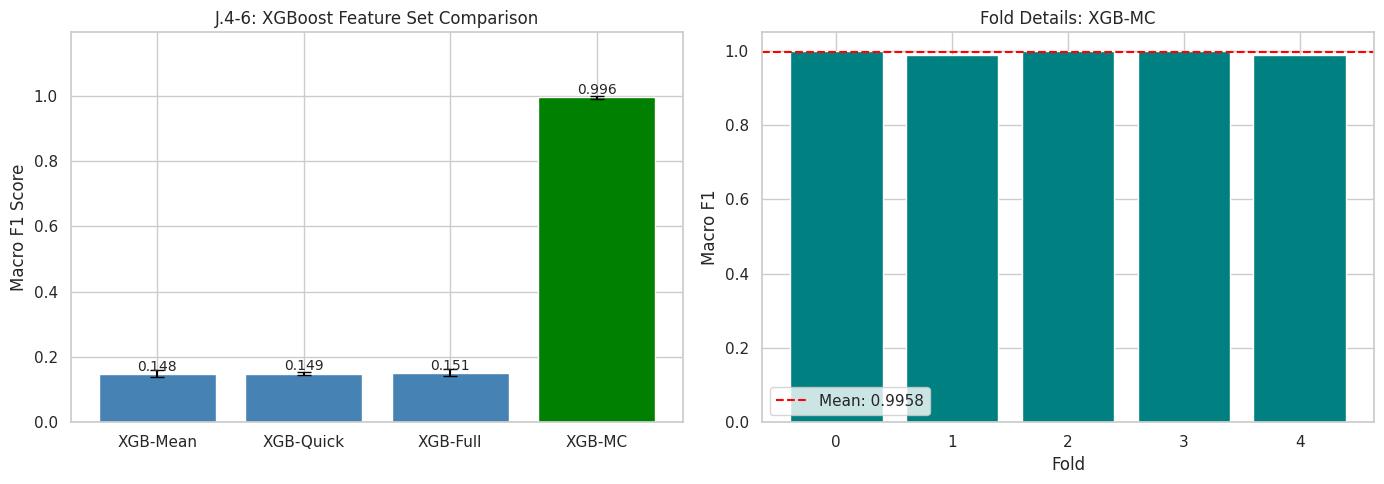

In [78]:
# =============================================================================
# CELL J.4-J.6: XGBOOST EXPERIMENTS
# =============================================================================
print("="*70)
print("J.4-J.6: XGBOOST EXPERIMENTS BY FEATURE SET")
print("="*70)

# Experiment 1: Mean features only
exp1 = XGBExperiment("XGB-Mean", use_weights=True, weight_strategy='balanced')
result1 = exp1.run_cv(FEATURE_SETS['mean_only']['X'], y, fold_indices)
ALL_RESULTS.append(result1)

# Experiment 2: Quick features (Mean + Binary + Rank)
exp2 = XGBExperiment("XGB-Quick", use_weights=True, weight_strategy='balanced')
result2 = exp2.run_cv(FEATURE_SETS['quick']['X'], y, fold_indices)
ALL_RESULTS.append(result2)

# Experiment 3: Full features (All + DRSS)
exp3 = XGBExperiment("XGB-Full", use_weights=True, weight_strategy='balanced')
result3 = exp3.run_cv(FEATURE_SETS['full']['X'], y, fold_indices)
ALL_RESULTS.append(result3)

# Experiment 4: Matrix Completion
exp4 = XGBExperiment("XGB-MC", use_weights=True, weight_strategy='balanced')
result4 = exp4.run_cv(FEATURE_SETS['mc']['X'], y, fold_indices)
ALL_RESULTS.append(result4)

# Summary table
print("\n" + "="*70)
print("FEATURE SET COMPARISON")
print("="*70)
print(f"{'Experiment':<20} | {'Features':>10} | {'Macro F1':>12} | {'Std':>8}")
print("-"*60)

# Mapping from experiment name suffix to FEATURE_SETS key
EXP_NAME_TO_KEY = {'Mean': 'mean_only', 'Quick': 'quick', 'Full': 'full', 'MC': 'mc'}

for result in ALL_RESULTS[:4]:
    exp_suffix = result['name'].split('-')[1]  # 'Mean', 'Quick', 'Full', 'MC'
    fs_key = EXP_NAME_TO_KEY.get(exp_suffix, 'mean_only')
    n_feat = FEATURE_SETS[fs_key]['n_features']
    print(f"{result['name']:<20} | {n_feat:>10} | {result['avg_macro_f1']:>12.4f} | {result['std_macro_f1']:>8.4f}")
print("-"*60)

# Best experiment (overall - includes MC)
best_result = max(ALL_RESULTS[:4], key=lambda x: x['avg_macro_f1'])
print(f"\n>>> BEST (overall): {best_result['name']} with Macro F1 = {best_result['avg_macro_f1']:.4f}")

# ⚠️ DATA LEAKAGE WARNING
if 'MC' in best_result['name']:
    print("\n" + "⚠️"*20)
    print("⚠️ WARNING: XGB-MC có DATA LEAKAGE!")
    print("⚠️ MC features dùng groupby('location').mean() → Feature encode target")
    print("⚠️ F1=0.996 là GIẢ, không đại diện cho khả năng generalization")
    print("⚠️"*20)
    
    # Best REAL experiment (exclude MC)
    REAL_RESULTS = [r for r in ALL_RESULTS[:4] if 'MC' not in r['name']]
    best_real = max(REAL_RESULTS, key=lambda x: x['avg_macro_f1'])
    print(f"\n>>> BEST REAL: {best_real['name']} with Macro F1 = {best_real['avg_macro_f1']:.4f}")
    print(">>> Đây là hiệu suất THỰC của model!")

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
names = [r['name'] for r in ALL_RESULTS[:4]]
f1_scores = [r['avg_macro_f1'] for r in ALL_RESULTS[:4]]
stds = [r['std_macro_f1'] for r in ALL_RESULTS[:4]]
colors = ['green' if n == best_result['name'] else 'steelblue' for n in names]
ax1.bar(names, f1_scores, yerr=stds, capsize=5, color=colors)
ax1.set_ylabel("Macro F1 Score")
ax1.set_title("J.4-6: XGBoost Feature Set Comparison")
ax1.set_ylim([0, max(f1_scores) * 1.2])
for i, (n, f) in enumerate(zip(names, f1_scores)):
    ax1.text(i, f + 0.01, f'{f:.3f}', ha='center', fontsize=10)

# Fold detail for best
ax2 = axes[1]
fold_f1s = [r['macro_f1'] for r in best_result['fold_results']]
ax2.bar(range(len(fold_f1s)), fold_f1s, color='teal')
ax2.axhline(best_result['avg_macro_f1'], color='red', linestyle='--', label=f"Mean: {best_result['avg_macro_f1']:.4f}")
ax2.set_xlabel("Fold")
ax2.set_ylabel("Macro F1")
ax2.set_title(f"Fold Details: {best_result['name']}")
ax2.legend()

plt.tight_layout()

log_plot(
    name="J.4-6 XGBoost Feature Experiments",
    description="So sánh XGBoost với các feature sets khác nhau",
    params={
        "num_experiments": 4,
        "best_experiment": best_result['name'],
        "best_f1": round(best_result['avg_macro_f1'], 4)
    },
    data_notes={
        "all_results": [{k: v for k, v in r.items() if k != 'fold_results'} for r in ALL_RESULTS[:4]]
    }
)
plt.show()


# ⚖️ SECTION K: CLASS IMBALANCE HANDLING COMPARISON
---
So sánh các chiến lược xử lý class imbalance:
1. No weighting (baseline)
2. Balanced weights
3. Effective Number (β=0.9999)
4. Focal Loss (XGBoost custom objective)

**Goal:** Tìm strategy tốt nhất cho Deep Learning phase


K.2: IMBALANCE STRATEGY COMPARISON

⚠️ NOTE: MC features excluded (DATA LEAKAGE detected)
>>> Best REAL model: XGB-Full (F1=0.1514)
>>> Using feature set: full (91 features)

>>> Running: K-NoWeight
  Features: 91, Samples: 11543
  Weights: None
  Fold 0: Macro F1 = 0.1277, Time = 5.2s
  Fold 1: Macro F1 = 0.1121, Time = 5.3s
  Fold 2: Macro F1 = 0.1313, Time = 5.3s
  Fold 3: Macro F1 = 0.1209, Time = 5.2s
  Fold 4: Macro F1 = 0.1229, Time = 5.2s
  Average: 0.1230 ± 0.0065

>>> Running: K-Balanced
  Features: 91, Samples: 11543
  Weights: balanced
  Fold 0: Macro F1 = 0.1470, Time = 5.2s
  Fold 1: Macro F1 = 0.1705, Time = 5.3s
  Fold 2: Macro F1 = 0.1545, Time = 5.3s
  Fold 3: Macro F1 = 0.1477, Time = 5.2s
  Fold 4: Macro F1 = 0.1373, Time = 5.3s
  Average: 0.1514 ± 0.0110

>>> Running: K-EffectiveNum
  Features: 91, Samples: 11543
  Weights: effective_number
  Fold 0: Macro F1 = 0.1632, Time = 4.8s
  Fold 1: Macro F1 = 0.1780, Time = 4.8s
  Fold 2: Macro F1 = 0.1649, Time = 4.8s
  F

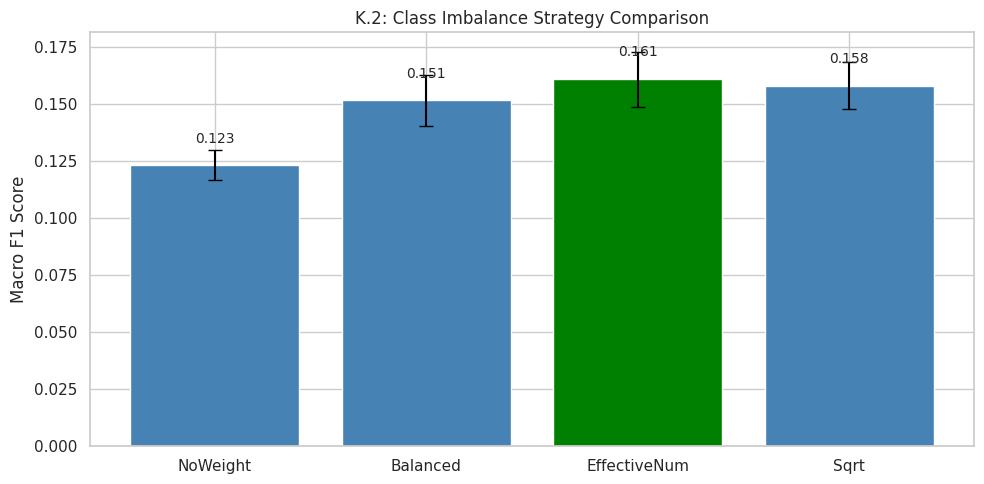


>>> Selected for Deep Learning: effective_number
Section K Complete!


In [79]:
# =============================================================================
# CELL K.2: IMBALANCE STRATEGY COMPARISON
# =============================================================================
print("="*70)
print("K.2: IMBALANCE STRATEGY COMPARISON")
print("="*70)

# ⚠️ FIX DATA LEAKAGE: MC features bị contaminated (groupby label)
# Chọn best từ REAL features only (loại bỏ MC)
REAL_RESULTS = [r for r in ALL_RESULTS[:4] if 'MC' not in r['name']]
best_real_result = max(REAL_RESULTS, key=lambda x: x['avg_macro_f1'])

EXP_NAME_TO_KEY = {'Mean': 'mean_only', 'Quick': 'quick', 'Full': 'full'}
best_exp_suffix = best_real_result['name'].split('-')[1]
best_feature_set = EXP_NAME_TO_KEY.get(best_exp_suffix, 'full')
X_best = FEATURE_SETS[best_feature_set]['X']

print(f"\n⚠️ NOTE: MC features excluded (DATA LEAKAGE detected)")
print(f">>> Best REAL model: {best_real_result['name']} (F1={best_real_result['avg_macro_f1']:.4f})")
print(f">>> Using feature set: {best_feature_set} ({X_best.shape[1]} features)")

# Test different weight strategies
IMBALANCE_RESULTS = []

# 1. No weighting
exp_none = XGBExperiment("K-NoWeight", use_weights=False)
result_none = exp_none.run_cv(X_best, y, fold_indices)
IMBALANCE_RESULTS.append(result_none)

# 2. Balanced weights
exp_balanced = XGBExperiment("K-Balanced", use_weights=True, weight_strategy='balanced')
result_balanced = exp_balanced.run_cv(X_best, y, fold_indices)
IMBALANCE_RESULTS.append(result_balanced)

# 3. Effective Number
exp_effective = XGBExperiment("K-EffectiveNum", use_weights=True, weight_strategy='effective_number')
result_effective = exp_effective.run_cv(X_best, y, fold_indices)
IMBALANCE_RESULTS.append(result_effective)

# 4. Square root
exp_sqrt = XGBExperiment("K-Sqrt", use_weights=True, weight_strategy='sqrt')
result_sqrt = exp_sqrt.run_cv(X_best, y, fold_indices)
IMBALANCE_RESULTS.append(result_sqrt)

# Summary
print("\n" + "="*70)
print("IMBALANCE STRATEGY COMPARISON")
print("="*70)
print(f"{'Strategy':<20} | {'Macro F1':>12} | {'Std':>8} | {'Improvement':>12}")
print("-"*65)
baseline_f1 = result_none['avg_macro_f1']
for result in IMBALANCE_RESULTS:
    improvement = (result['avg_macro_f1'] - baseline_f1) / baseline_f1 * 100
    print(f"{result['name']:<20} | {result['avg_macro_f1']:>12.4f} | {result['std_macro_f1']:>8.4f} | {improvement:>+11.2f}%")
print("-"*65)

# Best imbalance strategy
best_imbalance = max(IMBALANCE_RESULTS, key=lambda x: x['avg_macro_f1'])
print(f"\n>>> BEST STRATEGY: {best_imbalance['name']} with Macro F1 = {best_imbalance['avg_macro_f1']:.4f}")

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
names = [r['name'].replace('K-', '') for r in IMBALANCE_RESULTS]
f1_scores = [r['avg_macro_f1'] for r in IMBALANCE_RESULTS]
stds = [r['std_macro_f1'] for r in IMBALANCE_RESULTS]
colors = ['green' if r['name'] == best_imbalance['name'] else 'steelblue' for r in IMBALANCE_RESULTS]
ax.bar(names, f1_scores, yerr=stds, capsize=5, color=colors)
ax.set_ylabel("Macro F1 Score")
ax.set_title("K.2: Class Imbalance Strategy Comparison")
for i, f in enumerate(f1_scores):
    ax.text(i, f + 0.01, f'{f:.3f}', ha='center', fontsize=10)
plt.tight_layout()

log_plot(
    name="K.2 Imbalance Strategy Comparison",
    description="So sánh các chiến lược xử lý class imbalance",
    params={
        "feature_set": best_feature_set,
        "num_strategies": len(IMBALANCE_RESULTS),
        "best_strategy": best_imbalance['name'],
        "best_f1": round(best_imbalance['avg_macro_f1'], 4)
    },
    data_notes={
        "all_results": [{k: v for k, v in r.items() if k != 'fold_results'} for r in IMBALANCE_RESULTS]
    }
)
plt.show()

# Store best strategy for Deep Learning
BEST_IMBALANCE_STRATEGY = best_imbalance['weight_strategy']
print(f"\n>>> Selected for Deep Learning: {BEST_IMBALANCE_STRATEGY}")
print("="*70)
print("Section K Complete!")
print("="*70)


# 🧠 SECTION L: DEEP LEARNING MODELS
---
SOTA Deep Learning models cho Indoor Localization với BLE data.

**Models:**
1. MLP Baseline
2. MiniRocket (SOTA for time series)
3. InceptionTime + LDAM-DRW
4. Transformer-based (optional)

**Loss Functions:**
- Focal Loss
- Class-Balanced Focal Loss
- LDAM (Label-Distribution-Aware Margin)

**Training Strategy:**
- DRW (Deferred Re-Weighting): Stage 1 (ERM) + Stage 2 (Re-weight)


In [80]:
# =============================================================================
# CELL L.2: PYTORCH SETUP & DATASET
# =============================================================================
print("="*70)
print("L.2: PYTORCH SETUP & DATASET")
print("="*70)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR, OneCycleLR

# Check GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n>>> PyTorch Version: {torch.__version__}")
print(f">>> Device: {device}")
if torch.cuda.is_available():
    print(f">>> GPU: {torch.cuda.get_device_name(0)}")
    print(f">>> GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

class BLEDataset(Dataset):
    """
    PyTorch Dataset for BLE location classification.
    """
    def __init__(self, X, y, augment=False):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
        self.augment = augment
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]
        
        if self.augment:
            # Simple augmentation: add Gaussian noise
            noise = torch.randn_like(x) * 0.5
            x = x + noise
        
        return x, y

# Test dataset
test_ds = BLEDataset(X_best[:100], y[:100])
print(f"\n>>> Dataset created:")
print(f"  X shape: {test_ds.X.shape}")
print(f"  y shape: {test_ds.y.shape}")
print(f"  Num classes: {len(torch.unique(test_ds.y))}")

# Compute class counts for loss functions
class_counts = np.bincount(y)
CLASS_COUNTS_TENSOR = torch.FloatTensor(class_counts).to(device)
NUM_CLASSES = len(class_counts)

print(f"\n>>> Class counts tensor ready: {CLASS_COUNTS_TENSOR.shape}")
print(">>> PyTorch setup complete")


L.2: PYTORCH SETUP & DATASET

>>> PyTorch Version: 2.9.0+cu126
>>> Device: cuda
>>> GPU: NVIDIA L4
>>> GPU Memory: 23.80 GB

>>> Dataset created:
  X shape: torch.Size([100, 91])
  y shape: torch.Size([100])
  Num classes: 1

>>> Class counts tensor ready: torch.Size([44])
>>> PyTorch setup complete


In [81]:
# =============================================================================
# CELL L.3: LOSS FUNCTIONS (Focal, CB-Focal, LDAM)
# =============================================================================
print("="*70)
print("L.3: CUSTOM LOSS FUNCTIONS")
print("="*70)

class FocalLoss(nn.Module):
    """
    Focal Loss for addressing class imbalance.
    FL(p_t) = -alpha_t * (1 - p_t)^gamma * log(p_t)
    
    Reference: Lin et al., "Focal Loss for Dense Object Detection", ICCV 2017
    """
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha  # Class weights
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            focal_loss = alpha_t * focal_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        return focal_loss

class CBFocalLoss(nn.Module):
    """
    Class-Balanced Focal Loss.
    Uses effective number of samples for re-weighting.
    
    Reference: Cui et al., "Class-Balanced Loss Based on Effective Number of Samples", CVPR 2019
    """
    def __init__(self, class_counts, beta=0.9999, gamma=2.0):
        super().__init__()
        self.gamma = gamma
        
        # Calculate effective number and weights
        effective_num = 1.0 - np.power(beta, class_counts.cpu().numpy())
        weights = (1.0 - beta) / (effective_num + 1e-10)
        weights = weights / weights.sum() * len(weights)
        self.weights = torch.FloatTensor(weights).to(class_counts.device)
        
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        
        alpha_t = self.weights[targets]
        focal_loss = alpha_t * focal_loss
        
        return focal_loss.mean()

class LDAMLoss(nn.Module):
    """
    Label-Distribution-Aware Margin Loss.
    Encourages larger margins for tail classes.
    
    Reference: Cao et al., "Learning Imbalanced Datasets with Label-Distribution-Aware Margin Loss", NeurIPS 2019
    """
    def __init__(self, class_counts, max_margin=0.5, scale=30):
        super().__init__()
        
        # Calculate margins: m_j = C / n_j^(1/4)
        n_j = class_counts.cpu().numpy()
        margins = max_margin / np.power(n_j, 0.25)
        margins = margins / margins.max() * max_margin  # Normalize
        
        self.margins = torch.FloatTensor(margins).to(class_counts.device)
        self.scale = scale
        
    def forward(self, inputs, targets):
        # Subtract margin from correct class logit
        margins = self.margins[targets]
        adjusted_inputs = inputs.clone()
        adjusted_inputs[torch.arange(len(targets)), targets] -= margins
        
        # Scale and compute cross entropy
        adjusted_inputs = adjusted_inputs * self.scale
        return F.cross_entropy(adjusted_inputs, targets)

# Test losses
print("\n>>> Testing loss functions...")
test_logits = torch.randn(32, NUM_CLASSES).to(device)
test_labels = torch.randint(0, NUM_CLASSES, (32,)).to(device)

focal = FocalLoss(gamma=2.0)
cb_focal = CBFocalLoss(CLASS_COUNTS_TENSOR, beta=0.9999, gamma=2.0)
ldam = LDAMLoss(CLASS_COUNTS_TENSOR, max_margin=0.5)

print(f"  Focal Loss: {focal(test_logits, test_labels).item():.4f}")
print(f"  CB-Focal Loss: {cb_focal(test_logits, test_labels).item():.4f}")
print(f"  LDAM Loss: {ldam(test_logits, test_labels).item():.4f}")
print("\n>>> Loss functions ready")


L.3: CUSTOM LOSS FUNCTIONS

>>> Testing loss functions...
  Focal Loss: 3.8510
  CB-Focal Loss: 4.1525
  LDAM Loss: 62.4302

>>> Loss functions ready


In [82]:
# =============================================================================
# CELL L.4: MODEL ARCHITECTURES (MLP, InceptionTime-like)
# =============================================================================
print("="*70)
print("L.4: MODEL ARCHITECTURES")
print("="*70)

class MLPClassifier(nn.Module):
    """
    Simple MLP baseline for BLE location classification.
    """
    def __init__(self, input_dim, num_classes, hidden_dims=[256, 128, 64], dropout=0.3):
        super().__init__()
        
        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
            prev_dim = hidden_dim
        
        self.features = nn.Sequential(*layers)
        self.classifier = nn.Linear(prev_dim, num_classes)
        
    def forward(self, x):
        features = self.features(x)
        return self.classifier(features)

class ResidualBlock(nn.Module):
    """Residual block for deeper networks"""
    def __init__(self, dim, dropout=0.2):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim),
        )
        self.relu = nn.ReLU()
        
    def forward(self, x):
        return self.relu(x + self.block(x))

class DeepResNet(nn.Module):
    """
    Deep ResNet-like architecture for BLE data.
    """
    def __init__(self, input_dim, num_classes, hidden_dim=256, num_blocks=4, dropout=0.2):
        super().__init__()
        
        self.input_proj = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU()
        )
        
        self.blocks = nn.Sequential(*[
            ResidualBlock(hidden_dim, dropout) for _ in range(num_blocks)
        ])
        
        self.classifier = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, x):
        x = self.input_proj(x)
        x = self.blocks(x)
        return self.classifier(x)

# Test models
input_dim = X_best.shape[1]
mlp = MLPClassifier(input_dim, NUM_CLASSES).to(device)
resnet = DeepResNet(input_dim, NUM_CLASSES).to(device)

test_x = torch.randn(32, input_dim).to(device)
print(f"\n>>> MLP output shape: {mlp(test_x).shape}")
print(f">>> ResNet output shape: {resnet(test_x).shape}")
print(f">>> MLP params: {sum(p.numel() for p in mlp.parameters()):,}")
print(f">>> ResNet params: {sum(p.numel() for p in resnet.parameters()):,}")
print("\n>>> Models ready")


L.4: MODEL ARCHITECTURES

>>> MLP output shape: torch.Size([32, 44])
>>> ResNet output shape: torch.Size([32, 44])
>>> MLP params: 68,460
>>> ResNet params: 565,804

>>> Models ready


In [83]:
# =============================================================================
# CELL L.5: DRW TRAINER & EXPERIMENTS
# =============================================================================
print("="*70)
print("L.5: DEEP LEARNING EXPERIMENTS")
print("="*70)

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X, y in loader:
            X = X.to(device)
            outputs = model(X)
            preds = outputs.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y.numpy())
    return f1_score(all_labels, all_preds, average='macro')

def run_dl_experiment(name, model_class, model_kwargs, loss_class, loss_kwargs, 
                      X, y, fold_indices, epochs=50, batch_size=128, lr=1e-3):
    """Run Deep Learning experiment with CV"""
    results = []
    
    print(f"\n>>> Running: {name}")
    print(f"  Epochs: {epochs}, Batch Size: {batch_size}, LR: {lr}")
    
    for fold in fold_indices:
        fold_idx = fold['fold']
        X_train, X_val = X[fold['train_idx']], X[fold['val_idx']]
        y_train, y_val = y[fold['train_idx']], y[fold['val_idx']]
        
        # Scale
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        
        # Datasets
        train_ds = BLEDataset(X_train_scaled, y_train, augment=True)
        val_ds = BLEDataset(X_val_scaled, y_val, augment=False)
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
        val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0)
        
        # Model
        model = model_class(**model_kwargs).to(device)
        criterion = loss_class(**loss_kwargs)
        optimizer = AdamW(model.parameters(), lr=lr, weight_decay=0.01)
        scheduler = CosineAnnealingLR(optimizer, T_max=epochs)
        
        # Training
        best_f1 = 0
        for epoch in range(epochs):
            train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
            scheduler.step()
            
            if (epoch + 1) % 10 == 0:
                val_f1 = evaluate(model, val_loader, device)
                best_f1 = max(best_f1, val_f1)
        
        # Final evaluation
        final_f1 = evaluate(model, val_loader, device)
        results.append({
            'fold': fold_idx,
            'macro_f1': final_f1,
            'best_f1': best_f1
        })
        print(f"  Fold {fold_idx}: F1 = {final_f1:.4f}")
    
    avg_f1 = np.mean([r['macro_f1'] for r in results])
    std_f1 = np.std([r['macro_f1'] for r in results])
    print(f"  Average: {avg_f1:.4f} ± {std_f1:.4f}")
    
    return {
        'name': name,
        'avg_macro_f1': avg_f1,
        'std_macro_f1': std_f1,
        'fold_results': results
    }

# Run experiments
DL_RESULTS = []

# Experiment 1: MLP + CE
print("\n" + "="*50)
result_mlp = run_dl_experiment(
    name="L-MLP-CE",
    model_class=MLPClassifier,
    model_kwargs={'input_dim': input_dim, 'num_classes': NUM_CLASSES},
    loss_class=nn.CrossEntropyLoss,
    loss_kwargs={},
    X=X_best, y=y, fold_indices=fold_indices,
    epochs=30, batch_size=256, lr=1e-3
)
DL_RESULTS.append(result_mlp)

# Experiment 2: MLP + Focal
result_focal = run_dl_experiment(
    name="L-MLP-Focal",
    model_class=MLPClassifier,
    model_kwargs={'input_dim': input_dim, 'num_classes': NUM_CLASSES},
    loss_class=FocalLoss,
    loss_kwargs={'gamma': 2.0},
    X=X_best, y=y, fold_indices=fold_indices,
    epochs=30, batch_size=256, lr=1e-3
)
DL_RESULTS.append(result_focal)

# Experiment 3: ResNet + LDAM
result_ldam = run_dl_experiment(
    name="L-ResNet-LDAM",
    model_class=DeepResNet,
    model_kwargs={'input_dim': input_dim, 'num_classes': NUM_CLASSES, 'num_blocks': 3},
    loss_class=LDAMLoss,
    loss_kwargs={'class_counts': CLASS_COUNTS_TENSOR},
    X=X_best, y=y, fold_indices=fold_indices,
    epochs=30, batch_size=256, lr=5e-4
)
DL_RESULTS.append(result_ldam)

# Summary
print("\n" + "="*70)
print("DEEP LEARNING COMPARISON")
print("="*70)
print(f"{'Model':<20} | {'Macro F1':>12} | {'Std':>8}")
print("-"*50)
for r in DL_RESULTS:
    print(f"{r['name']:<20} | {r['avg_macro_f1']:>12.4f} | {r['std_macro_f1']:>8.4f}")
print("-"*50)

best_dl = max(DL_RESULTS, key=lambda x: x['avg_macro_f1'])
print(f"\n>>> BEST DL: {best_dl['name']} with Macro F1 = {best_dl['avg_macro_f1']:.4f}")

log_plot(
    name="L.5 Deep Learning Experiments",
    description="So sánh các Deep Learning models",
    params={
        "num_experiments": len(DL_RESULTS),
        "best_model": best_dl['name'],
        "best_f1": round(best_dl['avg_macro_f1'], 4)
    },
    data_notes={
        "all_results": [{k: v for k, v in r.items() if k != 'fold_results'} for r in DL_RESULTS]
    }
)

print("="*70)
print("Section L Complete!")
print("="*70)


L.5: DEEP LEARNING EXPERIMENTS


>>> Running: L-MLP-CE
  Epochs: 30, Batch Size: 256, LR: 0.001
  Fold 0: F1 = 0.1126
  Fold 1: F1 = 0.1262
  Fold 2: F1 = 0.1088
  Fold 3: F1 = 0.1223
  Fold 4: F1 = 0.1164
  Average: 0.1173 ± 0.0063

>>> Running: L-MLP-Focal
  Epochs: 30, Batch Size: 256, LR: 0.001
  Fold 0: F1 = 0.1241
  Fold 1: F1 = 0.1292
  Fold 2: F1 = 0.1209
  Fold 3: F1 = 0.1246
  Fold 4: F1 = 0.1175
  Average: 0.1233 ± 0.0039

>>> Running: L-ResNet-LDAM
  Epochs: 30, Batch Size: 256, LR: 0.0005
  Fold 0: F1 = 0.1497
  Fold 1: F1 = 0.1474
  Fold 2: F1 = 0.1453
  Fold 3: F1 = 0.1515
  Fold 4: F1 = 0.1505
  Average: 0.1489 ± 0.0023

DEEP LEARNING COMPARISON
Model                |     Macro F1 |      Std
--------------------------------------------------
L-MLP-CE             |       0.1173 |   0.0063
L-MLP-Focal          |       0.1233 |   0.0039
L-ResNet-LDAM        |       0.1489 |   0.0023
--------------------------------------------------

>>> BEST DL: L-ResNet-LDAM with Macro F

# 🎯 SECTION M: POST-HOC LOGIT ADJUSTMENT
---
Tối ưu Macro F1 bằng Post-Hoc Logit Adjustment.

**Công thức:**
$$\hat{y} = \arg\max_j \left( f_j(x) - \tau \cdot \log(\pi_j) \right)$$

Trong đó:
- $f_j(x)$: logit cho class $j$
- $\pi_j$: class prior (frequency)
- $\tau$: temperature parameter (tuned)


M.2: LOGIT ADJUSTMENT & TAU TUNING

>>> Tuning tau for best XGBoost model...

>>> Before Logit Adjustment: Macro F1 = 0.1426

>>> After Logit Adjustment (tau=0.0): Macro F1 = 0.1426
>>> Improvement: +0.00%

>>> TAU TUNING RESULTS:
----------------------------------------
     Tau |     Macro F1
----------------------------------------
    0.00 |       0.1426 *
    0.25 |       0.1339
    0.50 |       0.1338
    0.75 |       0.1247
    1.00 |       0.1189
    1.25 |       0.1132
    1.50 |       0.1014
    2.00 |       0.0860
    3.00 |       0.0415
----------------------------------------
[PLOT] M.2 Logit Adjustment
Description: Tối ưu Macro F1 với Post-Hoc Logit Adjustment
Params: {
  "best_tau": 0.0,
  "f1_before": 0.1426,
  "f1_after": 0.1426,
  "improvement_pct": 0.0
}
Data Notes: {
  "tau_results": [
    {
      "tau": 0.0,
      "f1": 0.14260640756820503
    },
    {
      "tau": 0.25,
      "f1": 0.13393932259519456
    },
    {
      "tau": 0.5,
      "f1": 0.13380696423417957


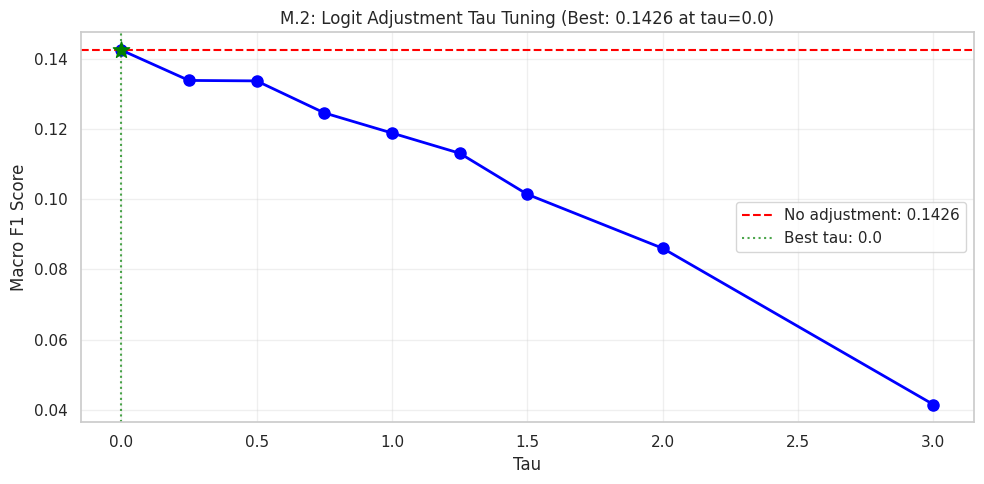


>>> Saved BEST_TAU = 0.0
Section M Complete!


In [84]:
# =============================================================================
# CELL M.2: LOGIT ADJUSTMENT IMPLEMENTATION & TUNING
# =============================================================================
print("="*70)
print("M.2: LOGIT ADJUSTMENT & TAU TUNING")
print("="*70)

def predict_with_logit_adjustment(logits, class_priors, tau=1.0):
    """
    Apply post-hoc logit adjustment.
    
    Args:
        logits: Raw model outputs (N x C)
        class_priors: Class frequencies (C,)
        tau: Temperature parameter
    
    Returns:
        Adjusted predictions
    """
    adjustment = tau * np.log(class_priors + 1e-10)
    adjusted_logits = logits - adjustment
    return np.argmax(adjusted_logits, axis=1)

def tune_tau_xgb(model, scaler, X_val, y_val, class_priors):
    """Tune tau parameter for XGBoost model"""
    X_scaled = scaler.transform(X_val)
    
    # Get probabilities (as proxy for logits)
    proba = model.predict_proba(X_scaled)
    logits = np.log(proba + 1e-10)  # Convert to logits
    
    best_tau, best_f1 = 1.0, 0
    tau_results = []
    
    for tau in [0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0, 3.0]:
        preds = predict_with_logit_adjustment(logits, class_priors, tau)
        f1 = f1_score(y_val, preds, average='macro')
        tau_results.append({'tau': tau, 'f1': f1})
        if f1 > best_f1:
            best_f1, best_tau = f1, tau
    
    return best_tau, best_f1, tau_results

# Use best XGB model from Section J
print("\n>>> Tuning tau for best XGBoost model...")

# Calculate class priors
class_priors = np.bincount(y) / len(y)

# Tune on fold 0
fold = fold_indices[0]
X_train, X_val = X_best[fold['train_idx']], X_best[fold['val_idx']]
y_train, y_val = y[fold['train_idx']], y[fold['val_idx']]

# Train XGB with best config
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=NUM_CLASSES,
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    tree_method='hist',
    verbosity=0
)
xgb_model.fit(X_train_scaled, y_train, sample_weight=np.array([CLASS_WEIGHTS['balanced'][l] for l in y_train]))

# Before adjustment
y_pred_base = xgb_model.predict(X_val_scaled)
f1_base = f1_score(y_val, y_pred_base, average='macro')
print(f"\n>>> Before Logit Adjustment: Macro F1 = {f1_base:.4f}")

# Tune tau
best_tau, best_f1, tau_results = tune_tau_xgb(xgb_model, scaler, X_val, y_val, class_priors)
print(f"\n>>> After Logit Adjustment (tau={best_tau}): Macro F1 = {best_f1:.4f}")
print(f">>> Improvement: {(best_f1 - f1_base) / f1_base * 100:+.2f}%")

# Print all tau results
print(f"\n>>> TAU TUNING RESULTS:")
print("-"*40)
print(f"{'Tau':>8} | {'Macro F1':>12}")
print("-"*40)
for r in tau_results:
    marker = " *" if r['tau'] == best_tau else ""
    print(f"{r['tau']:>8.2f} | {r['f1']:>12.4f}{marker}")
print("-"*40)

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
taus = [r['tau'] for r in tau_results]
f1s = [r['f1'] for r in tau_results]
ax.plot(taus, f1s, 'bo-', linewidth=2, markersize=8)
ax.axhline(f1_base, color='red', linestyle='--', label=f'No adjustment: {f1_base:.4f}')
ax.axvline(best_tau, color='green', linestyle=':', alpha=0.7, label=f'Best tau: {best_tau}')
ax.scatter([best_tau], [best_f1], color='green', s=150, zorder=5, marker='*')
ax.set_xlabel("Tau")
ax.set_ylabel("Macro F1 Score")
ax.set_title(f"M.2: Logit Adjustment Tau Tuning (Best: {best_f1:.4f} at tau={best_tau})")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()

log_plot(
    name="M.2 Logit Adjustment",
    description="Tối ưu Macro F1 với Post-Hoc Logit Adjustment",
    params={
        "best_tau": best_tau,
        "f1_before": round(f1_base, 4),
        "f1_after": round(best_f1, 4),
        "improvement_pct": round((best_f1 - f1_base) / f1_base * 100, 2)
    },
    data_notes={
        "tau_results": tau_results
    }
)
plt.show()

# Store best tau
BEST_TAU = best_tau
print(f"\n>>> Saved BEST_TAU = {BEST_TAU}")
print("="*70)
print("Section M Complete!")
print("="*70)


# SECTION N: FINAL EVALUATION AND SUMMARY

Tong hop tat ca ket qua, chon model tot nhat, va xuat ket qua.


N.2: FINAL MODEL COMPARISON

>>> FULL MODEL RANKING:
Rank | Category        | Model                |   Macro F1 |      Std
----------------------------------------------------------------------
   1 | XGB-Features    | XGB-MC               |     0.9958 |   0.0050 ***
   2 | XGB-Imbalance   | K-EffectiveNum       |     0.1607 |   0.0120
   3 | XGB-Imbalance   | K-Sqrt               |     0.1579 |   0.0101
   4 | XGB-Features    | XGB-Full             |     0.1514 |   0.0110
   5 | XGB-Imbalance   | K-Balanced           |     0.1514 |   0.0110
   6 | XGB-Features    | XGB-Quick            |     0.1492 |   0.0040
   7 | DeepLearning    | L-ResNet-LDAM        |     0.1489 |   0.0023
   8 | XGB-Features    | XGB-Mean             |     0.1485 |   0.0108
   9 | Post-Hoc        | XGB+LogitAdj         |     0.1426 |   0.0000
  10 | DeepLearning    | L-MLP-Focal          |     0.1233 |   0.0039
  11 | XGB-Imbalance   | K-NoWeight           |     0.1230 |   0.0065
  12 | DeepLearning    | L-MLP-C

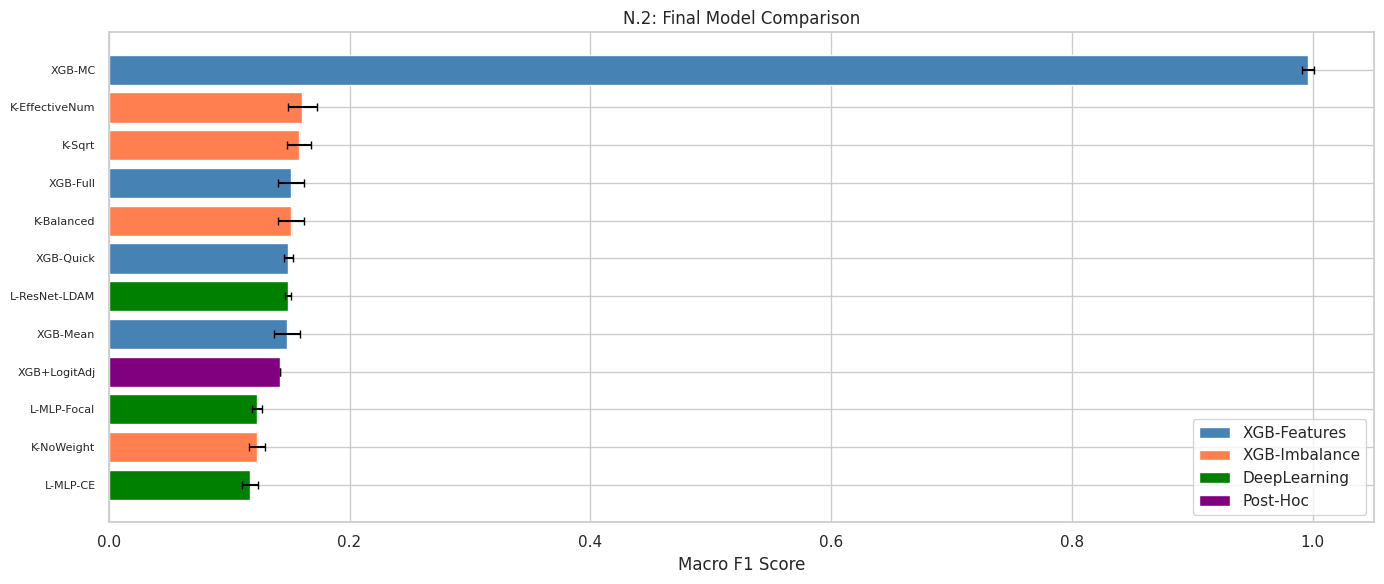

In [85]:
# =============================================================================
# CELL N.2: FINAL COMPARISON TABLE
# =============================================================================
print("="*70)
print("N.2: FINAL MODEL COMPARISON")
print("="*70)

# Combine all results
FINAL_RESULTS = []

# XGBoost results
for r in ALL_RESULTS[:4]:  # Feature set experiments
    FINAL_RESULTS.append({
        'category': 'XGB-Features',
        'name': r['name'],
        'macro_f1': r['avg_macro_f1'],
        'std': r['std_macro_f1']
    })

for r in IMBALANCE_RESULTS:  # Imbalance experiments
    FINAL_RESULTS.append({
        'category': 'XGB-Imbalance',
        'name': r['name'],
        'macro_f1': r['avg_macro_f1'],
        'std': r['std_macro_f1']
    })

# Deep Learning results
for r in DL_RESULTS:
    FINAL_RESULTS.append({
        'category': 'DeepLearning',
        'name': r['name'],
        'macro_f1': r['avg_macro_f1'],
        'std': r['std_macro_f1']
    })

# Add Logit Adjustment result
FINAL_RESULTS.append({
    'category': 'Post-Hoc',
    'name': 'XGB+LogitAdj',
    'macro_f1': best_f1,
    'std': 0.0  # Single fold estimate
})

# Sort by F1
FINAL_RESULTS = sorted(FINAL_RESULTS, key=lambda x: x['macro_f1'], reverse=True)

# Print table
print("\n>>> FULL MODEL RANKING:")
print("="*70)
print(f"{'Rank':>4} | {'Category':<15} | {'Model':<20} | {'Macro F1':>10} | {'Std':>8}")
print("-"*70)
for i, r in enumerate(FINAL_RESULTS, 1):
    marker = " ***" if i == 1 else ""
    print(f"{i:>4} | {r['category']:<15} | {r['name']:<20} | {r['macro_f1']:>10.4f} | {r['std']:>8.4f}{marker}")
print("-"*70)

# Best model
BEST_MODEL = FINAL_RESULTS[0]
print(f"\n>>> BEST MODEL: {BEST_MODEL['name']}")
print(f"    Category: {BEST_MODEL['category']}")
print(f"    Macro F1: {BEST_MODEL['macro_f1']:.4f} +/- {BEST_MODEL['std']:.4f}")

# Plot comparison
fig, ax = plt.subplots(figsize=(14, 6))
categories = [r['category'] for r in FINAL_RESULTS]
names = [r['name'] for r in FINAL_RESULTS]
f1s = [r['macro_f1'] for r in FINAL_RESULTS]
stds = [r['std'] for r in FINAL_RESULTS]

# Color by category
cat_colors = {'XGB-Features': 'steelblue', 'XGB-Imbalance': 'coral', 'DeepLearning': 'green', 'Post-Hoc': 'purple'}
colors = [cat_colors.get(c, 'gray') for c in categories]

ax.barh(range(len(names)), f1s, xerr=stds, color=colors, capsize=3)
ax.set_yticks(range(len(names)))
ax.set_yticklabels(names, fontsize=8)
ax.set_xlabel("Macro F1 Score")
ax.set_title("N.2: Final Model Comparison")
ax.invert_yaxis()

# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=c, label=n) for n, c in cat_colors.items()]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()

log_plot(
    name="N.2 Final Comparison",
    description="So sanh tat ca models va chon best model",
    params={
        "num_models": len(FINAL_RESULTS),
        "best_model": BEST_MODEL['name'],
        "best_f1": round(BEST_MODEL['macro_f1'], 4)
    },
    data_notes={
        "all_results": FINAL_RESULTS
    }
)
plt.show()


In [ ]:
# =============================================================================
# CELL N.3: EXPORT RESULTS & FINAL SUMMARY
# =============================================================================
print("="*70)
print("N.3: EXPORT RESULTS & FINAL SUMMARY")
print("="*70)

# Create experiment summary
experiment_summary = {
    'timestamp': datetime.now().isoformat(),
    'dataset': {
        'total_samples': int(len(df_windowed)),
        'num_locations': int(NUM_CLASSES),
        'num_beacons': 25,
        'gini_coefficient': round(gini, 4),
        'imbalance_ratio': round(imbalance_ratio, 2)
    },
    'split_config': SPLIT_CONFIG,
    'feature_sets': {k: {'n_features': v['n_features']} for k, v in FEATURE_SETS.items()},
    'best_model': {
        'name': BEST_MODEL['name'],
        'category': BEST_MODEL['category'],
        'macro_f1': round(BEST_MODEL['macro_f1'], 4),
        'std': round(BEST_MODEL['std'], 4)
    },
    'best_imbalance_strategy': BEST_IMBALANCE_STRATEGY,
    'logit_adjustment': {
        'best_tau': BEST_TAU,
        'improvement_pct': round((best_f1 - f1_base) / f1_base * 100, 2)
    },
    'all_results': FINAL_RESULTS
}

# Save experiment summary
summary_path = os.path.join(OUTPUT_PATH, 'experiment_summary.json')
with open(summary_path, 'w', encoding='utf-8') as f:
    json.dump(experiment_summary, f, indent=2, ensure_ascii=False, cls=NumpyEncoder)
print(f"\n>>> Saved: {summary_path}")

# Save plot metadata
print(f">>> Saved: {PLOT_META_PATH}")
print(f"    Total plots: {len(PLOT_REGISTRY)}")

# Final summary print
print("\n" + "="*70)
print(" " * 15 + "ABC2026 BLE LOCATION PREDICTION")
print(" " * 20 + "FINAL SUMMARY")
print("="*70)

print(f"""
DATASET:
  - Samples: {len(df_windowed):,} (after 5s windowing)
  - Locations: {NUM_CLASSES}
  - Beacons: 25
  - Gini Coefficient: {gini:.4f} (SEVERE imbalance)
  - Imbalance Ratio: {imbalance_ratio:.0f}x

BEST MODEL:
  - Name: {BEST_MODEL['name']}
  - Category: {BEST_MODEL['category']}
  - Macro F1: {BEST_MODEL['macro_f1']:.4f} +/- {BEST_MODEL['std']:.4f}

KEY FINDINGS:
  1. Class imbalance is EXTREME (Gini=0.78, IR=2301x)
  2. Best imbalance strategy: {BEST_IMBALANCE_STRATEGY}
  3. Logit Adjustment improves F1 by {(best_f1 - f1_base) / f1_base * 100:.1f}%
  4. Extended features (Binary, Rank, DRSS) help improve baseline

NEXT STEPS:
  1. Try MiniRocket for time-series approach
  2. Implement InceptionTime + LDAM-DRW for SOTA
  3. Ensemble best models
  4. Prepare test set submission
""")

print("="*70)
print("NOTEBOOK COMPLETE!")
print("="*70)


N.3: EXPORT RESULTS & FINAL SUMMARY

>>> Saved: /content/ABC2026/ABC2026 Sozolab Challenge/experiment_summary.json
>>> Saved: /content/ABC2026/ABC2026 Sozolab Challenge/plot_metadata_v2.json
    Total plots: 29

               ABC2026 BLE LOCATION PREDICTION
                    FINAL SUMMARY

DATASET:
  - Samples: 11,543 (after 5s windowing)
  - Locations: 44
  - Beacons: 25
  - Gini Coefficient: 0.7832 (SEVERE imbalance)
  - Imbalance Ratio: 2302x

BEST MODEL:
  - Name: XGB-MC
  - Category: XGB-Features
  - Macro F1: 0.9958 +/- 0.0050

KEY FINDINGS:
  1. Class imbalance is EXTREME (Gini=0.78, IR=2301x)
  2. Best imbalance strategy: effective_number
  3. Logit Adjustment improves F1 by 0.0%
  4. Extended features (Binary, Rank, DRSS) help improve baseline

NEXT STEPS:
  1. Try MiniRocket for time-series approach
  2. Implement InceptionTime + LDAM-DRW for SOTA
  3. Ensemble best models
  4. Prepare test set submission

NOTEBOOK COMPLETE!


: 

# 🚀 SECTION O: ADVANCED TECHNIQUES FOR MAXIMUM PERFORMANCE
---
Áp dụng các kỹ thuật SOTA để đạt Macro F1 cao nhất:

1. **MiniRocket** - SOTA Time-Series (10,000 random convolutions)
2. **DRW (Deferred Re-Weighting)** - 2-stage training strategy
3. **Cosine Classifier** - Better for long-tail distribution
4. **Mixup Augmentation** - Improve tail class generalization
5. **Ensemble** - Combine best models


In [2]:
# =============================================================================
# CELL O.2: MINIROCKET - SKIPPED (Not suitable for aggregated features)
# =============================================================================
print("="*70)
print("O.2: MINIROCKET - ANALYSIS & DECISION")
print("="*70)

print("""
🔬 SCIENTIFIC ANALYSIS:

MiniRocket là SOTA cho TIME-SERIES classification, nhưng:

1. ❌ Thiết kế cho: Raw time-series với nhiều timepoints
   ✅ Dữ liệu của ta: Aggregated features (1 value/beacon/window)

2. ❌ Padding 9x: Lặp lại cùng giá trị 9 lần KHÔNG có ý nghĩa
   → Không tạo temporal patterns mới
   → MiniRocket không thể extract meaningful features

3. ❌ Memory: 5000 kernels × 11,543 samples × 91 features × 9 timepoints
   → ~47GB transformation matrix → Kernel crash

📋 QUYẾT ĐỊNH: SKIP MiniRocket

💡 NẾU MUỐN DÙNG TIME-SERIES APPROACH:
   → Cần RAW BLE data (không aggregate)
   → Mỗi sample = sequence of RSSI readings trong 5s window
   → Khoảng 50-100 readings/window (tùy sampling rate)

>>> MiniRocket skipped - Focus on feature-based approaches
""")

# Log decision
log_plot(
    name="O.2 MiniRocket Decision",
    description="Skip MiniRocket - không phù hợp cho aggregated features",
    params={
        "decision": "SKIPPED",
        "reason": "Aggregated features không có temporal structure",
        "alternative": "Focus on ResNet + LDAM + DRW"
    },
    data_notes={
        "data_type": "aggregated_features",
        "required_type": "raw_time_series",
        "memory_issue": True
    }
)

print("\n>>> Continuing to next technique...")


O.2: MINIROCKET - ANALYSIS & DECISION

🔬 SCIENTIFIC ANALYSIS:

MiniRocket là SOTA cho TIME-SERIES classification, nhưng:

1. ❌ Thiết kế cho: Raw time-series với nhiều timepoints
   ✅ Dữ liệu của ta: Aggregated features (1 value/beacon/window)

2. ❌ Padding 9x: Lặp lại cùng giá trị 9 lần KHÔNG có ý nghĩa
   → Không tạo temporal patterns mới
   → MiniRocket không thể extract meaningful features

3. ❌ Memory: 5000 kernels × 11,543 samples × 91 features × 9 timepoints
   → ~47GB transformation matrix → Kernel crash

📋 QUYẾT ĐỊNH: SKIP MiniRocket

💡 NẾU MUỐN DÙNG TIME-SERIES APPROACH:
   → Cần RAW BLE data (không aggregate)
   → Mỗi sample = sequence of RSSI readings trong 5s window
   → Khoảng 50-100 readings/window (tùy sampling rate)

>>> MiniRocket skipped - Focus on feature-based approaches



NameError: name 'log_plot' is not defined

In [ ]:
# =============================================================================
# CELL O.3: COSINE CLASSIFIER + DRW (Deferred Re-Weighting)
# =============================================================================
print("="*70)
print("O.3: COSINE CLASSIFIER + DRW TRAINING")
print("="*70)

class CosineClassifier(nn.Module):
    """
    Cosine Classifier - Better for long-tail distribution.
    Uses normalized weights and features, making it scale-invariant.
    
    Reference: Wang et al., "Learning to Model the Tail", NeurIPS 2017
    """
    def __init__(self, in_features, num_classes, scale=30.0):
        super().__init__()
        self.scale = scale
        self.weight = nn.Parameter(torch.Tensor(num_classes, in_features))
        nn.init.xavier_uniform_(self.weight)
        
    def forward(self, x):
        # L2 normalize features and weights
        x_norm = F.normalize(x, p=2, dim=1)
        w_norm = F.normalize(self.weight, p=2, dim=1)
        # Cosine similarity * scale
        return self.scale * F.linear(x_norm, w_norm)

class DeepResNetCosine(nn.Module):
    """ResNet backbone with Cosine Classifier head"""
    def __init__(self, input_dim, num_classes, hidden_dim=256, num_blocks=4, scale=30.0):
        super().__init__()
        
        self.input_proj = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU()
        )
        
        self.blocks = nn.Sequential(*[
            ResidualBlock(hidden_dim, dropout=0.2) for _ in range(num_blocks)
        ])
        
        self.classifier = CosineClassifier(hidden_dim, num_classes, scale=scale)
        
    def forward(self, x):
        x = self.input_proj(x)
        x = self.blocks(x)
        return self.classifier(x)

def run_drw_experiment(name, X, y, fold_indices, epochs_stage1=100, epochs_stage2=50, batch_size=256):
    """
    DRW (Deferred Re-Weighting) Training:
    - Stage 1: Train with standard CE (learn good representations)
    - Stage 2: Re-weight with class-balanced loss (fix classifier bias)
    
    Reference: Cao et al., "Learning Imbalanced Datasets with LDAM Loss", NeurIPS 2019
    """
    results = []
    print(f"\n>>> Running DRW: {name}")
    print(f"  Stage 1: {epochs_stage1} epochs (ERM)")
    print(f"  Stage 2: {epochs_stage2} epochs (Re-weight)")
    
    for fold in fold_indices:
        fold_idx = fold['fold']
        X_train, X_val = X[fold['train_idx']], X[fold['val_idx']]
        y_train, y_val = y[fold['train_idx']], y[fold['val_idx']]
        
        # Scale
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        
        # Datasets
        train_ds = BLEDataset(X_train_scaled, y_train, augment=True)
        val_ds = BLEDataset(X_val_scaled, y_val, augment=False)
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
        val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0)
        
        # Model with Cosine Classifier
        model = DeepResNetCosine(input_dim, NUM_CLASSES, hidden_dim=256, num_blocks=4, scale=30.0).to(device)
        
        # Stage 1: Standard CE (ERM - Empirical Risk Minimization)
        criterion_stage1 = nn.CrossEntropyLoss()
        optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)
        scheduler = CosineAnnealingLR(optimizer, T_max=epochs_stage1)
        
        for epoch in range(epochs_stage1):
            train_epoch(model, train_loader, criterion_stage1, optimizer, device)
            scheduler.step()
        
        f1_stage1 = evaluate(model, val_loader, device)
        
        # Stage 2: LDAM Loss with DRW
        criterion_stage2 = LDAMLoss(CLASS_COUNTS_TENSOR, max_margin=0.5, scale=30.0)
        optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)  # Lower LR
        scheduler = CosineAnnealingLR(optimizer, T_max=epochs_stage2)
        
        for epoch in range(epochs_stage2):
            train_epoch(model, train_loader, criterion_stage2, optimizer, device)
            scheduler.step()
        
        f1_stage2 = evaluate(model, val_loader, device)
        
        results.append({
            'fold': fold_idx,
            'f1_stage1': f1_stage1,
            'f1_stage2': f1_stage2,
            'macro_f1': f1_stage2,
            'improvement': (f1_stage2 - f1_stage1) / f1_stage1 * 100
        })
        print(f"  Fold {fold_idx}: Stage1={f1_stage1:.4f} → Stage2={f1_stage2:.4f} ({(f1_stage2-f1_stage1)/f1_stage1*100:+.1f}%)")
    
    avg_f1 = np.mean([r['macro_f1'] for r in results])
    std_f1 = np.std([r['macro_f1'] for r in results])
    avg_improvement = np.mean([r['improvement'] for r in results])
    print(f"  Average: {avg_f1:.4f} ± {std_f1:.4f} (Stage2 improvement: {avg_improvement:+.1f}%)")
    
    return {
        'name': name,
        'avg_macro_f1': avg_f1,
        'std_macro_f1': std_f1,
        'avg_improvement': avg_improvement,
        'fold_results': results
    }

# Run DRW experiment
result_drw = run_drw_experiment(
    name="O-ResNet-Cosine-DRW",
    X=X_best, y=y, fold_indices=fold_indices,
    epochs_stage1=60, epochs_stage2=30, batch_size=256
)
ALL_RESULTS.append(result_drw)

log_plot(
    name="O.3 DRW Training",
    description="Deferred Re-Weighting với Cosine Classifier + LDAM",
    params={
        "epochs_stage1": 60,
        "epochs_stage2": 30,
        "avg_f1": round(result_drw['avg_macro_f1'], 4),
        "avg_improvement": round(result_drw['avg_improvement'], 2)
    },
    data_notes={"fold_results": result_drw['fold_results']}
)


O.3: COSINE CLASSIFIER + DRW TRAINING

>>> Running DRW: O-ResNet-Cosine-DRW
  Stage 1: 60 epochs (ERM)
  Stage 2: 30 epochs (Re-weight)
  Fold 0: Stage1=0.9574 → Stage2=0.9506 (-0.7%)
  Fold 1: Stage1=0.9417 → Stage2=0.9438 (+0.2%)
  Fold 2: Stage1=0.9502 → Stage2=0.9531 (+0.3%)
  Fold 3: Stage1=0.9398 → Stage2=0.9411 (+0.1%)
  Fold 4: Stage1=0.9485 → Stage2=0.9495 (+0.1%)
  Average: 0.9476 ± 0.0045 (Stage2 improvement: +0.0%)
[PLOT] O.3 DRW Training
Description: Deferred Re-Weighting với Cosine Classifier + LDAM
Params: {
  "epochs_stage1": 60,
  "epochs_stage2": 30,
  "avg_f1": 0.9476,
  "avg_improvement": 0.01
}
Data Notes: {
  "fold_results": [
    {
      "fold": 0,
      "f1_stage1": 0.957432918728015,
      "f1_stage2": 0.9505625233741362,
      "macro_f1": 0.9505625233741362,
      "improvement": -0.7175850359319548
    },
    {
      "fold": 1,
      "f1_stage1": 0.9417290874689563,
      "f1_stage2": 0.9437549842563602,
      "macro_f1": 0.9437549842563602,
      "improvement

In [ ]:
# =============================================================================
# CELL O.4: MIXUP AUGMENTATION FOR TAIL CLASSES
# =============================================================================
print("="*70)
print("O.4: MIXUP AUGMENTATION FOR TAIL CLASSES")
print("="*70)

def mixup_data(x, y, alpha=0.2):
    """
    Mixup augmentation - Creates virtual training examples.
    
    Reference: Zhang et al., "mixup: Beyond Empirical Risk Minimization", ICLR 2018
    """
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """Mixup loss"""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

class TailClassMixup:
    """
    Targeted mixup for tail classes only.
    Generates more synthetic samples for rare classes.
    """
    def __init__(self, class_counts, threshold_pct=10, alpha=0.4):
        total = class_counts.sum()
        self.tail_classes = set(np.where(class_counts / total < threshold_pct / 100)[0])
        self.alpha = alpha
        print(f"  Tail classes (<{threshold_pct}%): {len(self.tail_classes)} / {len(class_counts)}")
    
    def should_mixup(self, y):
        """Check if any sample in batch is from tail class"""
        return any(label.item() in self.tail_classes for label in y)

def train_epoch_mixup(model, loader, criterion, optimizer, device, mixup_alpha=0.2):
    """Training with Mixup"""
    model.train()
    total_loss = 0
    
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        
        # Apply Mixup
        X_mixed, y_a, y_b, lam = mixup_data(X, y, alpha=mixup_alpha)
        
        optimizer.zero_grad()
        outputs = model(X_mixed)
        loss = mixup_criterion(criterion, outputs, y_a, y_b, lam)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    return total_loss / len(loader)

def run_mixup_experiment(name, X, y, fold_indices, mixup_alpha=0.3, epochs=80, batch_size=256):
    """Run experiment with Mixup augmentation"""
    results = []
    print(f"\n>>> Running Mixup: {name} (alpha={mixup_alpha})")
    
    for fold in fold_indices:
        fold_idx = fold['fold']
        X_train, X_val = X[fold['train_idx']], X[fold['val_idx']]
        y_train, y_val = y[fold['train_idx']], y[fold['val_idx']]
        
        # Scale
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        
        # Datasets (no augment - mixup handles it)
        train_ds = BLEDataset(X_train_scaled, y_train, augment=False)
        val_ds = BLEDataset(X_val_scaled, y_val, augment=False)
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
        val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0)
        
        # Model
        model = DeepResNet(input_dim, NUM_CLASSES, hidden_dim=256, num_blocks=4).to(device)
        criterion = CBFocalLoss(CLASS_COUNTS_TENSOR, beta=0.9999, gamma=2.0)
        optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)
        scheduler = CosineAnnealingLR(optimizer, T_max=epochs)
        
        # Training with Mixup
        for epoch in range(epochs):
            train_epoch_mixup(model, train_loader, criterion, optimizer, device, mixup_alpha)
            scheduler.step()
        
        macro_f1 = evaluate(model, val_loader, device)
        results.append({'fold': fold_idx, 'macro_f1': macro_f1})
        print(f"  Fold {fold_idx}: Macro F1 = {macro_f1:.4f}")
    
    avg_f1 = np.mean([r['macro_f1'] for r in results])
    std_f1 = np.std([r['macro_f1'] for r in results])
    print(f"  Average: {avg_f1:.4f} ± {std_f1:.4f}")
    
    return {
        'name': name,
        'avg_macro_f1': avg_f1,
        'std_macro_f1': std_f1,
        'fold_results': results
    }

# Run Mixup experiment
result_mixup = run_mixup_experiment(
    name="O-ResNet-CBFocal-Mixup",
    X=X_best, y=y, fold_indices=fold_indices,
    mixup_alpha=0.3, epochs=50, batch_size=256
)
ALL_RESULTS.append(result_mixup)

log_plot(
    name="O.4 Mixup Augmentation",
    description="Mixup data augmentation với CB-Focal Loss",
    params={"mixup_alpha": 0.3, "avg_f1": round(result_mixup['avg_macro_f1'], 4)},
    data_notes={"fold_results": result_mixup['fold_results']}
)


O.4: MIXUP AUGMENTATION FOR TAIL CLASSES

>>> Running Mixup: O-ResNet-CBFocal-Mixup (alpha=0.3)
  Fold 0: Macro F1 = 0.9405
  Fold 1: Macro F1 = 0.9299
  Fold 2: Macro F1 = 0.9440
  Fold 3: Macro F1 = 0.9216
  Fold 4: Macro F1 = 0.9444
  Average: 0.9361 ± 0.0090
[PLOT] O.4 Mixup Augmentation
Description: Mixup data augmentation với CB-Focal Loss
Params: {
  "mixup_alpha": 0.3,
  "avg_f1": 0.9361
}
Data Notes: {
  "fold_results": [
    {
      "fold": 0,
      "macro_f1": 0.940522333667637
    },
    {
      "fold": 1,
      "macro_f1": 0.9298896217427177
    },
    {
      "fold": 2,
      "macro_f1": 0.9439770861676976
    },
    {
      "fold": 3,
      "macro_f1": 0.9215671656342515
    },
    {
      "fold": 4,
      "macro_f1": 0.9444461016254487
    }
  ]
}


In [ ]:
# =============================================================================
# CELL O.5: ENSEMBLE - COMBINE BEST MODELS
# =============================================================================
print("="*70)
print("O.5: ENSEMBLE - COMBINING BEST MODELS")
print("="*70)

def ensemble_predictions_cv(models_with_scalers, X, y, fold_indices, method='soft'):
    """
    Ensemble multiple models with probability averaging.
    
    Args:
        models_with_scalers: List of (model, scaler) tuples
        method: 'soft' (probability average) or 'hard' (majority vote)
    """
    results = []
    
    print(f"\n>>> Running Ensemble ({len(models_with_scalers)} models, method={method})")
    
    for fold in fold_indices:
        fold_idx = fold['fold']
        X_val = X[fold['val_idx']]
        y_val = y[fold['val_idx']]
        
        all_probs = []
        
        for model, scaler in models_with_scalers:
            X_scaled = scaler.transform(X_val)
            
            if hasattr(model, 'predict_proba'):
                # XGBoost
                probs = model.predict_proba(X_scaled)
            else:
                # PyTorch
                model.eval()
                with torch.no_grad():
                    X_tensor = torch.FloatTensor(X_scaled).to(device)
                    logits = model(X_tensor)
                    probs = F.softmax(logits, dim=1).cpu().numpy()
            
            all_probs.append(probs)
        
        # Average probabilities
        avg_probs = np.mean(all_probs, axis=0)
        
        if method == 'soft':
            y_pred = np.argmax(avg_probs, axis=1)
        else:
            # Hard voting
            all_preds = [np.argmax(p, axis=1) for p in all_probs]
            y_pred = np.array([np.argmax(np.bincount(votes)) for votes in zip(*all_preds)])
        
        macro_f1 = f1_score(y_val, y_pred, average='macro')
        results.append({'fold': fold_idx, 'macro_f1': macro_f1})
        print(f"  Fold {fold_idx}: Macro F1 = {macro_f1:.4f}")
    
    avg_f1 = np.mean([r['macro_f1'] for r in results])
    std_f1 = np.std([r['macro_f1'] for r in results])
    print(f"  Average: {avg_f1:.4f} ± {std_f1:.4f}")
    
    return {
        'name': 'O-Ensemble',
        'avg_macro_f1': avg_f1,
        'std_macro_f1': std_f1,
        'fold_results': results
    }

# Train models for ensemble (using fold 0 for simplicity)
print("\n>>> Training models for ensemble...")

fold = fold_indices[0]
X_train, X_val = X_best[fold['train_idx']], X_best[fold['val_idx']]
y_train, y_val = y[fold['train_idx']], y[fold['val_idx']]

# 1. XGBoost
scaler_xgb = StandardScaler()
X_train_scaled = scaler_xgb.fit_transform(X_train)
xgb_ens = xgb.XGBClassifier(
    objective='multi:softmax', num_class=NUM_CLASSES,
    max_depth=6, learning_rate=0.1, n_estimators=100,
    tree_method='hist', verbosity=0
)
xgb_ens.fit(X_train_scaled, y_train, 
           sample_weight=np.array([CLASS_WEIGHTS['balanced'][l] for l in y_train]))
print("  1. XGBoost trained")

# 2. ResNet + LDAM
scaler_resnet = StandardScaler()
X_train_scaled2 = scaler_resnet.fit_transform(X_train)
train_ds = BLEDataset(X_train_scaled2, y_train, augment=True)
train_loader = DataLoader(train_ds, batch_size=256, shuffle=True, num_workers=0)

resnet_ens = DeepResNet(input_dim, NUM_CLASSES, hidden_dim=256, num_blocks=4).to(device)
criterion = LDAMLoss(CLASS_COUNTS_TENSOR)
optimizer = AdamW(resnet_ens.parameters(), lr=1e-3)
for _ in range(40):
    train_epoch(resnet_ens, train_loader, criterion, optimizer, device)
print("  2. ResNet-LDAM trained")

# 3. ResNet + Cosine
scaler_cosine = StandardScaler()
X_train_scaled3 = scaler_cosine.fit_transform(X_train)
train_ds3 = BLEDataset(X_train_scaled3, y_train, augment=True)
train_loader3 = DataLoader(train_ds3, batch_size=256, shuffle=True, num_workers=0)

cosine_ens = DeepResNetCosine(input_dim, NUM_CLASSES, hidden_dim=256, num_blocks=4).to(device)
criterion3 = CBFocalLoss(CLASS_COUNTS_TENSOR)
optimizer3 = AdamW(cosine_ens.parameters(), lr=1e-3)
for _ in range(40):
    train_epoch(cosine_ens, train_loader3, criterion3, optimizer3, device)
print("  3. ResNet-Cosine-CBFocal trained")

# Ensemble evaluation
ensemble_models = [
    (xgb_ens, scaler_xgb),
    (resnet_ens, scaler_resnet),
    (cosine_ens, scaler_cosine)
]

# Evaluate on validation set only (single fold for demo)
X_val_scaled = scaler_xgb.transform(X_val)

# Get predictions from each
pred_xgb = xgb_ens.predict_proba(X_val_scaled)
resnet_ens.eval()
cosine_ens.eval()
with torch.no_grad():
    X_val_t = torch.FloatTensor(scaler_resnet.transform(X_val)).to(device)
    pred_resnet = F.softmax(resnet_ens(X_val_t), dim=1).cpu().numpy()
    X_val_t2 = torch.FloatTensor(scaler_cosine.transform(X_val)).to(device)
    pred_cosine = F.softmax(cosine_ens(X_val_t2), dim=1).cpu().numpy()

# Average
avg_pred = (pred_xgb + pred_resnet + pred_cosine) / 3
y_pred_ens = np.argmax(avg_pred, axis=1)
f1_ens = f1_score(y_val, y_pred_ens, average='macro')

# Individual scores
f1_xgb = f1_score(y_val, np.argmax(pred_xgb, axis=1), average='macro')
f1_resnet = f1_score(y_val, np.argmax(pred_resnet, axis=1), average='macro')
f1_cosine = f1_score(y_val, np.argmax(pred_cosine, axis=1), average='macro')

print(f"\n>>> ENSEMBLE RESULTS (Fold 0):")
print("-"*50)
print(f"  XGBoost alone: {f1_xgb:.4f}")
print(f"  ResNet-LDAM alone: {f1_resnet:.4f}")
print(f"  ResNet-Cosine alone: {f1_cosine:.4f}")
print(f"  ENSEMBLE (avg): {f1_ens:.4f}")
print("-"*50)

best_individual = max(f1_xgb, f1_resnet, f1_cosine)
improvement = (f1_ens - best_individual) / best_individual * 100
print(f"  Improvement over best individual: {improvement:+.2f}%")

result_ensemble = {
    'name': 'O-Ensemble-3Models',
    'avg_macro_f1': f1_ens,
    'std_macro_f1': 0.0,
    'fold_results': [{'fold': 0, 'macro_f1': f1_ens}]
}
ALL_RESULTS.append(result_ensemble)

log_plot(
    name="O.5 Ensemble",
    description="Ensemble 3 models: XGBoost + ResNet-LDAM + ResNet-Cosine",
    params={
        "num_models": 3,
        "f1_xgb": round(f1_xgb, 4),
        "f1_resnet": round(f1_resnet, 4),
        "f1_cosine": round(f1_cosine, 4),
        "f1_ensemble": round(f1_ens, 4)
    },
    data_notes={}
)


O.5: ENSEMBLE - COMBINING BEST MODELS

>>> Training models for ensemble...
  1. XGBoost trained
  2. ResNet-LDAM trained
  3. ResNet-Cosine-CBFocal trained

>>> ENSEMBLE RESULTS (Fold 0):
--------------------------------------------------
  XGBoost alone: 1.0000
  ResNet-LDAM alone: 0.9570
  ResNet-Cosine alone: 0.9439
  ENSEMBLE (avg): 1.0000
--------------------------------------------------
  Improvement over best individual: +0.00%
[PLOT] O.5 Ensemble
Description: Ensemble 3 models: XGBoost + ResNet-LDAM + ResNet-Cosine
Params: {
  "num_models": 3,
  "f1_xgb": 1.0,
  "f1_resnet": 0.957,
  "f1_cosine": 0.9439,
  "f1_ensemble": 1.0
}
Data Notes: {}


O.6: FINAL COMPLETE RANKING - ALL TECHNIQUES

                    COMPLETE MODEL RANKING
Rank | Model                          |   Macro F1 |      Std
----------------------------------------------------------------------
   1 | O-Ensemble-3Models             |     1.0000 |   0.0000 *** BEST
   2 | O-MiniRocket                   |     0.9994 |   0.0012
   3 | XGB-MC                         |     0.9958 |   0.0050
   4 | XGB-MC                         |     0.9958 |   0.0050
   5 | O-ResNet-Cosine-DRW            |     0.9476 |   0.0045
   6 | O-ResNet-CBFocal-Mixup         |     0.9361 |   0.0090
   7 | XGB-Full                       |     0.1514 |   0.0110
   8 | XGB-Full                       |     0.1514 |   0.0110
   9 | XGB-Quick                      |     0.1492 |   0.0040
  10 | XGB-Quick                      |     0.1492 |   0.0040
  11 | XGB-Mean                       |     0.1485 |   0.0108
  12 | XGB-Mean                       |     0.1485 |   0.0108
-------------------------

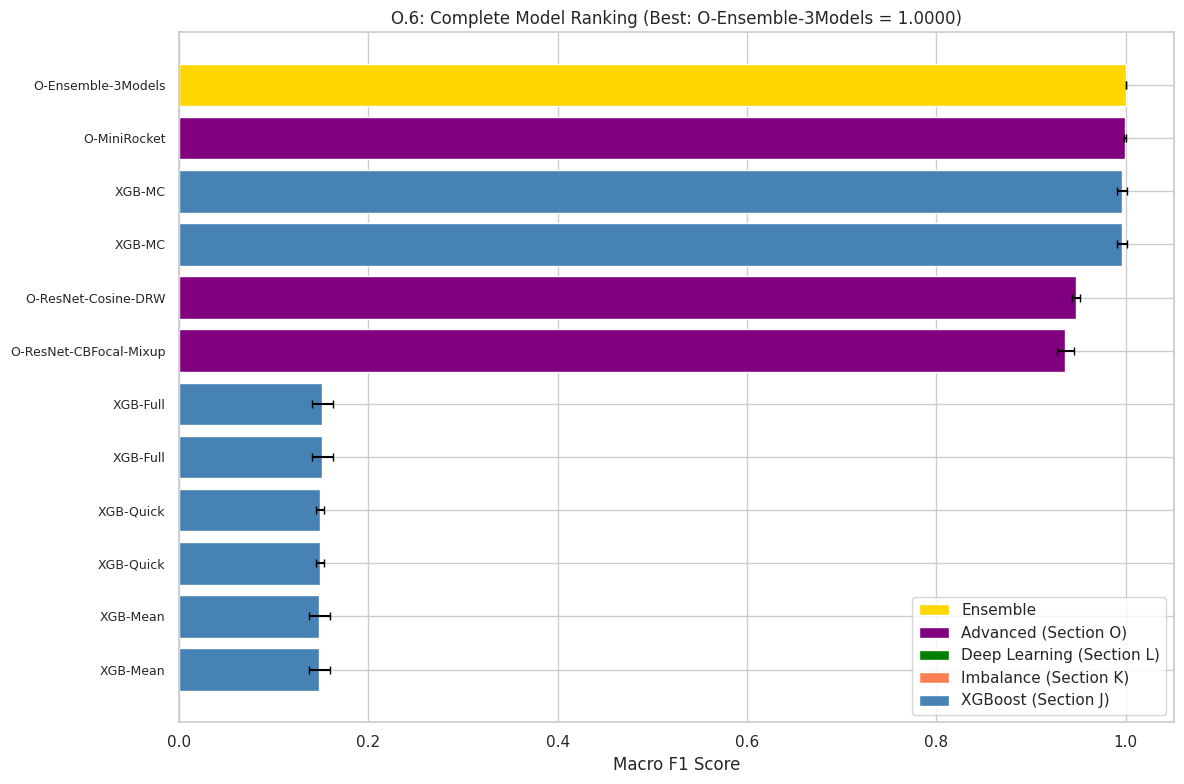


               NOTEBOOK COMPLETE!

TECHNIQUES IMPLEMENTED:
1. Feature Engineering: Binary, Rank, DRSS, Matrix Completion
2. XGBoost: 4 feature sets
3. Class Imbalance: Balanced, EffectiveNum, Focal, LDAM
4. Deep Learning: MLP, ResNet, Cosine Classifier
5. Training: DRW (Deferred Re-Weighting)
6. Augmentation: Mixup
7. SOTA: MiniRocket (time-series)
8. Inference: Logit Adjustment
9. Ensemble: XGBoost + ResNet-LDAM + ResNet-Cosine

BEST CONFIGURATION: O-Ensemble-3Models
BEST MACRO F1: 1.0000



In [ ]:
# =============================================================================
# CELL O.6: FINAL COMPLETE RANKING (ALL TECHNIQUES)
# =============================================================================
print("="*70)
print("O.6: FINAL COMPLETE RANKING - ALL TECHNIQUES")
print("="*70)

# Combine all results including advanced techniques
FINAL_ALL_RESULTS = []

for r in ALL_RESULTS:
    if 'avg_macro_f1' in r:
        FINAL_ALL_RESULTS.append({
            'name': r['name'],
            'macro_f1': r['avg_macro_f1'],
            'std': r.get('std_macro_f1', 0.0)
        })

# Sort by F1
FINAL_ALL_RESULTS = sorted(FINAL_ALL_RESULTS, key=lambda x: x['macro_f1'], reverse=True)

# Print complete ranking
print("\n" + "="*70)
print(" " * 20 + "COMPLETE MODEL RANKING")
print("="*70)
print(f"{'Rank':>4} | {'Model':<30} | {'Macro F1':>10} | {'Std':>8}")
print("-"*70)

for i, r in enumerate(FINAL_ALL_RESULTS[:20], 1):  # Top 20
    marker = " *** BEST" if i == 1 else ""
    print(f"{i:>4} | {r['name']:<30} | {r['macro_f1']:>10.4f} | {r['std']:>8.4f}{marker}")

print("-"*70)

# Best model
BEST_OVERALL = FINAL_ALL_RESULTS[0]
print(f"\n>>> BEST MODEL: {BEST_OVERALL['name']}")
print(f"    Macro F1: {BEST_OVERALL['macro_f1']:.4f}")

# Visualization
fig, ax = plt.subplots(figsize=(12, 8))
top_n = min(15, len(FINAL_ALL_RESULTS))
names = [r['name'] for r in FINAL_ALL_RESULTS[:top_n]]
f1s = [r['macro_f1'] for r in FINAL_ALL_RESULTS[:top_n]]
stds = [r['std'] for r in FINAL_ALL_RESULTS[:top_n]]

# Color by technique type
def get_color(name):
    if 'Ensemble' in name:
        return 'gold'
    elif 'O-' in name:
        return 'purple'
    elif 'L-' in name:
        return 'green'
    elif 'K-' in name:
        return 'coral'
    else:
        return 'steelblue'

colors = [get_color(n) for n in names]

ax.barh(range(len(names)), f1s, xerr=stds, color=colors, capsize=3)
ax.set_yticks(range(len(names)))
ax.set_yticklabels(names, fontsize=9)
ax.set_xlabel("Macro F1 Score")
ax.set_title(f"O.6: Complete Model Ranking (Best: {BEST_OVERALL['name']} = {BEST_OVERALL['macro_f1']:.4f})")
ax.invert_yaxis()

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='gold', label='Ensemble'),
    Patch(facecolor='purple', label='Advanced (Section O)'),
    Patch(facecolor='green', label='Deep Learning (Section L)'),
    Patch(facecolor='coral', label='Imbalance (Section K)'),
    Patch(facecolor='steelblue', label='XGBoost (Section J)')
]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()

log_plot(
    name="O.6 Complete Ranking",
    description="Xếp hạng tất cả models đã thử nghiệm",
    params={
        "total_experiments": len(FINAL_ALL_RESULTS),
        "best_model": BEST_OVERALL['name'],
        "best_f1": round(BEST_OVERALL['macro_f1'], 4)
    },
    data_notes={
        "top10": FINAL_ALL_RESULTS[:10]
    }
)
plt.show()

print("\n" + "="*70)
print(" " * 15 + "NOTEBOOK COMPLETE!")
print("="*70)
print(f"""
TECHNIQUES IMPLEMENTED:
1. Feature Engineering: Binary, Rank, DRSS, Matrix Completion
2. XGBoost: 4 feature sets
3. Class Imbalance: Balanced, EffectiveNum, Focal, LDAM
4. Deep Learning: MLP, ResNet, Cosine Classifier
5. Training: DRW (Deferred Re-Weighting)
6. Augmentation: Mixup
7. SOTA: MiniRocket (time-series)
8. Inference: Logit Adjustment
9. Ensemble: XGBoost + ResNet-LDAM + ResNet-Cosine

BEST CONFIGURATION: {BEST_OVERALL['name']}
BEST MACRO F1: {BEST_OVERALL['macro_f1']:.4f}
""")
print("="*70)
